In [60]:
import os
import re
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import geometry_mask
from scipy import ndimage
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import joblib
from sklearn.utils.class_weight import compute_class_weight

In [61]:
from sklearn.utils.class_weight import compute_class_weight# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    shapefile_path = matching_shapefiles[0]
    file_pairs[image_path] = shapefile_path

# Function to extract features and labels
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    img_name = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']

        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
            img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

features = []
labels = []
image_name = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)
    image_name.append(img_name)

features = np.vstack(features)
labels = np.hstack(labels)
image_name = np.hstack(image_name)
print(features, labels, image_name)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({'Coast_blue': features[:, 0],
                        'Blue': features[:, 1],
                        'Green1': features[:, 2],
                        'Green': features[:, 3],
                        'Yellow': features[:, 4],
                        'Red': features[:, 5],
                        'Red_edge': features[:, 6],
                        'NIR': features[:, 7],
                        'labels': labels,
                        'encoded_labels': encoded_labels,
                        'image_name': image_name})


No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif
[[1187  980 1269 ... 1329 1416 1650]
 [1148  912 1212 ... 1240 1297 1612]
 [1131  856 1162 ... 1181 1355 1510]
 ...
 [1730 1870 1929 ... 2091 2276 2647]
 [1634 1851 1879 ... 2053 2281 2634]
 [1720 1904 1905 ... 2135 2316 2654]] ['walrus_mixed' 'walrus_mixed' 'walrus_mixed' ... 'freshwater'
 'freshwater' 'freshwater'] ['C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 ...
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_ima

In [62]:
# Function to calculate and print class distribution
def print_class_distribution(df, name):
    class_counts = df['encoded_labels'].value_counts()
    class_names = le.inverse_transform(class_counts.index)
    print(f"\n{name} Class Distribution:")
    for class_name, count in zip(class_names, class_counts):
        print(f"{class_name}: {count}")

# Function to calculate and print class distribution by island
def print_class_distribution_by_island(df, name):
    class_counts = df.groupby(['image_name', 'encoded_labels']).size().unstack(fill_value=0)
    class_counts = class_counts.reset_index()
    class_counts['island'] = class_counts['image_name'].apply(lambda x: extract_island_and_date(x)[0])
    print(f"\n{name} Class Distribution by Island:")
    print(class_counts)

# Ensure each island and rare classes are in the train set
def custom_train_test_split(df, test_size=0.2):
    skf = StratifiedKFold(n_splits=int(1/test_size), shuffle=True, random_state=42)
    for train_index, test_index in skf.split(df, df['encoded_labels']):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        # Ensure that rare classes are in the training set
        if not all(cls in train_df['encoded_labels'].values for cls in [le.transform(['walrus_pure'])[0], le.transform(['walrus_mixed'])[0]]):
            continue
        # Ensure each island is in the training set
        unique_islands = df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
        if all(island in train_df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique() for island in unique_islands):
            return train_df, test_df
    return train_df, test_df

# Split the data
train_df, test_df = custom_train_test_split(dataset)
X_train, y_train = train_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, train_df['encoded_labels'].values
X_test, y_test = test_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, test_df['encoded_labels'].values

# Print class distributions before applying class weights
print_class_distribution(train_df, "Training Before Class Weights")
print_class_distribution(test_df, "Test")

# Function to count pixels of each class in the training data
def count_class_pixels(labels, label_encoder):
    unique, counts = np.unique(labels, return_counts=True)
    class_counts = dict(zip(unique, counts))
    class_names = label_encoder.inverse_transform(list(class_counts.keys()))
    class_pixel_counts = {class_name: class_counts[i] for i, class_name in enumerate(class_names)}
    return class_pixel_counts

# Count pixels of each class in the training data
class_pixel_counts = count_class_pixels(y_train, le)

# Print the number of pixels of each class
print("Number of pixels of each class in the training data:")
for class_name, count in class_pixel_counts.items():
    print(f"{class_name}: {count}")
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Train the Random Forest model using the class weights
model = RandomForestClassifier(n_estimators=100, class_weight=class_weight_dict, random_state=42)
model.fit(X_train, y_train)

# Save the model
model_filename = "RF_allislands_ClassWeights.joblib"
joblib.dump(model, model_filename)


Training Before Class Weights Class Distribution:
ocean: 623431
ice: 240185
rock: 74284
freshwater: 32201
walrus_mixed: 657
walrus_pure: 38

Test Class Distribution:
ocean: 155857
ice: 60046
rock: 18572
freshwater: 8050
walrus_mixed: 165
walrus_pure: 10
Number of pixels of each class in the training data:
freshwater: 32201
ice: 240185
ocean: 623431
rock: 74284
walrus_mixed: 657
walrus_pure: 38


['RF_allislands_ClassWeights.joblib']

Accuracy: 0.988772146683148
Precision: 0.9886750723403176
Recall: 0.988772146683148
F1 Score: 0.9885704076264737
Cohen's Kappa: 0.9783576099559044

Classification Report:
              precision    recall  f1-score   support

  freshwater       0.92      0.87      0.89      8050
         ice       0.97      0.99      0.98     60046
       ocean       1.00      1.00      1.00    155857
        rock       0.98      0.97      0.97     18572
walrus_mixed       0.92      0.29      0.44       165
 walrus_pure       1.00      0.80      0.89        10

    accuracy                           0.99    242700
   macro avg       0.97      0.82      0.86    242700
weighted avg       0.99      0.99      0.99    242700


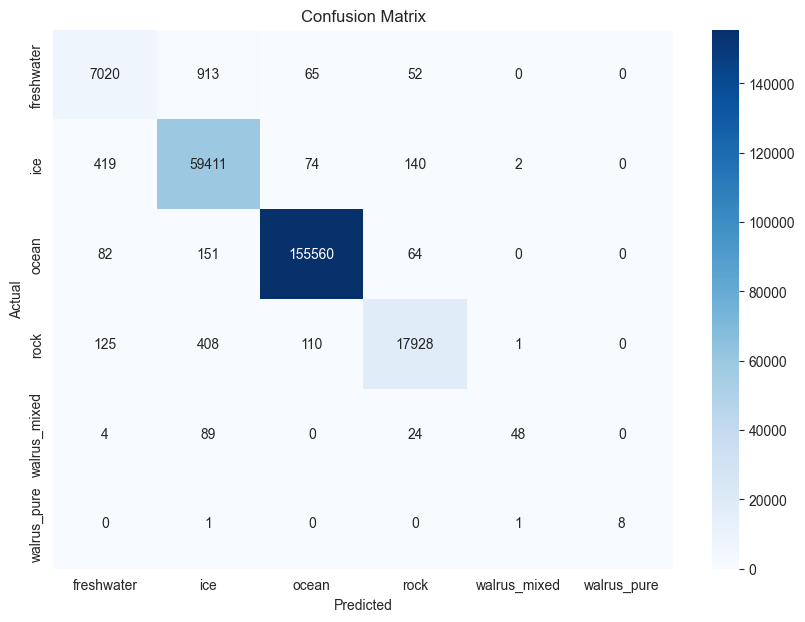

In [63]:
# Evaluate the model
y_pred = model.predict(X_test)

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Cohen's Kappa: {kappa}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [68]:
# Function to predict classes for a given image with constraints
def predict_image_with_constraints(image_path, model, walrus_near_ocean_dist=5, min_ocean_pixels=5, min_walrus_group_size=10):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        predicted_image = predictions.reshape((src.height, src.width))

    # Group walrus pixels
    walrus_pixels = np.isin(predicted_image, [le.transform(['walrus_pure'])[0], le.transform(['walrus_mixed'])[0]])
    ocean_pixels = predicted_image == le.transform(['ocean'])[0]

    # Ensure walrus pixels are near ocean pixels
    for i in range(walrus_near_ocean_dist, predicted_image.shape[0] - walrus_near_ocean_dist):
        for j in range(walrus_near_ocean_dist, predicted_image.shape[1] - walrus_near_ocean_dist):
            if walrus_pixels[i, j] and not np.any(ocean_pixels[i-walrus_near_ocean_dist:i+walrus_near_ocean_dist+1, j-walrus_near_ocean_dist:j+walrus_near_ocean_dist+1]):
                predicted_image[i, j] = le.transform(['ocean'])[0]

    # Enforce a minimum number of ocean pixels in a group
    ocean_labels, num_features = ndimage.label(ocean_pixels)
    sizes = ndimage.sum(ocean_pixels, ocean_labels, range(num_features + 1))
    mask_size = sizes < min_ocean_pixels
    remove_pixel = mask_size[ocean_labels]
    predicted_image[remove_pixel] = le.transform(['rock'])[0]

    # Enforce a minimum walrus group size
    walrus_labels, num_features = ndimage.label(walrus_pixels)
    sizes = ndimage.sum(walrus_pixels, walrus_labels, range(num_features + 1))
    mask_size = sizes < min_walrus_group_size
    remove_pixel = mask_size[walrus_labels]
    predicted_image[remove_pixel] = le.transform(['ocean'])[0]

    return predicted_image

predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    predicted_images[image_path] = predict_image_with_constraints(image_path, model)

Labels present in buch_20230714_image.tif: ['ocean', 'rock']


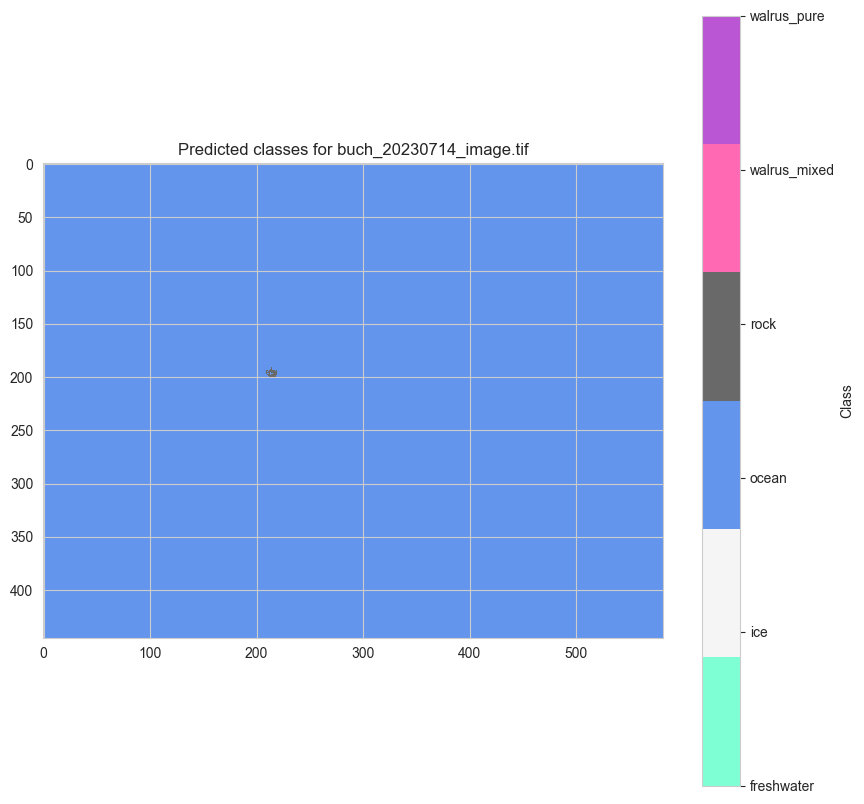

Labels present in buch_20230720_image.tif: ['ocean', 'rock']


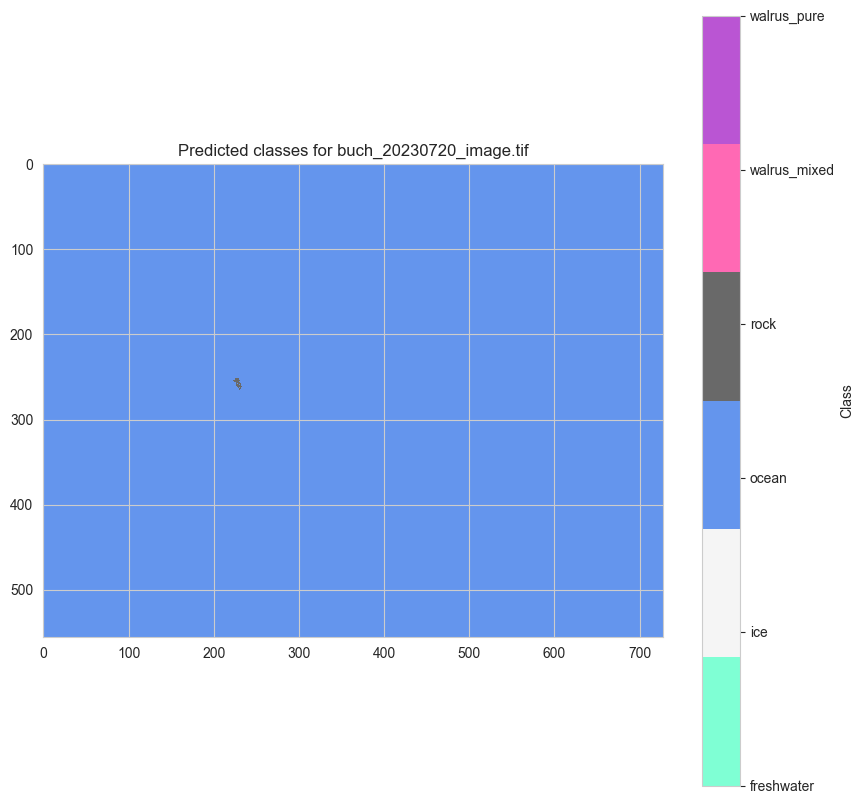

Labels present in buch_20230731_image.tif: ['ocean', 'rock']


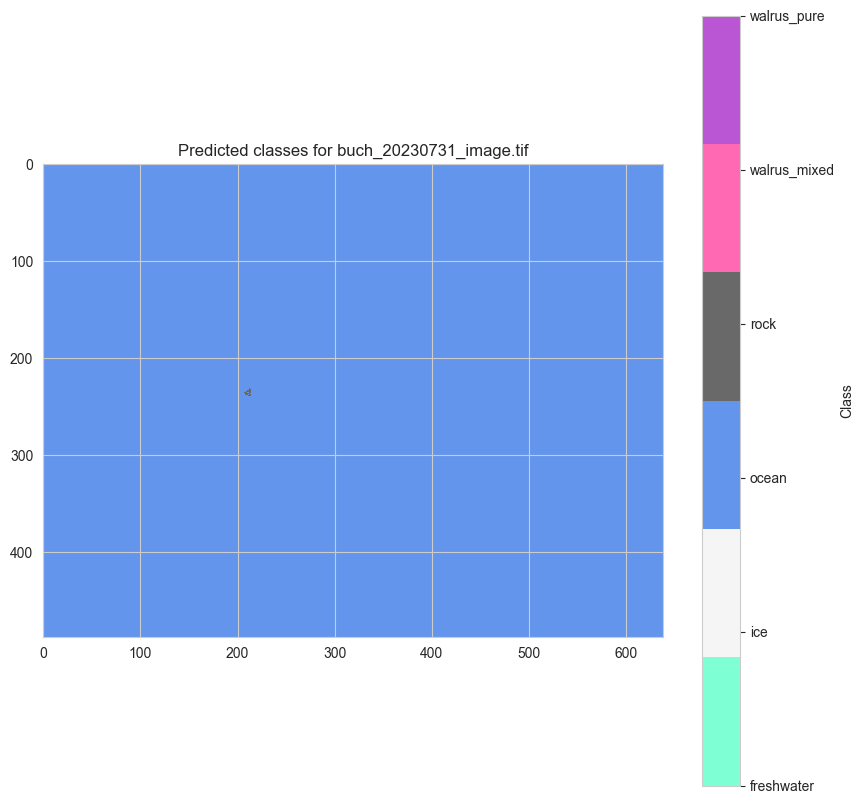

Labels present in buch_20230923_image.tif: ['ocean']


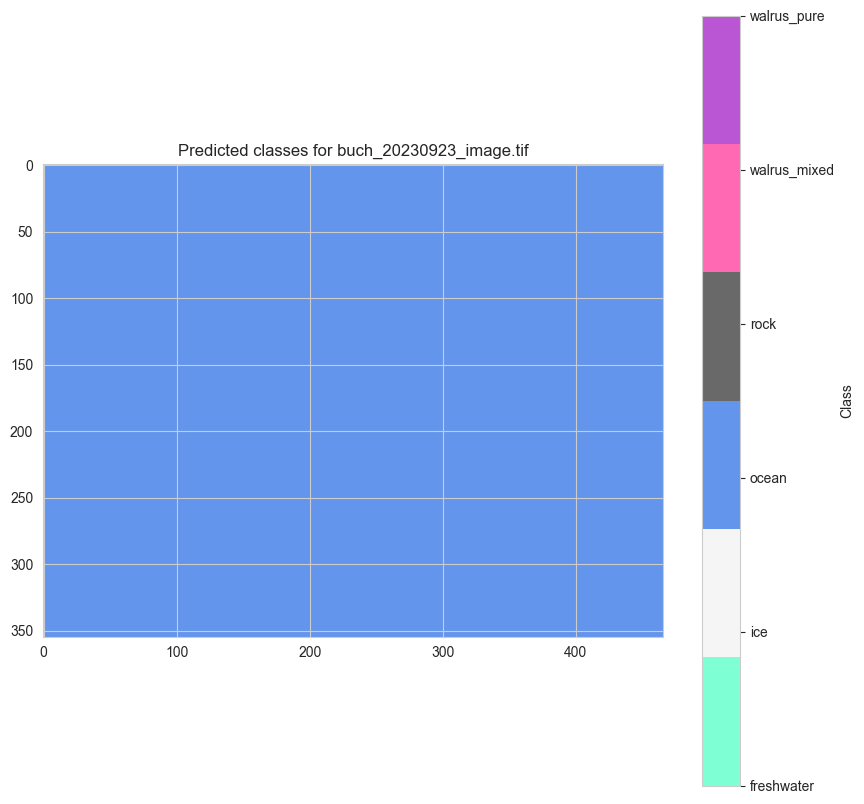

Labels present in moff_20230717_image.tif: ['ocean', 'rock']


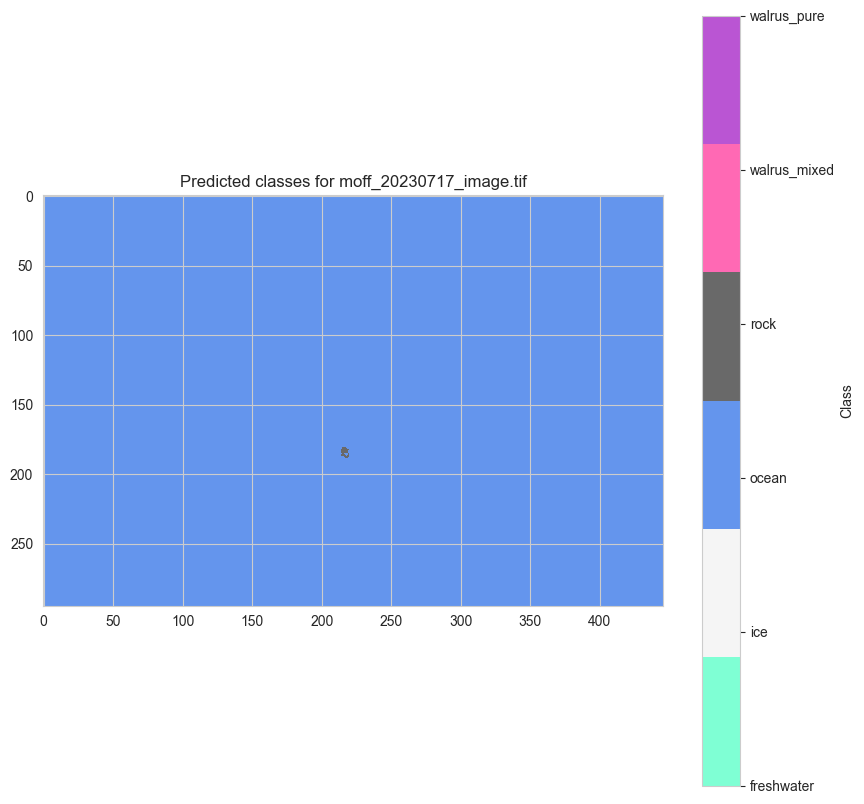

Labels present in pal_20230714_image.tif: ['ocean', 'rock']


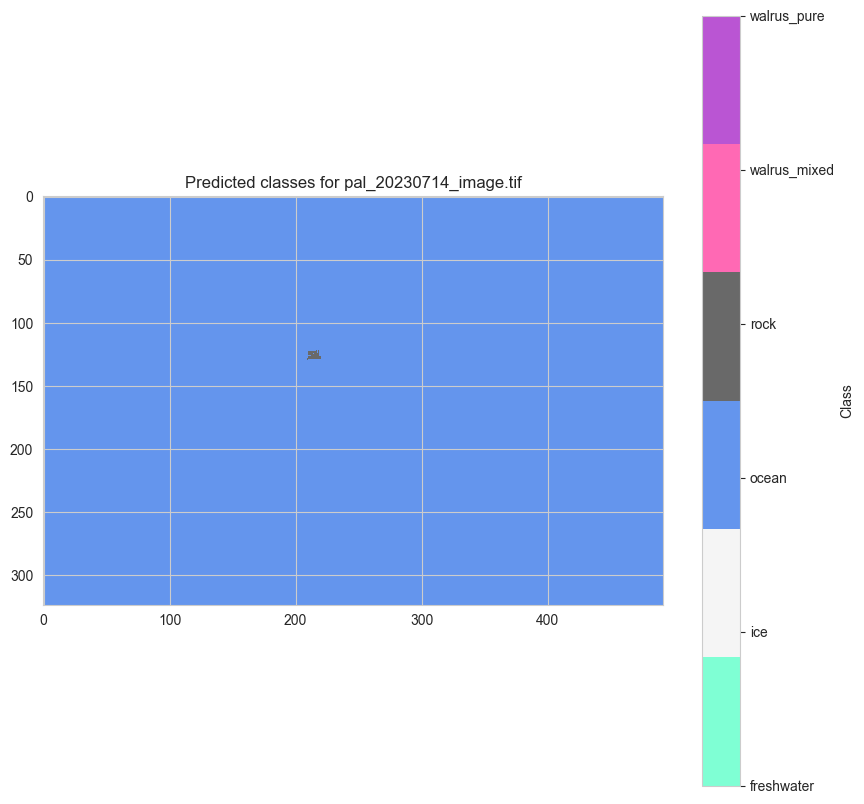

Labels present in pal_20230720_image.tif: ['ocean', 'rock']


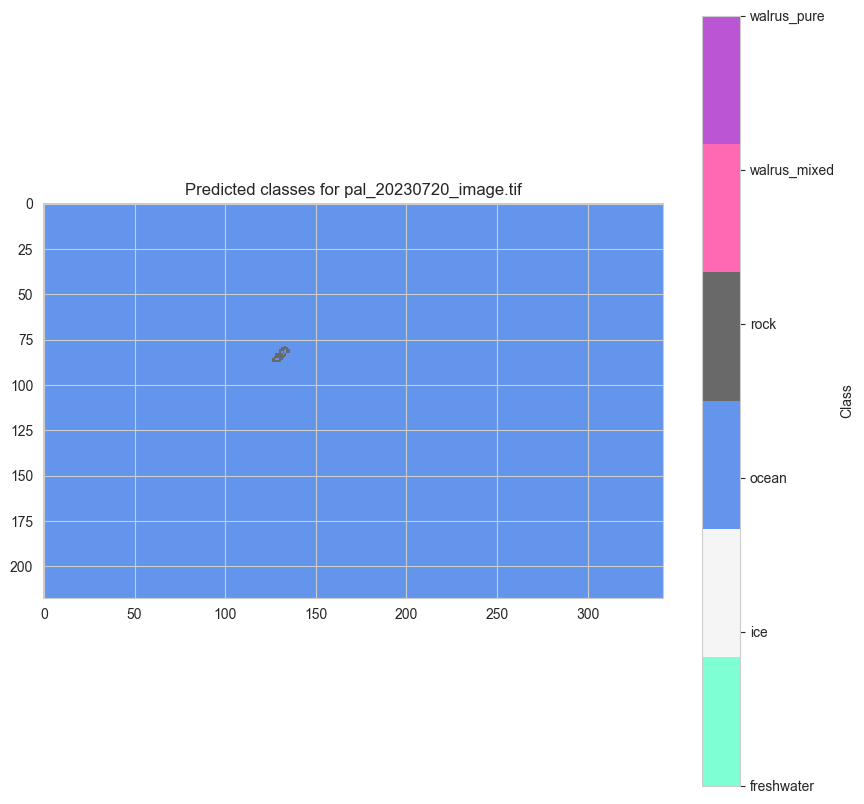

Labels present in pal_20230726_image.tif: ['ocean', 'rock']


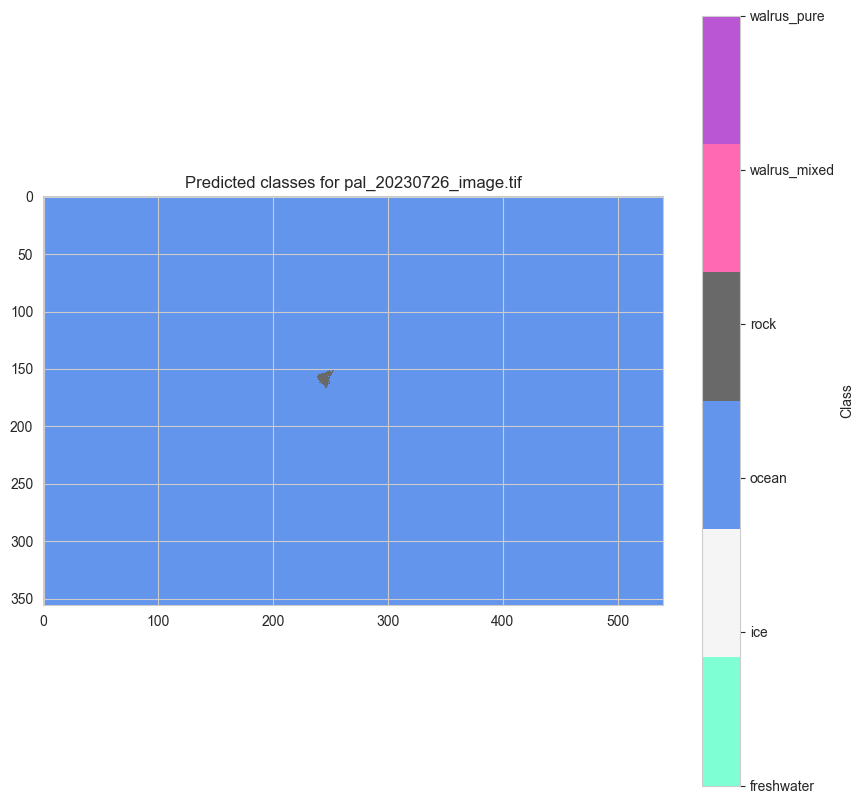

Labels present in sars_20230714_image.tif: ['ocean', 'rock']


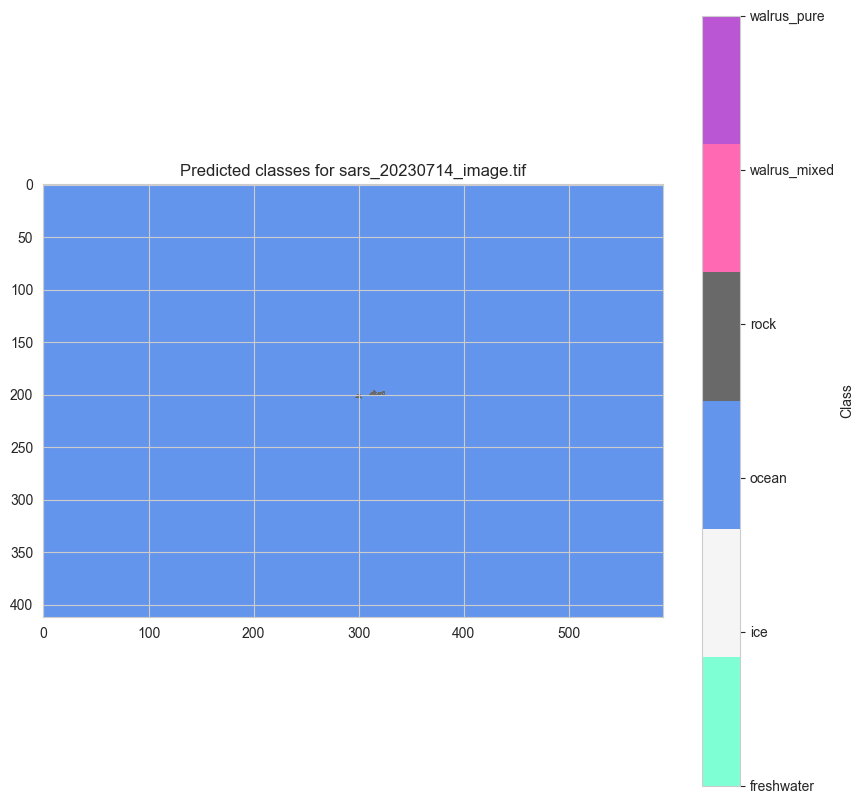

Labels present in sars_20230803_image.tif: ['ocean', 'rock']


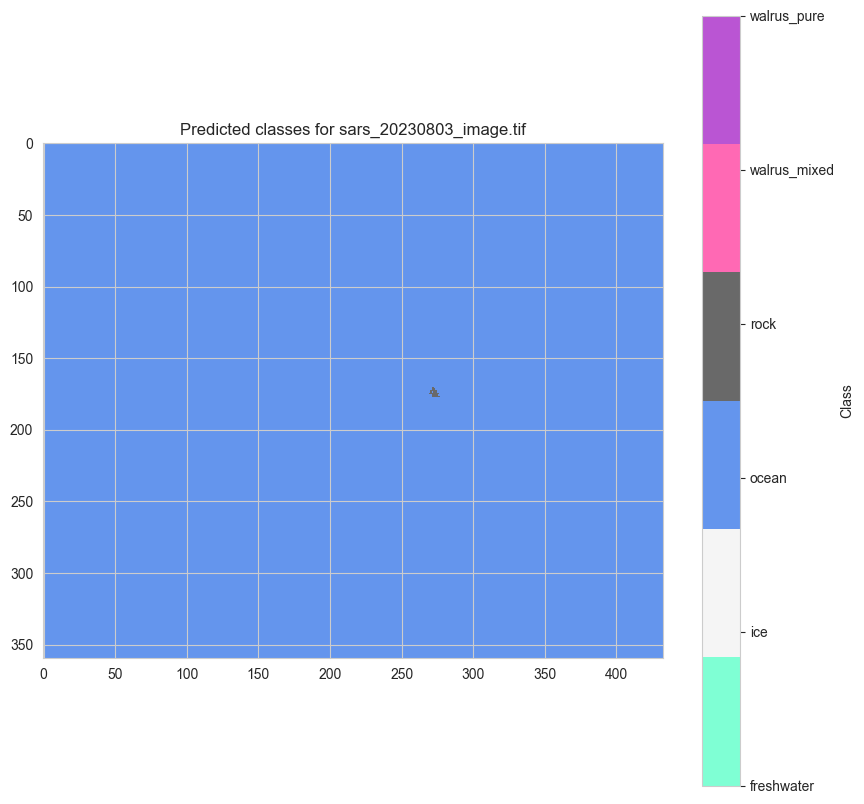

Labels present in tor_20230801_image.tif: ['ocean', 'rock']


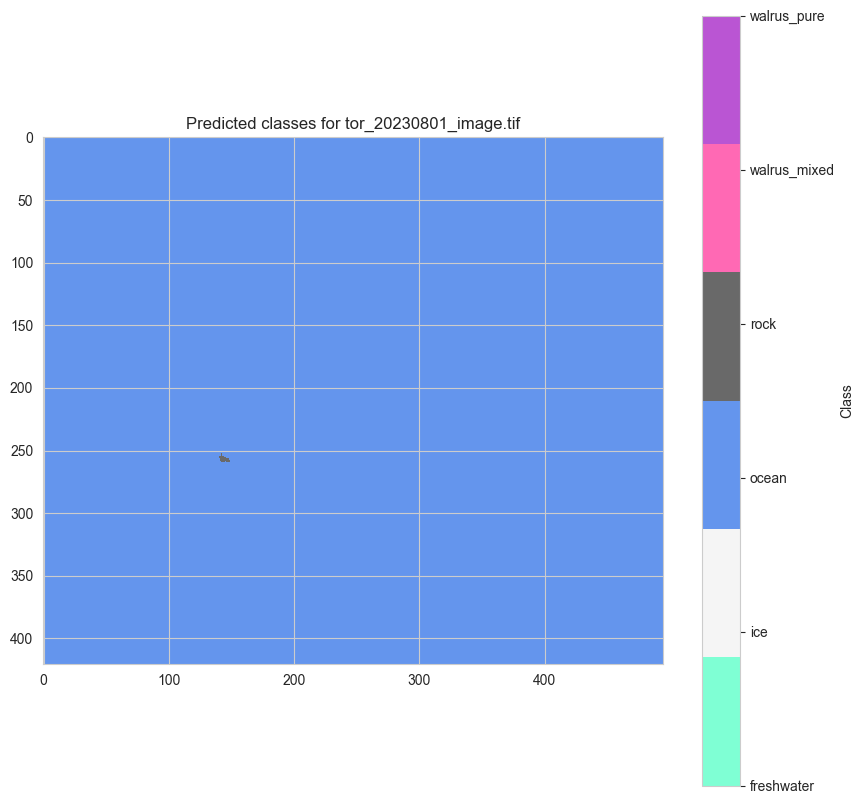

Labels present in tor_20230824_image.tif: ['ocean', 'rock']


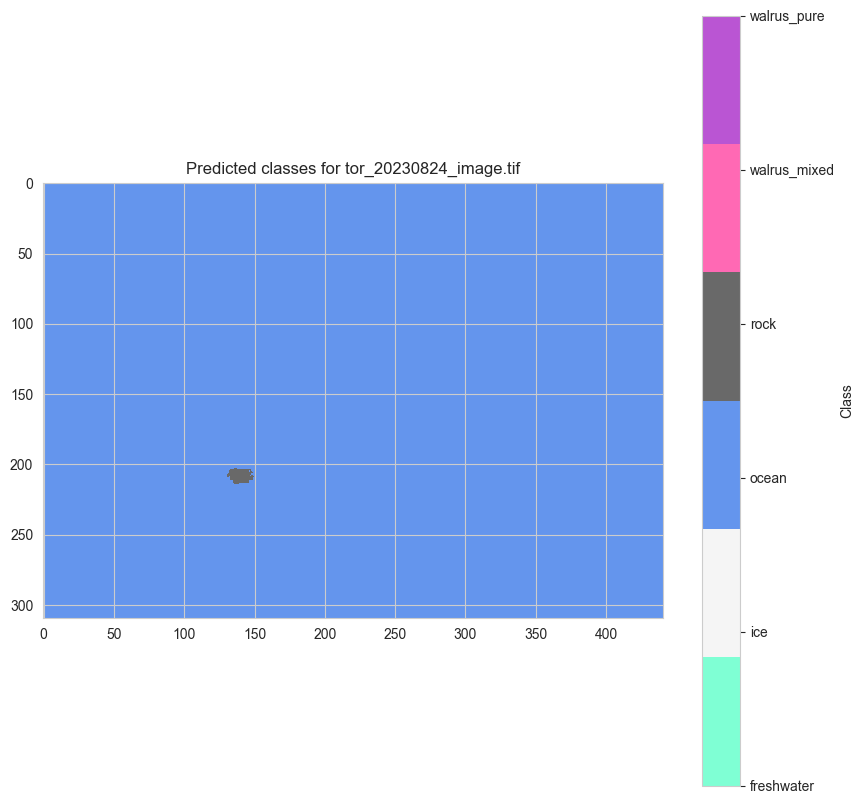

Labels present in tor_20230901_image.tif: ['ocean', 'rock']


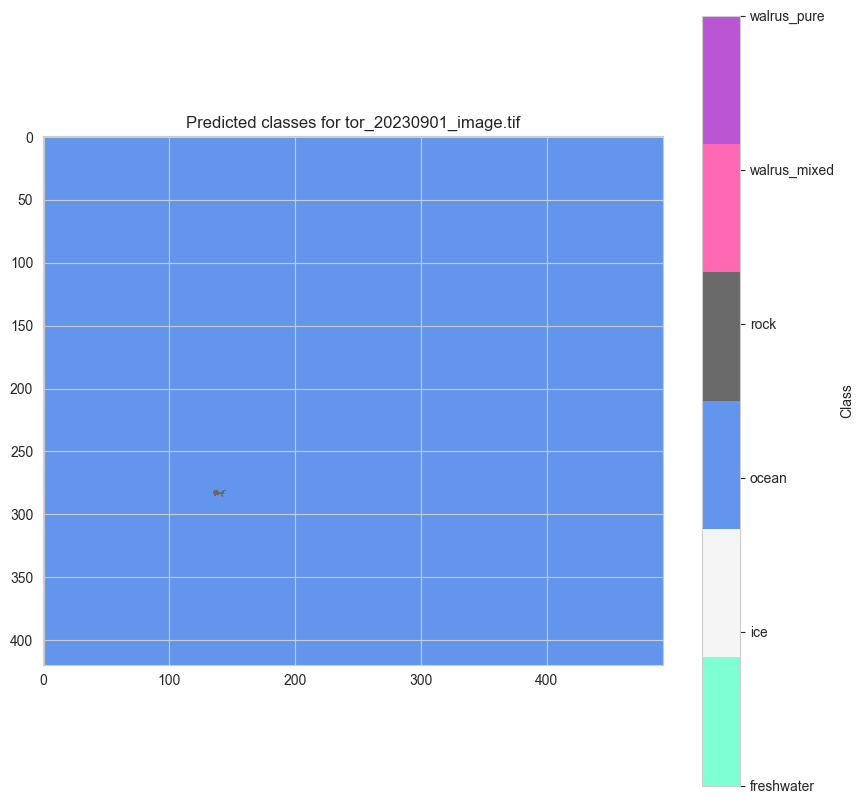

Labels present in tor_20230902_image.tif: ['ocean', 'rock']


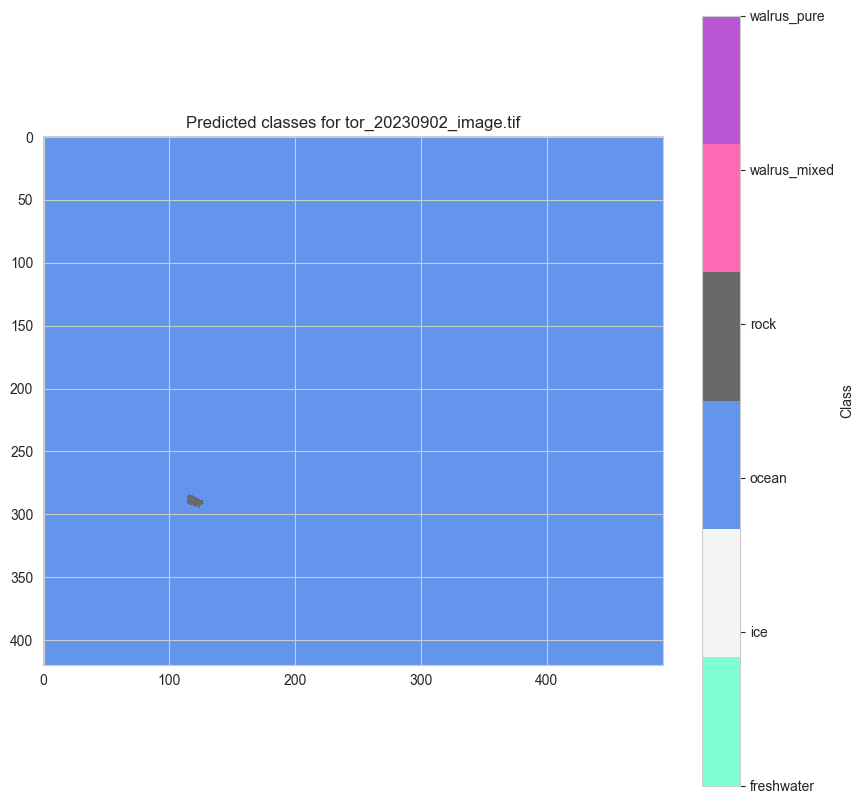

Labels present in buch_20230825_image.tif: ['ocean']


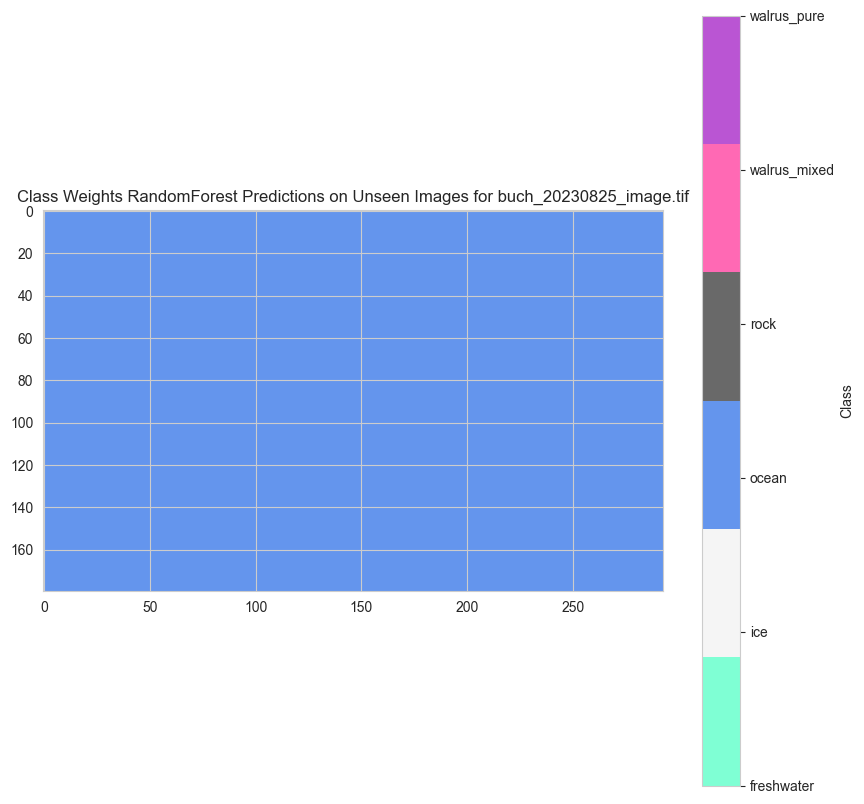

Labels present in buch_20230901_image.tif: ['ocean']


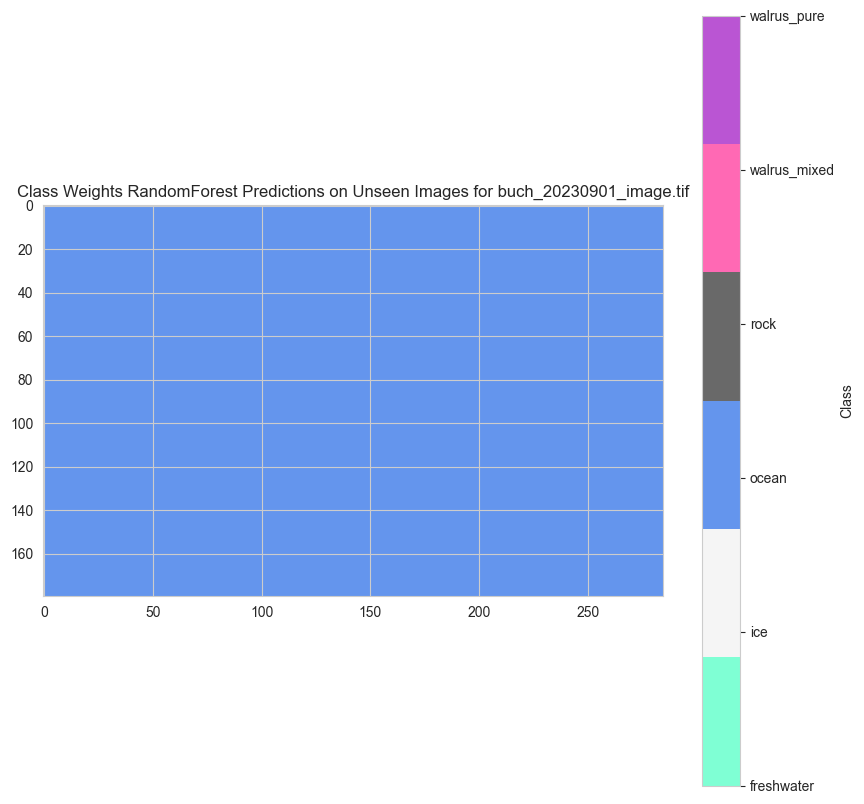

Labels present in pal_20230817_image.tif: ['ocean']


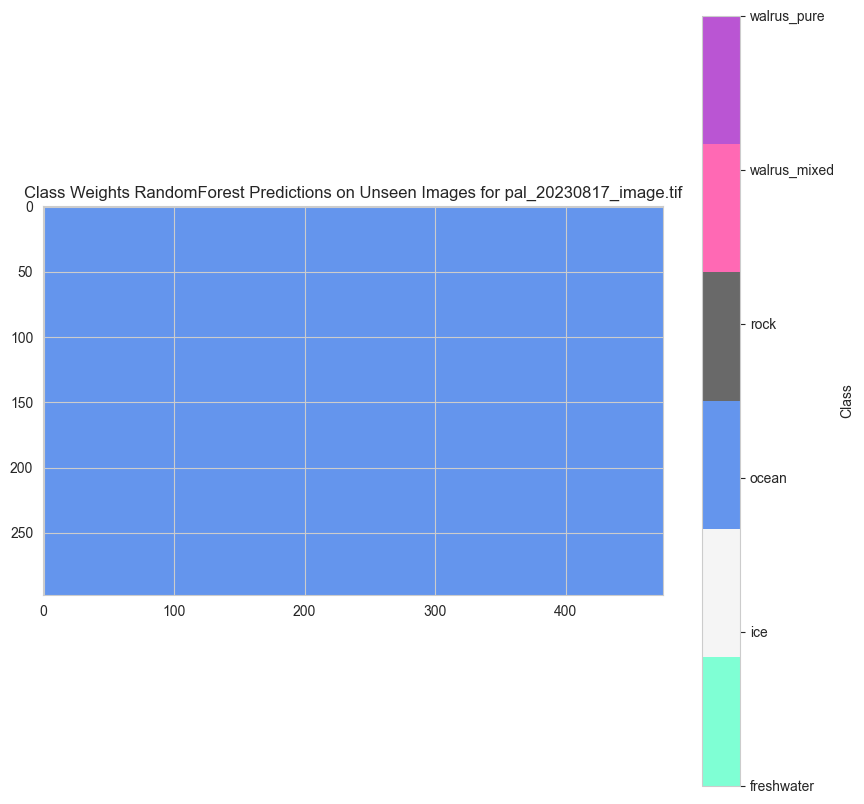

Labels present in pal_20230902_image.tif: ['ocean']


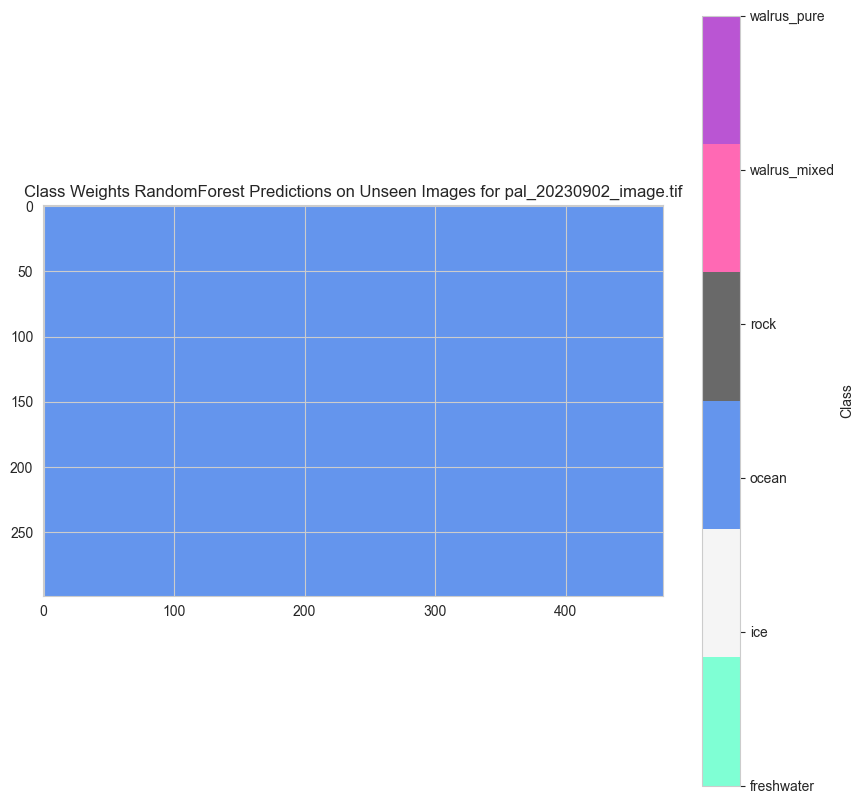

Labels present in sars_20230719_image.tif: ['ocean']


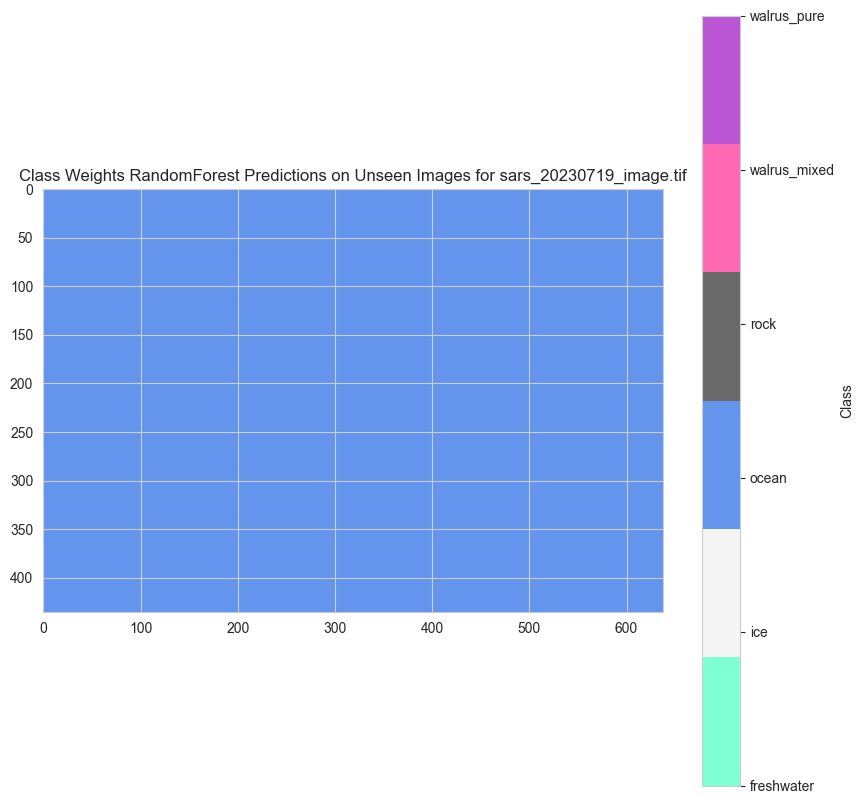

Labels present in sars_20230726.tif: ['ocean']


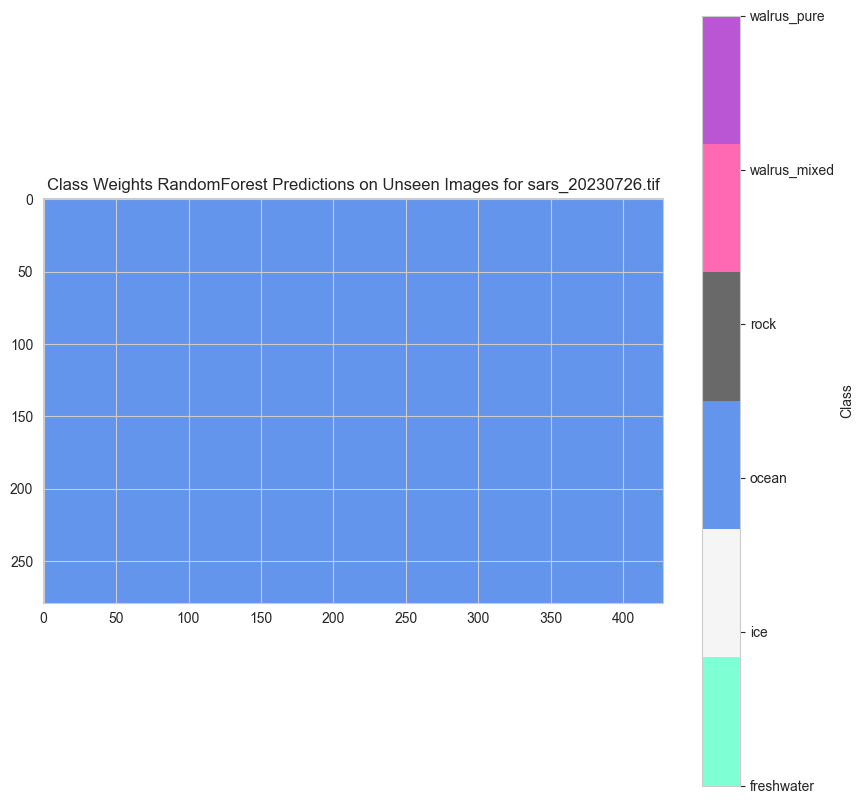

Labels present in sars_20230808_image.tif: ['ocean']


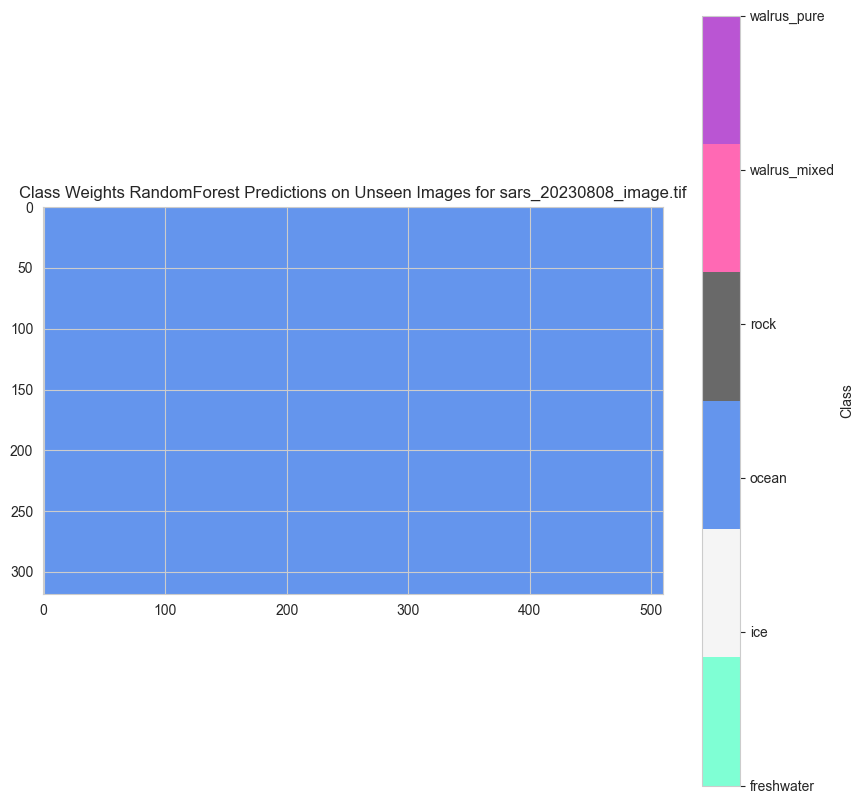

Labels present in tor_20230714_image.tif: ['ocean']


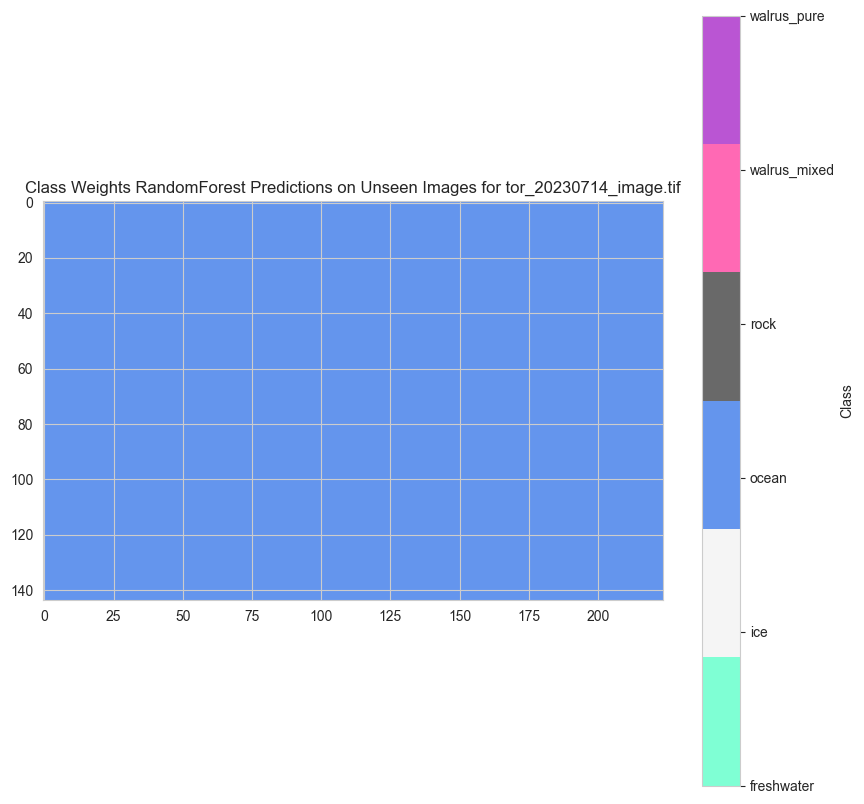

Labels present in tor_20230717_image.tif: ['ocean']


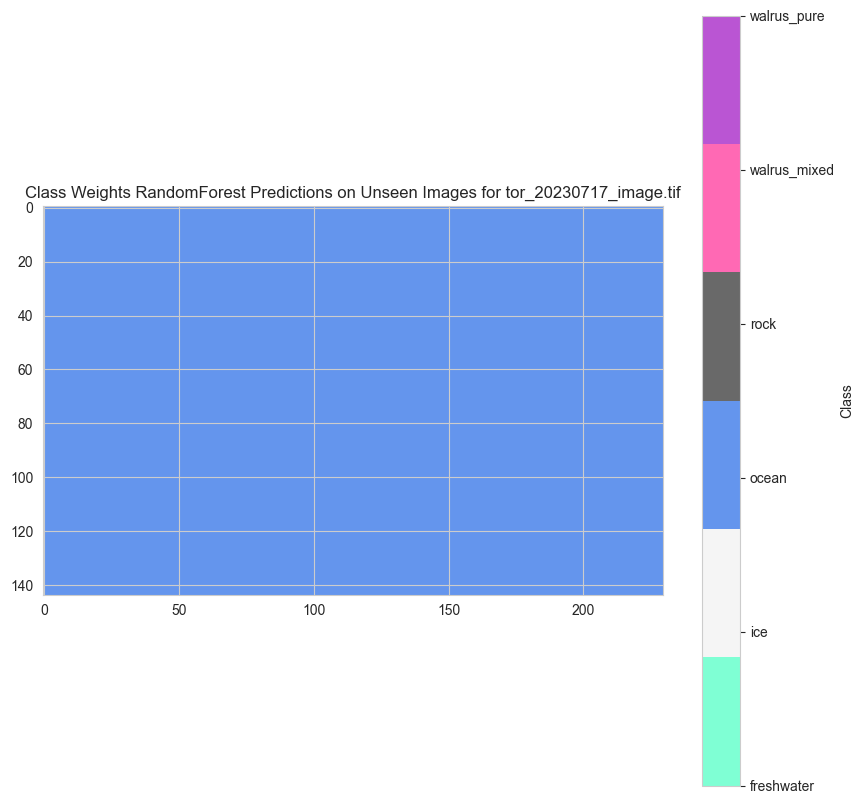

Labels present in tor_20230803_image.tif: ['ocean']


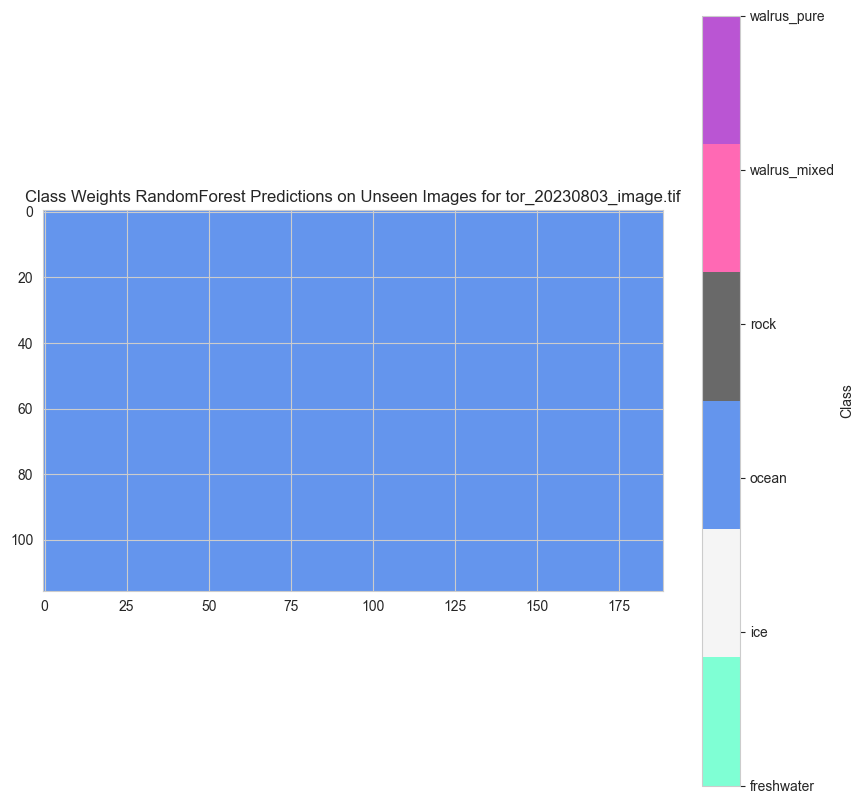

Labels present in tor_20230825_image.tif: ['ocean']


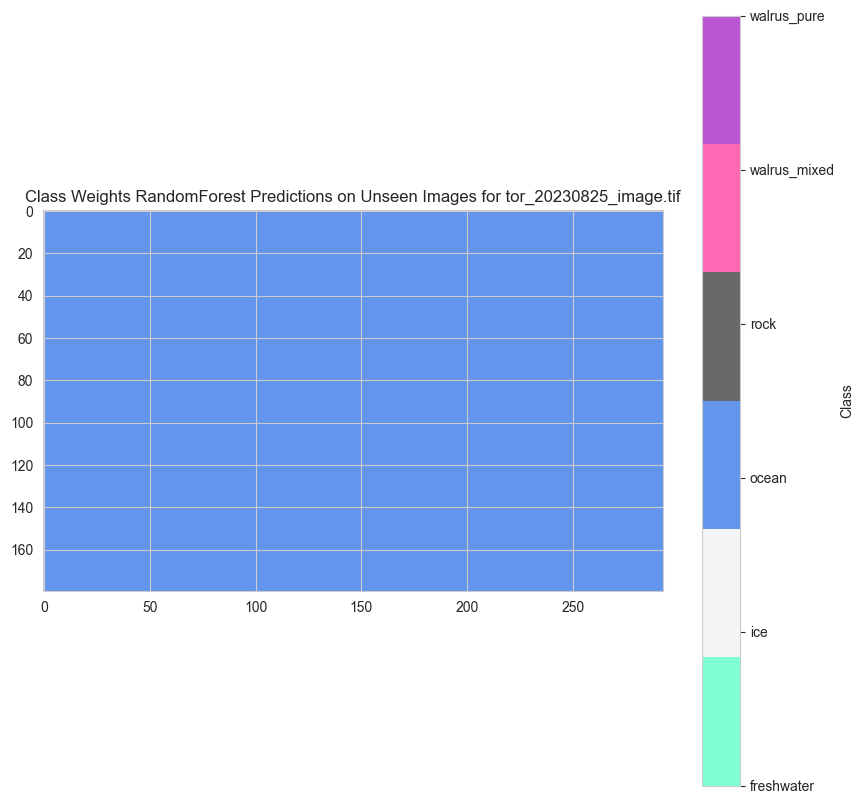

Labels present in tor_20230910_image.tif: ['ocean']


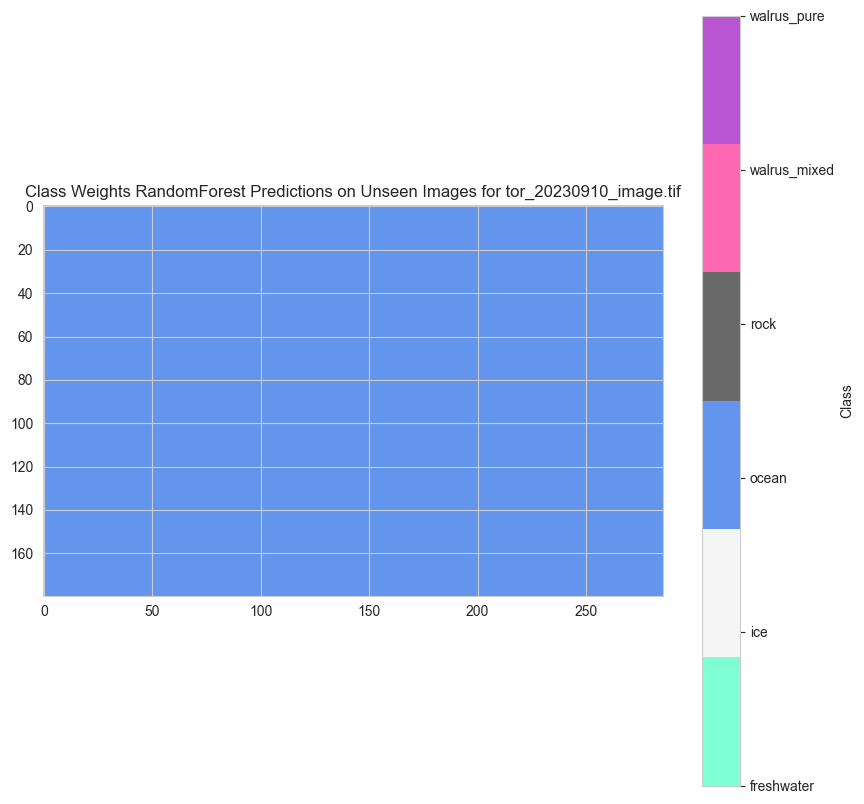

In [69]:
# Define a color map for the labels
label_colors = {
    'ice': 'whitesmoke',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'freshwater': 'aquamarine',
    'walrus_pure': 'mediumorchid',
    'walrus_mixed': 'hotpink'
}

# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)

    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels

    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")

    plt.show()

# Function to plot predictions
def plot_predictions(predicted_images, title):
    for image_path, predicted_image in predicted_images.items():
        unique_labels = np.unique(predicted_image)
        plt.figure(figsize=(10, 10))
        plt.title(f"{title} for {os.path.basename(image_path)}")
        plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)

        cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
        cbar.ax.set_yticklabels(le.classes_)

        present_labels = [le.classes_[i] for i in unique_labels]
        print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
        plt.show()

# Predict and plot results for unseen images
predicted_images_unseen_rf = {}
for image_path in unlabeled_image_paths:
    predicted_images_unseen_rf[image_path] = predict_image_with_constraints(image_path, model)

plot_predictions(predicted_images_unseen_rf, "Class Weights RandomForest Predictions on Unseen Images")


In [56]:
import os
import re
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import joblib
from rasterio.mask import geometry_mask
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from scipy.ndimage import binary_dilation, label

In [57]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    shapefile_path = matching_shapefiles[0]
    file_pairs[image_path] = shapefile_path

# Function to extract features and labels
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    img_name = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']

        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
            img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

features = []
labels = []
image_name = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)
    image_name.append(img_name)

features = np.vstack(features)
labels = np.hstack(labels)
image_name = np.hstack(image_name)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({'Coast_blue': features[:, 0],
                        'Blue': features[:, 1],
                        'Green1': features[:, 2],
                        'Green': features[:, 3],
                        'Yellow': features[:, 4],
                        'Red': features[:, 5],
                        'Red_edge': features[:, 6],
                        'NIR': features[:, 7],
                        'labels': labels,
                        'encoded_labels': encoded_labels,
                        'image_name': image_name})

No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif


In [ ]:
# Ensure every class is present in the training data
def ensure_all_classes_in_training(dataset, labels_column):
    unique_labels = dataset[labels_column].unique()
    required_indices = []
    for label in unique_labels:
        label_indices = dataset[dataset[labels_column] == label].index
        if len(label_indices) > 0:
            required_indices.append(label_indices[0])
    return required_indices

required_indices = ensure_all_classes_in_training(dataset, 'encoded_labels')
training_indices = dataset.index.isin(required_indices) | dataset['image_name'].isin(dataset['image_name'].unique())

# Ensure all walrus pixels are included
walrus_indices = dataset[dataset['labels'].isin(['walrus_pure', 'walrus_mixed'])].index
training_indices = training_indices | dataset.index.isin(walrus_indices)

# Ensure at least one image from each island is included
islands = dataset['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
training_images = set(dataset['image_name'][training_indices])
for island in islands:
    island_images = [img for img in image_paths if extract_island_and_date(os.path.basename(img))[0] == island]
    if not any(img in training_images for img in island_images):
        training_indices |= dataset['image_name'].isin(island_images[:1])

# Split the data into training and testing sets
X = dataset[['Coast_blue', 'Blue', 'Green1', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR']]
y = dataset['encoded_labels']

X_train, X_test, y_train, y_test = train_test_split(X[training_indices], y[training_indices], test_size=0.2, random_state=42, stratify=y[training_indices])

# Define class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(encoded_labels), y=encoded_labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Train the cost-sensitive RandomForest model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight_dict)
model.fit(X_train, y_train)

# Save the model
model_filename = "RF_ALL_conditions.joblib"
joblib.dump(model, model_filename)


In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
labels = np.unique(y_train)  # Ensure labels are aligned with those in the training set
print(classification_report(y_test, y_pred, labels=labels, target_names=le.inverse_transform(labels)))

# Generate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=labels)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.inverse_transform(labels), yticklabels=le.inverse_transform(labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print accuracy
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
print(f"Accuracy: {accuracy:.2f}")

In [ ]:
# Function to apply spatial rules and enforce proximity to ocean
def apply_spatial_rules_and_proximity(predicted_image, min_cluster_size=15, max_distance=25, min_ocean_freshwater_size=180):
    walrus_mask = (predicted_image == le.transform(['walrus_pure'])[0]) | (predicted_image == le.transform(['walrus_mixed'])[0])
    ocean_mask = (predicted_image == le.transform(['ocean'])[0])
    freshwater_mask = (predicted_image == le.transform(['freshwater'])[0])

    # Dilate ocean pixels to consider proximity
    dilated_ocean = binary_dilation(ocean_mask, iterations=max_distance)
    
    # Apply spatial rules
    walrus_clusters, num_walrus_features = label(walrus_mask)
    ocean_clusters, num_ocean_features = label(ocean_mask)
    freshwater_clusters, num_freshwater_features = label(freshwater_mask)
    
    valid_walrus_clusters = np.zeros_like(walrus_mask)
    valid_ocean_clusters = np.zeros_like(ocean_mask)
    valid_freshwater_clusters = np.zeros_like(freshwater_mask)
    
    for cluster_num in range(1, num_walrus_features + 1):
        cluster_pixels = walrus_clusters == cluster_num
        if np.sum(cluster_pixels) >= min_cluster_size and np.any(dilated_ocean & cluster_pixels):
            valid_walrus_clusters[cluster_pixels] = 1
    
    for cluster_num in range(1, num_ocean_features + 1):
        cluster_pixels = ocean_clusters == cluster_num
        if np.sum(cluster_pixels) >= min_ocean_freshwater_size:
            valid_ocean_clusters[cluster_pixels] = 1
            
    for cluster_num in range(1, num_freshwater_features + 1):
        cluster_pixels = freshwater_clusters == cluster_num
        if np.sum(cluster_pixels) >= min_ocean_freshwater_size:
            valid_freshwater_clusters[cluster_pixels] = 1
    
    final_mask = (valid_walrus_clusters == 1) | (valid_ocean_clusters == 1) | (valid_freshwater_clusters == 1)
    return final_mask

# Function to predict classes for a given image
def predict_image(image_path, model, min_cluster_size, max_distance, min_ocean_freshwater_size):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        predicted_image = predictions.reshape((src.height, src.width))
        final_mask = apply_spatial_rules_and_proximity(predicted_image, min_cluster_size, max_distance, min_ocean_freshwater_size)
        return final_mask

# Parameters for spatial rules
min_walrus_cluster_size = 15
max_proximity_distance = 25
min_ocean_freshwater_cluster_size = 180

# Predict on the training images
predicted_images_train = {}
for image_path, shapefile_path in file_pairs.items():
    predicted_images_train[image_path] = predict_image(image_path, model, min_walrus_cluster_size, max_proximity_distance, min_ocean_freshwater_cluster_size)

# Predict on the unlabeled images
predicted_images_unlabeled = {}
for image_path in unlabeled_image_paths:
    predicted_images_unlabeled[image_path] = predict_image(image_path, model, min_walrus_cluster_size, max_proximity_distance, min_ocean_freshwater_cluster_size)

In [ ]:
# Define a color map for the labels
label_colors = {
    'ice': 'whitesmoke',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'freshwater': 'aquamarine',
    'walrus_pure': 'mediumorchid',
    'walrus_mixed': 'hotpink'
}

In [ ]:
# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Function to plot the predicted images
def plot_predicted_images(predicted_images, title_prefix):
    for image_path, predicted_image in predicted_images.items():
        unique_labels = np.unique(predicted_image)
        plt.figure(figsize=(10, 10))
        plt.title(f"{title_prefix} for {os.path.basename(image_path)}")
        plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)

        # Create a color bar with fixed labels
        cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
        cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels

        # Highlight the labels present in the current image
        present_labels = [le.classes_[i] for i in unique_labels]
        print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")

        plt.show()

# Plot predictions for training images
plot_predicted_images(predicted_images_train, "Predicted classes for training image")

# Plot predictions for unlabeled images
plot_predicted_images(predicted_images_unlabeled, "Predicted classes for unlabeled image")

No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif
[[1187  980 1269 ... 1329 1416 1650]
 [1148  912 1212 ... 1240 1297 1612]
 [1131  856 1162 ... 1181 1355 1510]
 ...
 [1730 1870 1929 ... 2091 2276 2647]
 [1634 1851 1879 ... 2053 2281 2634]
 [1720 1904 1905 ... 2135 2316 2654]] ['walrus_mixed' 'walrus_mixed' 'walrus_mixed' ... 'freshwater'
 'freshwater' 'freshwater'] ['C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 ...
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_ima

Training class distribution:
2    623430
1    240185
3     74285
0     32201
4       657
5        38
Name: count, dtype: int64


['RF_ALL_conditions.joblib']

              precision    recall  f1-score   support

  freshwater       0.92      0.86      0.89      8050
         ice       0.97      0.99      0.98     60046
       ocean       1.00      1.00      1.00    155858
        rock       0.98      0.97      0.97     18571
walrus_mixed       0.98      0.25      0.40       165
 walrus_pure       0.86      0.60      0.71        10

    accuracy                           0.99    242700
   macro avg       0.95      0.78      0.83    242700
weighted avg       0.99      0.99      0.99    242700


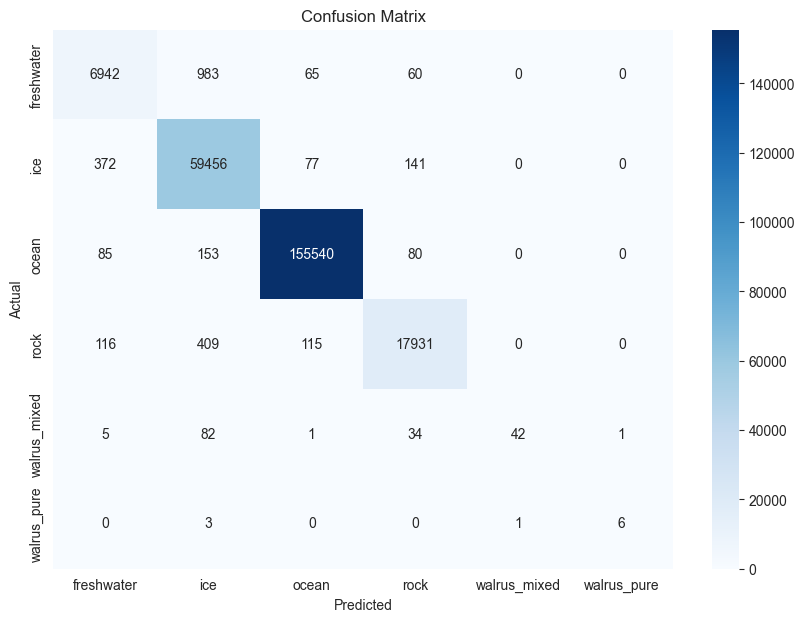

Accuracy: 0.99


C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fit

In [45]:
import os
import re
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import joblib
from rasterio.mask import geometry_mask
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from scipy.ndimage import binary_dilation
from scipy.ndimage import label

In [46]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    shapefile_path = matching_shapefiles[0]
    file_pairs[image_path] = shapefile_path

# Function to extract features and labels
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    img_name = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']

        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
            img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

features = []
labels = []
image_name = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)
    image_name.append(img_name)

features = np.vstack(features)
labels = np.hstack(labels)
image_name = np.hstack(image_name)
print(features, labels, image_name)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({
    'Coast_blue': features[:, 0],
    'Blue': features[:, 1],
    'Green1': features[:, 2],
    'Green': features[:, 3],
    'Yellow': features[:, 4],
    'Red': features[:, 5],
    'Red_edge': features[:, 6],
    'NIR': features[:, 7],
    'labels': labels,
    'encoded_labels': encoded_labels,
    'image_name': image_name
})

# Ensure every class is present in the training data
def ensure_all_classes_in_training(dataset, labels_column):
    unique_labels = dataset[labels_column].unique()
    required_indices = []
    for label in unique_labels:
        label_indices = dataset[dataset[labels_column] == label].index
        if len(label_indices) > 0:
            required_indices.append(label_indices[0])
    return required_indices

required_indices = ensure_all_classes_in_training(dataset, 'encoded_labels')
training_indices = dataset.index.isin(required_indices) | dataset['image_name'].isin(dataset['image_name'].unique())

# Ensure all walrus pixels are included
walrus_indices = dataset[dataset['labels'].isin(['walrus_pure', 'walrus_mixed'])].index
training_indices = training_indices | dataset.index.isin(walrus_indices)

# Ensure at least one image from each island is included
islands = dataset['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
training_images = set(dataset['image_name'][training_indices])
for island in islands:
    island_images = [img for img in image_paths if extract_island_and_date(os.path.basename(img))[0] == island]
    if not any(img in training_images for img in island_images):
        training_indices |= dataset['image_name'].isin(island_images[:1])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop(columns=['labels', 'encoded_labels', 'image_name']),
    encoded_labels,
    test_size=0.2,
    stratify=encoded_labels,
    random_state=42
)

# Print number of pixels in each class for the training data
print("Training class distribution:")
print(pd.Series(y_train).value_counts())

# Define class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif
[[1187  980 1269 ... 1329 1416 1650]
 [1148  912 1212 ... 1240 1297 1612]
 [1131  856 1162 ... 1181 1355 1510]
 ...
 [1730 1870 1929 ... 2091 2276 2647]
 [1634 1851 1879 ... 2053 2281 2634]
 [1720 1904 1905 ... 2135 2316 2654]] ['walrus_mixed' 'walrus_mixed' 'walrus_mixed' ... 'freshwater'
 'freshwater' 'freshwater'] ['C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 ...
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_ima

In [47]:
# Train the cost-sensitive RandomForest model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight_dict)
model.fit(X_train, y_train)

# Save the model
model_filename = "RF_ALL_conditions.joblib"
joblib.dump(model, model_filename)

['RF_ALL_conditions.joblib']

              precision    recall  f1-score   support

  freshwater       0.92      0.86      0.89      8050
         ice       0.97      0.99      0.98     60046
       ocean       1.00      1.00      1.00    155858
        rock       0.98      0.97      0.97     18571
walrus_mixed       0.98      0.25      0.40       165
 walrus_pure       0.86      0.60      0.71        10

    accuracy                           0.99    242700
   macro avg       0.95      0.78      0.83    242700
weighted avg       0.99      0.99      0.99    242700


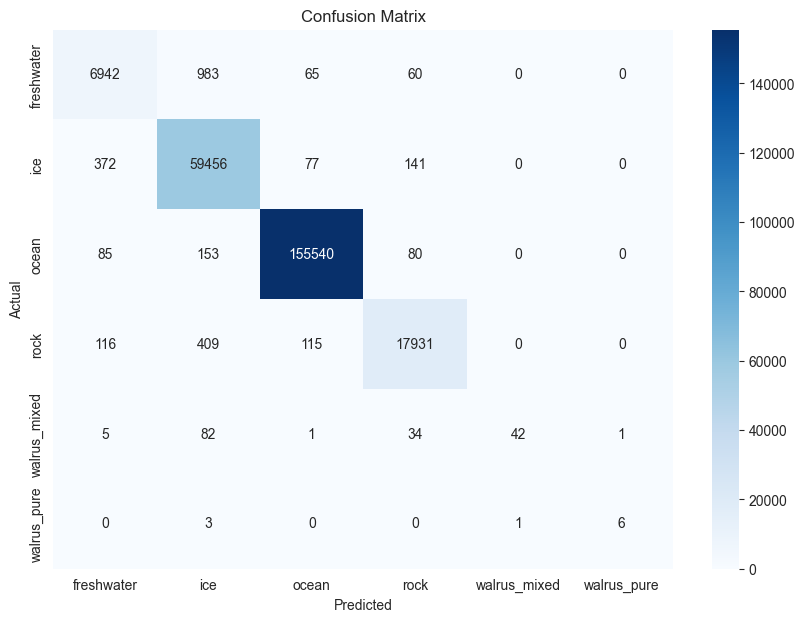

Accuracy: 0.99


In [48]:
# Evaluate the model
y_pred = model.predict(X_test)
labels = np.unique(y_train)  # Ensure labels are aligned with those in the training set
print(classification_report(y_test, y_pred, labels=labels, target_names=le.inverse_transform(labels)))

# Generate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=labels)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.inverse_transform(labels), yticklabels=le.inverse_transform(labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print accuracy
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
print(f"Accuracy: {accuracy:.2f}")

In [49]:
# Function to apply spatial rules and enforce proximity to ocean
def apply_spatial_rules_and_proximity(predicted_image, min_cluster_size=15, max_distance=25, min_ocean_freshwater_size=180):
    walrus_mask = (predicted_image == le.transform(['walrus_pure'])[0]) | (predicted_image == le.transform(['walrus_mixed'])[0])
    ocean_mask = (predicted_image == le.transform(['ocean'])[0])
    freshwater_mask = (predicted_image == le.transform(['freshwater'])[0])

    # Dilate ocean pixels to consider proximity
    dilated_ocean = binary_dilation(ocean_mask, iterations=max_distance)
    
    # Apply spatial rules
    walrus_clusters, num_walrus_features = label(walrus_mask)
    ocean_clusters, num_ocean_features = label(ocean_mask)
    freshwater_clusters, num_freshwater_features = label(freshwater_mask)
    
    valid_walrus_clusters = np.zeros_like(walrus_mask)
    valid_ocean_clusters = np.zeros_like(ocean_mask)
    valid_freshwater_clusters = np.zeros_like(freshwater_mask)
    
    for cluster_num in range(1, num_walrus_features + 1):
        cluster_pixels = walrus_clusters == cluster_num
        if np.sum(cluster_pixels) >= min_cluster_size and np.any(dilated_ocean & cluster_pixels):
            valid_walrus_clusters[cluster_pixels] = 1
    
    for cluster_num in range(1, num_ocean_features + 1):
        cluster_pixels = ocean_clusters == cluster_num
        if np.sum(cluster_pixels) >= min_ocean_freshwater_size:
            valid_ocean_clusters[cluster_pixels] = 1
            
    for cluster_num in range(1, num_freshwater_features + 1):
        cluster_pixels = freshwater_clusters == cluster_num
        if np.sum(cluster_pixels) >= min_ocean_freshwater_size:
            valid_freshwater_clusters[cluster_pixels] = 1
    
    final_mask = (valid_walrus_clusters == 1) | (valid_ocean_clusters == 1) | (valid_freshwater_clusters == 1)
    return final_mask

# Function to predict classes for a given image
def predict_image(image_path, model, min_cluster_size, max_distance, min_ocean_freshwater_size):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        predicted_image = predictions.reshape((src.height, src.width))
        final_mask = apply_spatial_rules_and_proximity(predicted_image, min_cluster_size, max_distance, min_ocean_freshwater_size)
        return final_mask

predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, model, min_walrus_cluster_size, max_proximity_distance, min_ocean_freshwater_cluster_size)

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fit

In [ ]:
# Define a color map for the labels
# Define a color map for the labels
label_colors = {
    'ice': 'whitesmoke',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'freshwater': 'aquamarine',
    'walrus_pure': 'mediumorchid',
    'walrus_mixed': 'hotpink'
}

# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)

    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels

    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")

    plt.show()

In [ ]:
# Predict and plot results for unseen images
predicted_images_unlabeled = {}
for image_path in unlabeled_image_paths:
    predicted_images_unlabeled[image_path] = predict_image(image_path, model, min_walrus_cluster_size, max_proximity_distance, min_ocean_freshwater_cluster_size)

# Plot the predictions for unseen images
for image_path, predicted_image in predicted_images_unlabeled.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)} (unlabeled)")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)

    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels

    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)} (unlabeled): {present_labels}")

    plt.show()


In [ ]:
import os
import re
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import joblib
from rasterio.mask import geometry_mask
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from scipy.ndimage import binary_dilation
from scipy.ndimage import label

In [31]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    shapefile_path = matching_shapefiles[0]
    file_pairs[image_path] = shapefile_path

# Function to extract features and labels
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    img_name = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']

        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
            img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

features = []
labels = []
image_name = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)
    image_name.append(img_name)

features = np.vstack(features)
labels = np.hstack(labels)
image_name = np.hstack(image_name)
print(features, labels, image_name)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({
    'Coast_blue': features[:, 0],
    'Blue': features[:, 1],
    'Green1': features[:, 2],
    'Green': features[:, 3],
    'Yellow': features[:, 4],
    'Red': features[:, 5],
    'Red_edge': features[:, 6],
    'NIR': features[:, 7],
    'labels': labels,
    'encoded_labels': encoded_labels,
    'image_name': image_name
})


No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif
[[1187  980 1269 ... 1329 1416 1650]
 [1148  912 1212 ... 1240 1297 1612]
 [1131  856 1162 ... 1181 1355 1510]
 ...
 [1730 1870 1929 ... 2091 2276 2647]
 [1634 1851 1879 ... 2053 2281 2634]
 [1720 1904 1905 ... 2135 2316 2654]] ['walrus_mixed' 'walrus_mixed' 'walrus_mixed' ... 'freshwater'
 'freshwater' 'freshwater'] ['C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 ...
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_ima

In [32]:
# Ensure every class is present in the training data
def ensure_all_classes_in_training(dataset, labels_column):
    unique_labels = dataset[labels_column].unique()
    required_indices = []
    for label in unique_labels:
        label_indices = dataset[dataset[labels_column] == label].index
        if len(label_indices) > 0:
            required_indices.append(label_indices[0])
    return required_indices

required_indices = ensure_all_classes_in_training(dataset, 'encoded_labels')
training_indices = dataset.index.isin(required_indices) | dataset['image_name'].isin(dataset['image_name'].unique())

# Ensure all walrus pixels are included
walrus_indices = dataset[dataset['labels'].isin(['walrus_pure', 'walrus_mixed'])].index
training_indices = training_indices | dataset.index.isin(walrus_indices)

# Ensure at least one image from each island is included
islands = dataset['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
training_images = set(dataset['image_name'][training_indices])
for island in islands:
    island_images = [img for img in image_paths if extract_island_and_date(os.path.basename(img))[0] == island]
    if not any(img in training_images for img in island_images):
        training_indices |= dataset['image_name'].isin(island_images[:1])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop(columns=['labels', 'encoded_labels', 'image_name']),
    encoded_labels,
    test_size=0.2,
    stratify=encoded_labels,
    random_state=42
)

# Print number of pixels in each class for the training data
print("Training class distribution:")
print(pd.Series(y_train).value_counts())

Training class distribution:
2    623430
1    240185
3     74285
0     32201
4       657
5        38
Name: count, dtype: int64


In [33]:
# Define class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Train the cost-sensitive RandomForest model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight_dict)
model.fit(X_train, y_train)

# Save the model
model_filename = "RF_ALL_conditions.joblib"
joblib.dump(model, model_filename)

['RF_ALL_conditions.joblib']

              precision    recall  f1-score   support

  freshwater       0.92      0.86      0.89      8050
         ice       0.97      0.99      0.98     60046
       ocean       1.00      1.00      1.00    155858
        rock       0.98      0.97      0.97     18571
walrus_mixed       0.98      0.25      0.40       165
 walrus_pure       0.86      0.60      0.71        10

    accuracy                           0.99    242700
   macro avg       0.95      0.78      0.83    242700
weighted avg       0.99      0.99      0.99    242700


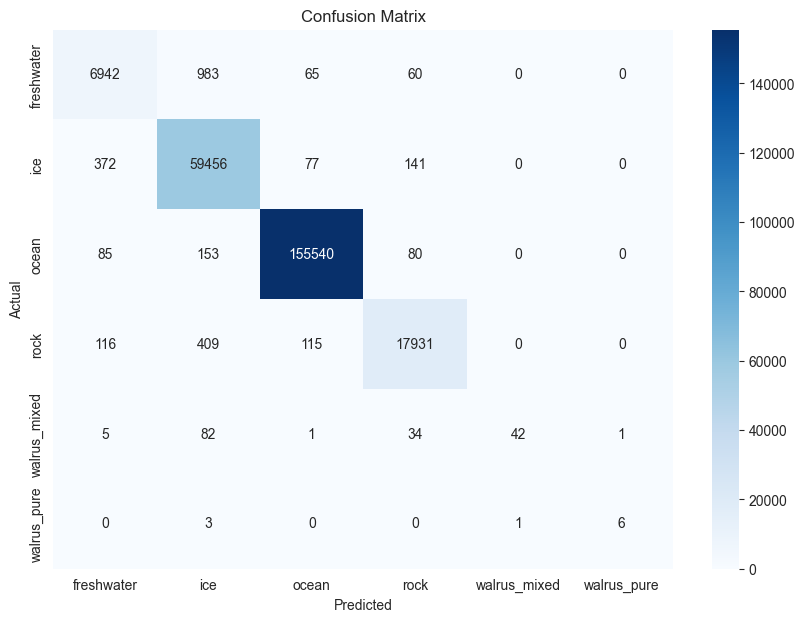

Accuracy: 0.99


In [34]:
# Evaluate the model
y_pred = model.predict(X_test)
labels = np.unique(y_train)  # Ensure labels are aligned with those in the training set
print(classification_report(y_test, y_pred, labels=labels, target_names=le.inverse_transform(labels)))

# Generate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=labels)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.inverse_transform(labels), yticklabels=le.inverse_transform(labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print accuracy
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
print(f"Accuracy: {accuracy:.2f}")

In [43]:
# Function to apply spatial rules and enforce proximity to ocean
def apply_spatial_rules_and_proximity(predicted_image, min_cluster_size=5, max_distance=15, min_ocean_freshwater_size=30):
    walrus_mask = (predicted_image == le.transform(['walrus_pure'])[0]) | (predicted_image == le.transform(['walrus_mixed'])[0])
    ocean_mask = (predicted_image == le.transform(['ocean'])[0])
    freshwater_mask = (predicted_image == le.transform(['freshwater'])[0])

    # Dilate ocean pixels to consider proximity
    dilated_ocean = binary_dilation(ocean_mask, iterations=max_distance)
    
    # Apply spatial rules
    walrus_clusters, num_walrus_features = label(walrus_mask)
    ocean_clusters, num_ocean_features = label(ocean_mask)
    freshwater_clusters, num_freshwater_features = label(freshwater_mask)
    
    valid_walrus_clusters = np.zeros_like(walrus_mask)
    valid_ocean_clusters = np.zeros_like(ocean_mask)
    valid_freshwater_clusters = np.zeros_like(freshwater_mask)
    
    for cluster_num in range(1, num_walrus_features + 1):
        cluster_pixels = walrus_clusters == cluster_num
        if np.sum(cluster_pixels) >= min_cluster_size and np.any(dilated_ocean & cluster_pixels):
            valid_walrus_clusters[cluster_pixels] = 1
    
    for cluster_num in range(1, num_ocean_features + 1):
        cluster_pixels = ocean_clusters == cluster_num
        if np.sum(cluster_pixels) >= min_ocean_freshwater_size:
            valid_ocean_clusters[cluster_pixels] = 1
            
    for cluster_num in range(1, num_freshwater_features + 1):
        cluster_pixels = freshwater_clusters == cluster_num
        if np.sum(cluster_pixels) >= min_ocean_freshwater_size:
            valid_freshwater_clusters[cluster_pixels] = 1
    
    final_mask = (valid_walrus_clusters == 1) | (valid_ocean_clusters == 1) | (valid_freshwater_clusters == 1)
    return final_mask

# Function to predict classes for a given image
def predict_image(image_path, model, feature_names):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        df = pd.DataFrame(image_reshaped, columns=feature_names)
        predictions = model.predict(df)
        return predictions.reshape((src.height, src.width))

# Parameters for spatial rules
min_walrus_cluster_size = 15  # Change this value as needed
max_proximity_distance = 50  # Change this value as needed
min_ocean_freshwater_cluster_size = 5  # Change this value as needed


Labels present in buch_20230714_image.tif: [array([], shape=(0, 6), dtype='<U12'), array([['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed',
        'walrus_pure']], dtype='<U12')]


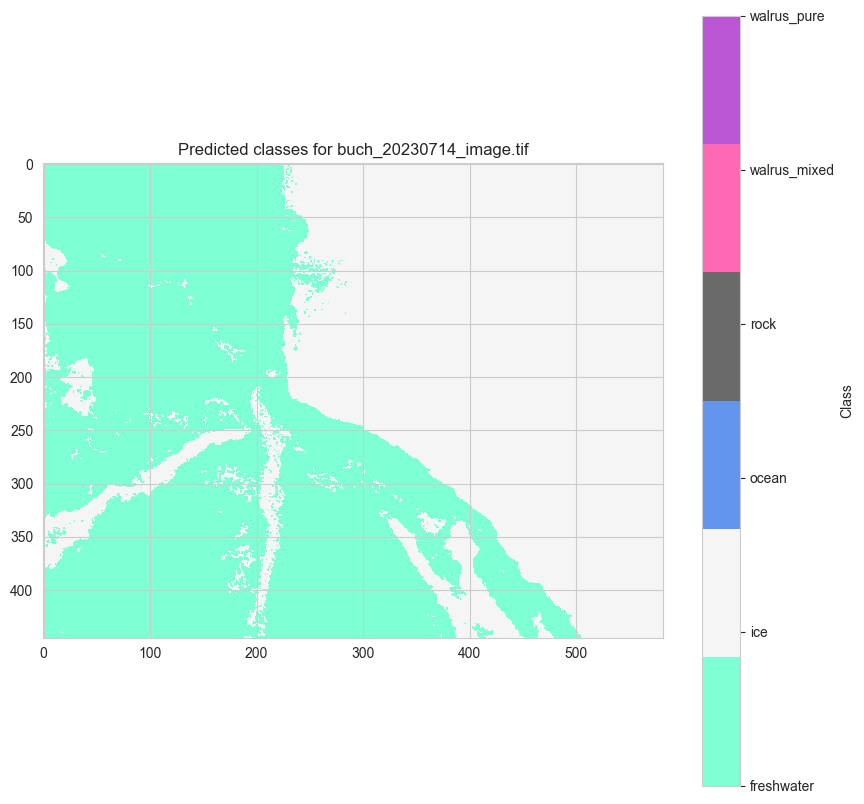

Labels present in buch_20230720_image.tif: [array([], shape=(0, 6), dtype='<U12'), array([['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed',
        'walrus_pure']], dtype='<U12')]


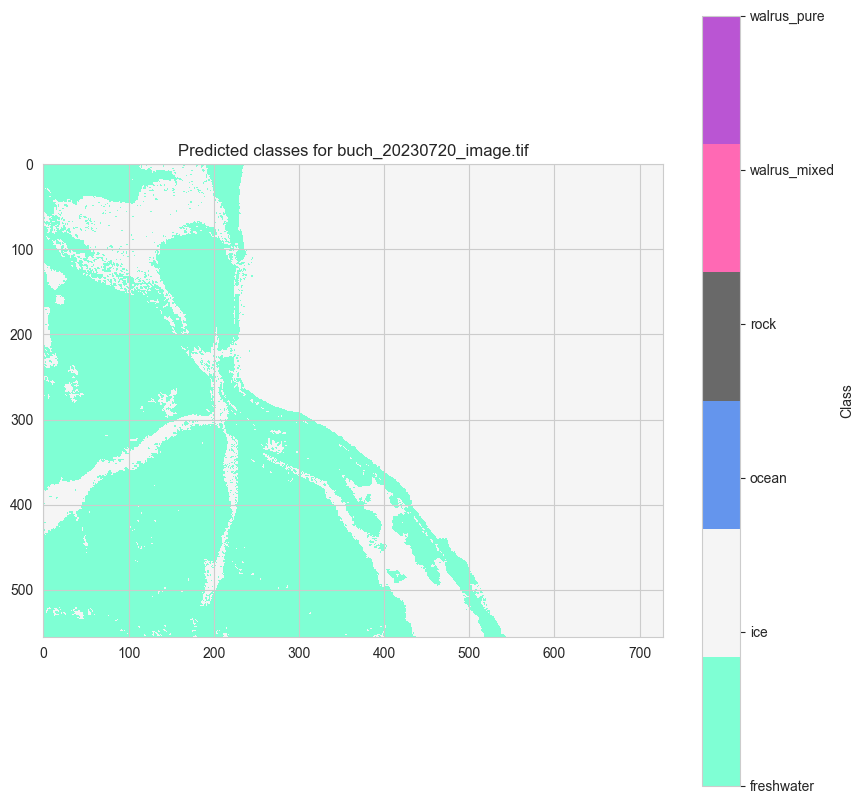

Labels present in buch_20230731_image.tif: [array([], shape=(0, 6), dtype='<U12'), array([['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed',
        'walrus_pure']], dtype='<U12')]


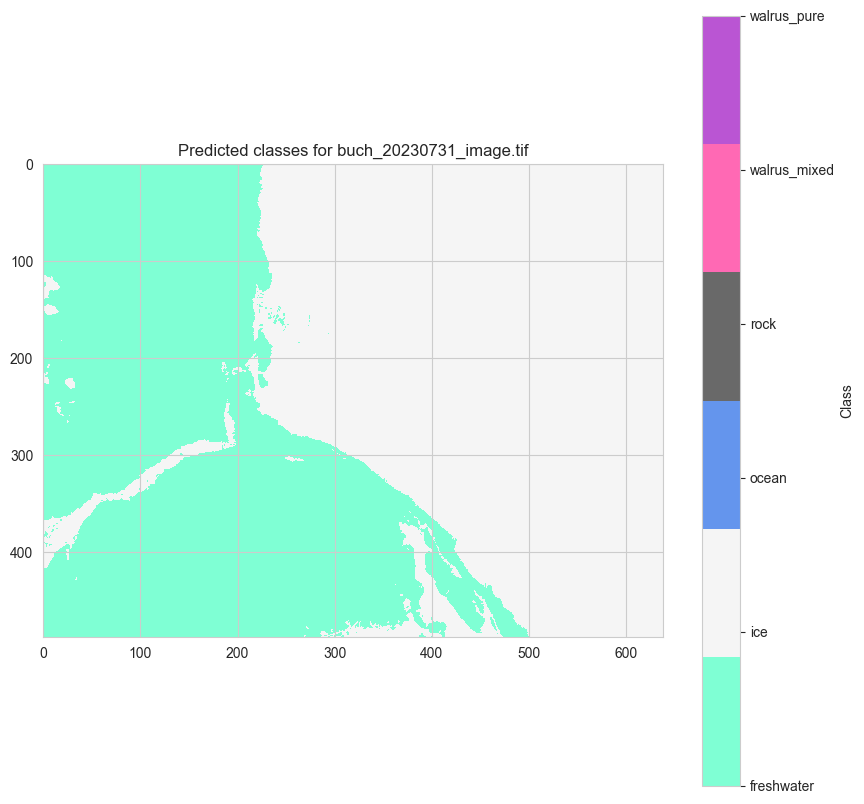

Labels present in buch_20230923_image.tif: [array([], shape=(0, 6), dtype='<U12'), array([['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed',
        'walrus_pure']], dtype='<U12')]


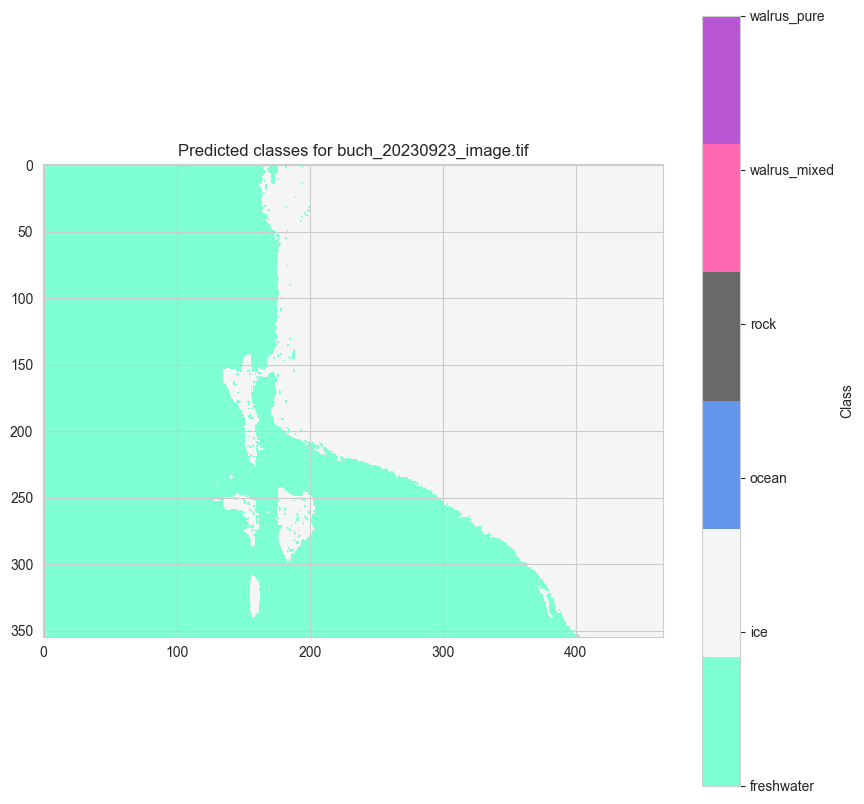

Labels present in moff_20230717_image.tif: [array([], shape=(0, 6), dtype='<U12'), array([['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed',
        'walrus_pure']], dtype='<U12')]


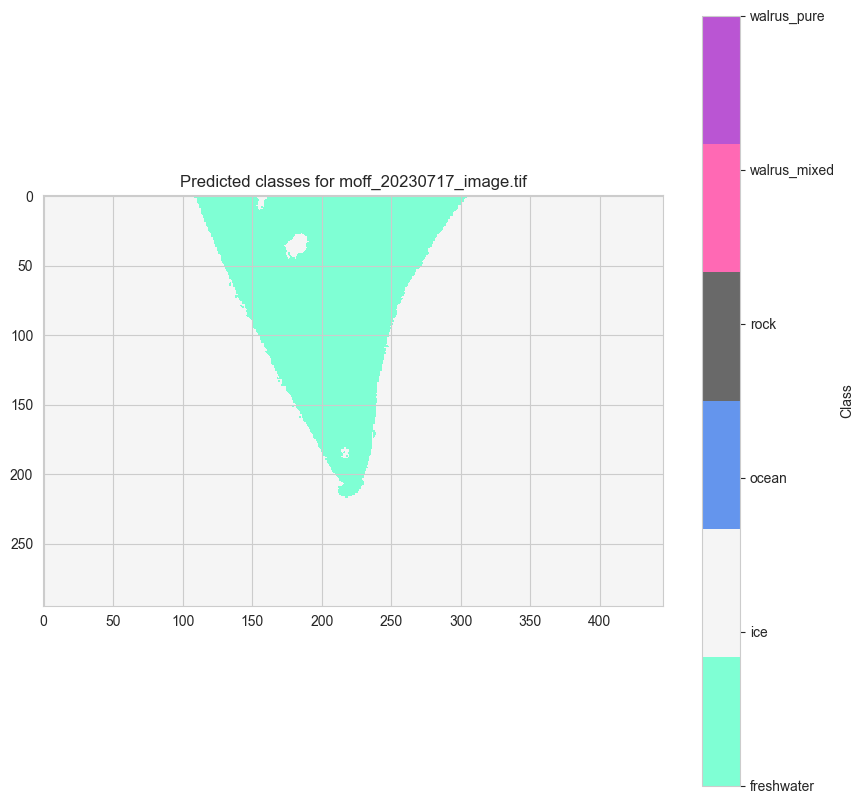

Labels present in pal_20230714_image.tif: [array([], shape=(0, 6), dtype='<U12'), array([['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed',
        'walrus_pure']], dtype='<U12')]


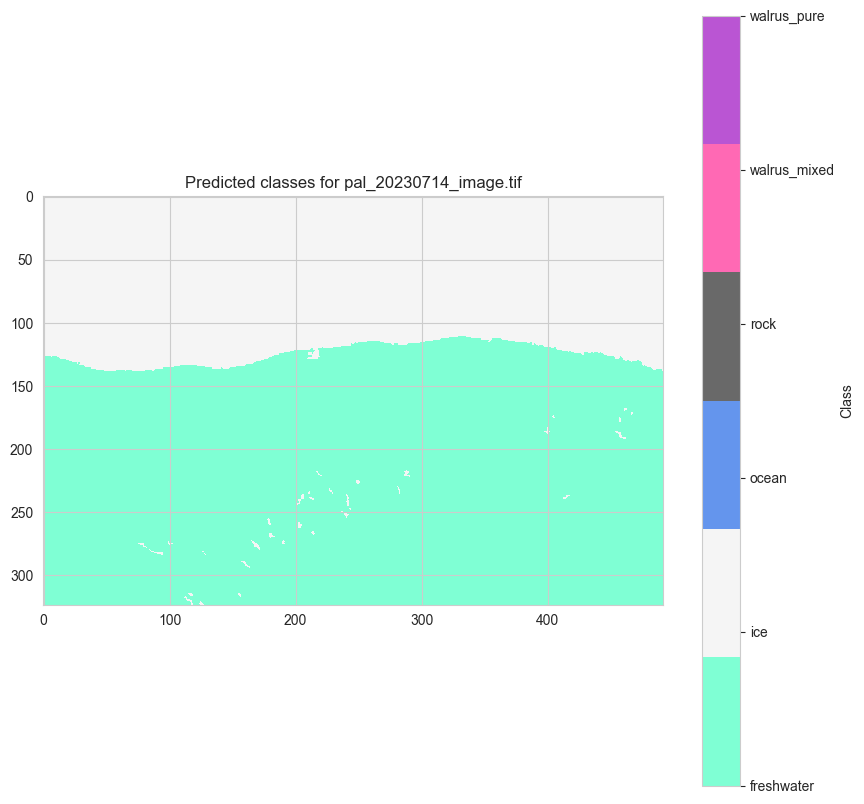

Labels present in pal_20230720_image.tif: [array([], shape=(0, 6), dtype='<U12'), array([['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed',
        'walrus_pure']], dtype='<U12')]


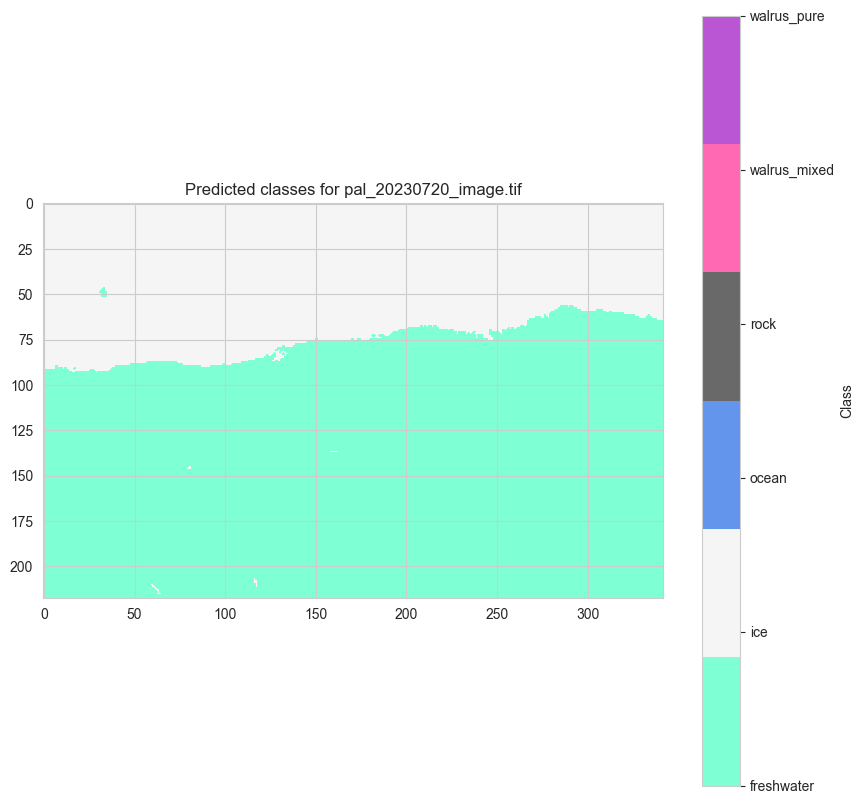

Labels present in pal_20230726_image.tif: [array([], shape=(0, 6), dtype='<U12'), array([['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed',
        'walrus_pure']], dtype='<U12')]


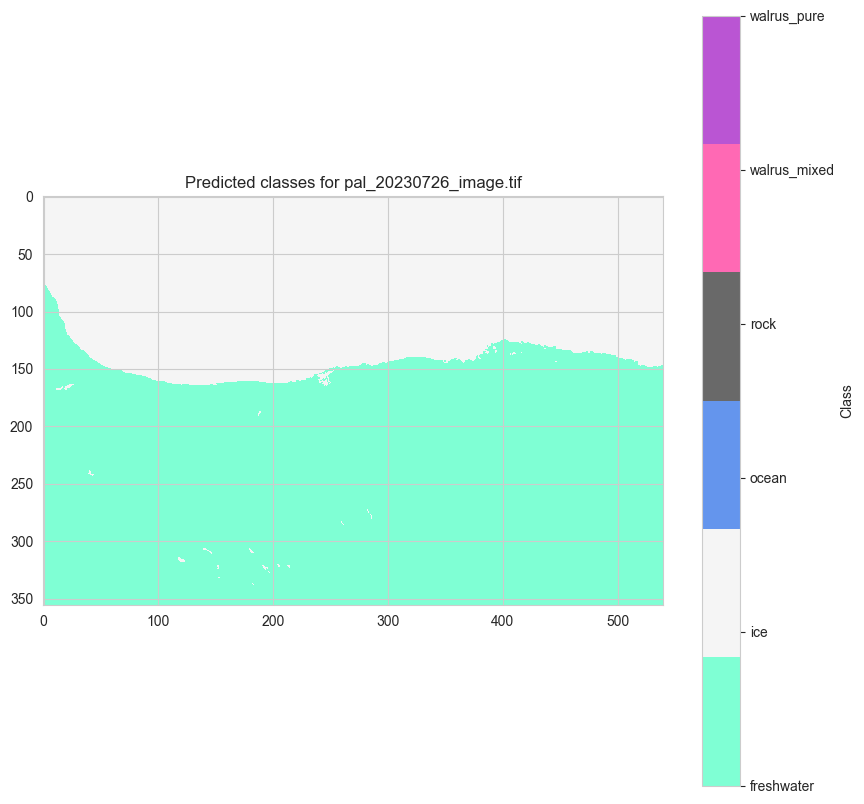

Labels present in sars_20230714_image.tif: [array([], shape=(0, 6), dtype='<U12'), array([['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed',
        'walrus_pure']], dtype='<U12')]


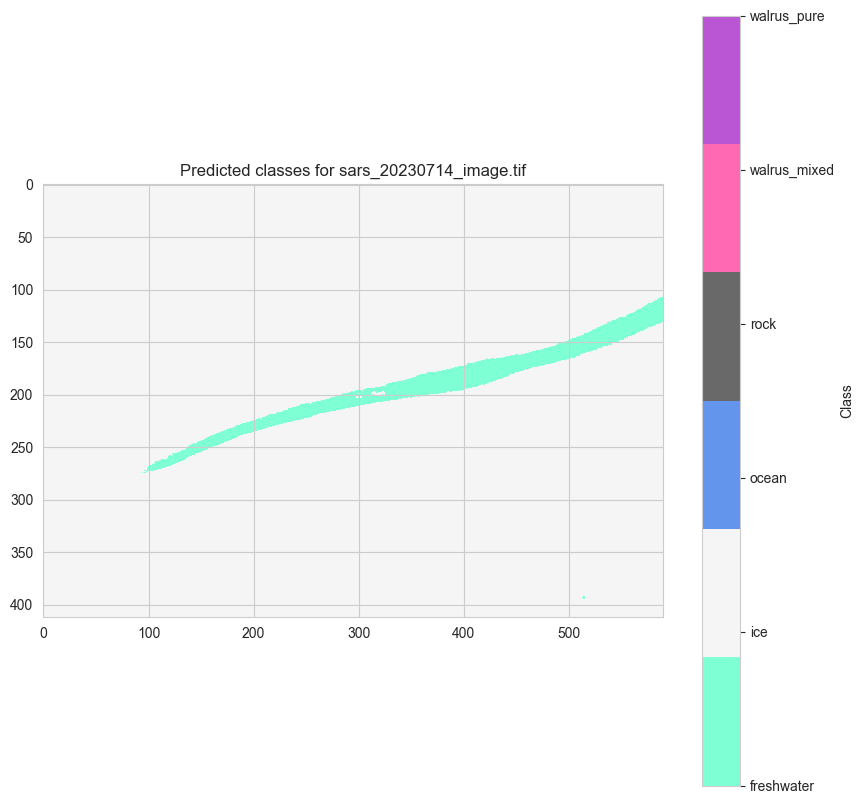

Labels present in sars_20230803_image.tif: [array([], shape=(0, 6), dtype='<U12'), array([['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed',
        'walrus_pure']], dtype='<U12')]


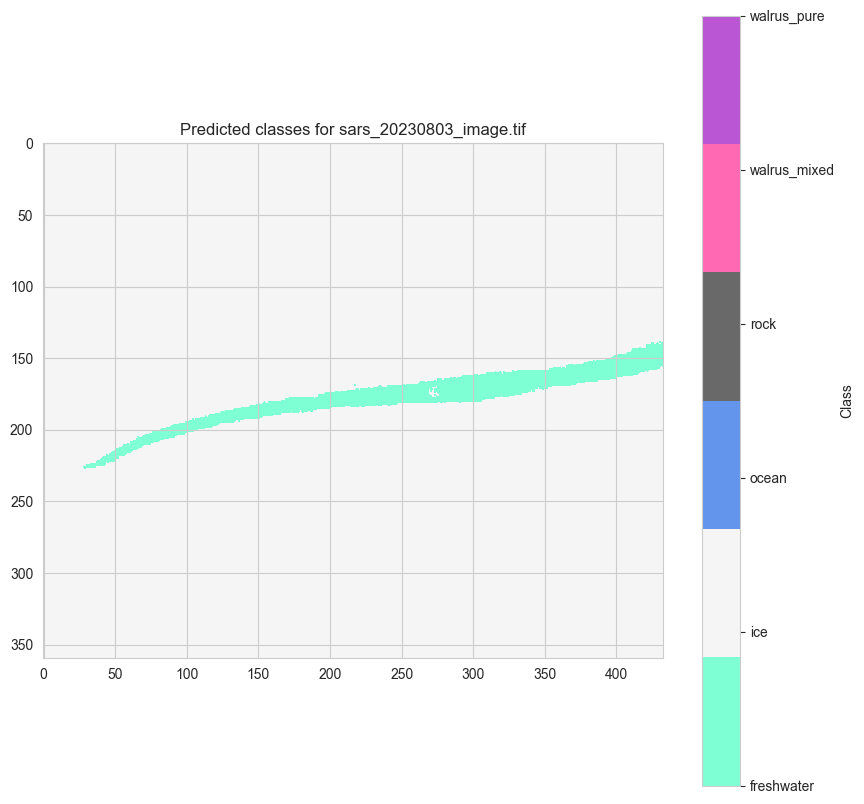

Labels present in tor_20230801_image.tif: [array([], shape=(0, 6), dtype='<U12'), array([['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed',
        'walrus_pure']], dtype='<U12')]


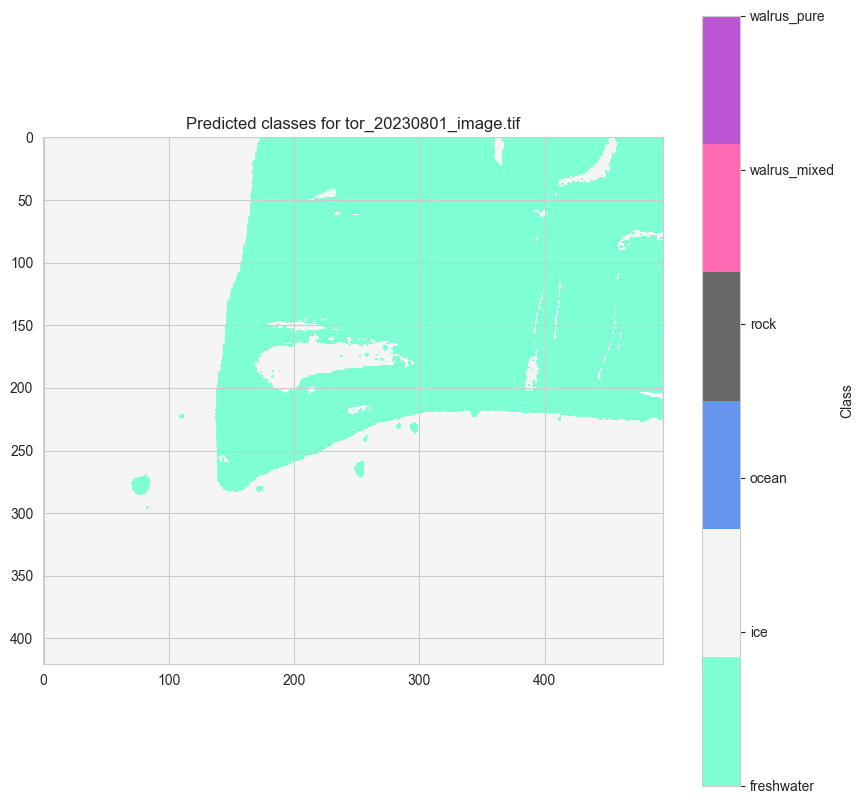

Labels present in tor_20230824_image.tif: [array([], shape=(0, 6), dtype='<U12'), array([['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed',
        'walrus_pure']], dtype='<U12')]


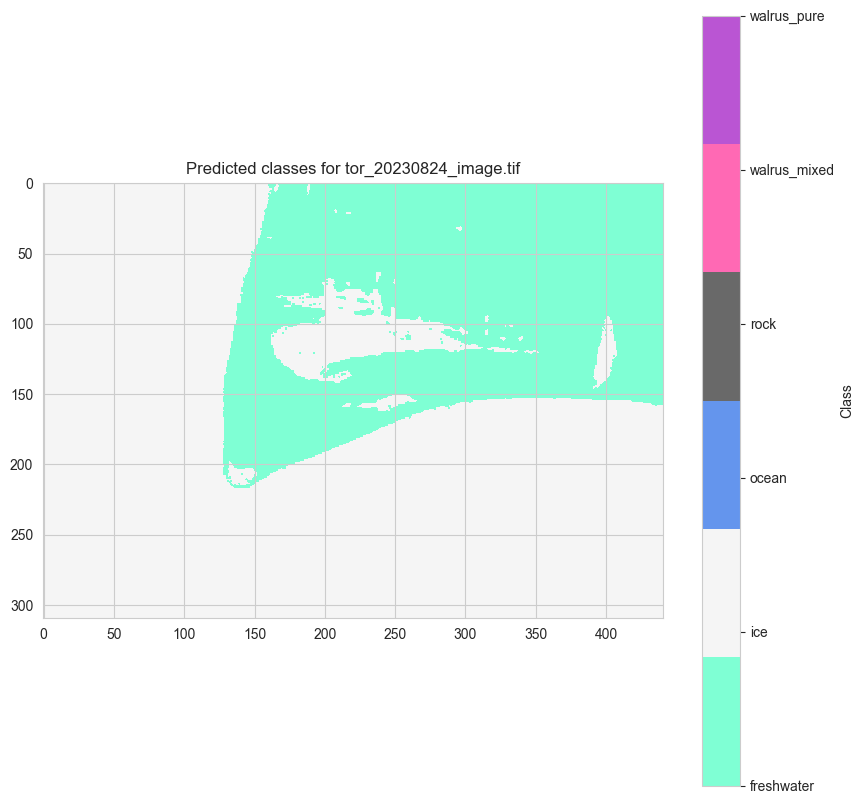

Labels present in tor_20230901_image.tif: [array([], shape=(0, 6), dtype='<U12'), array([['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed',
        'walrus_pure']], dtype='<U12')]


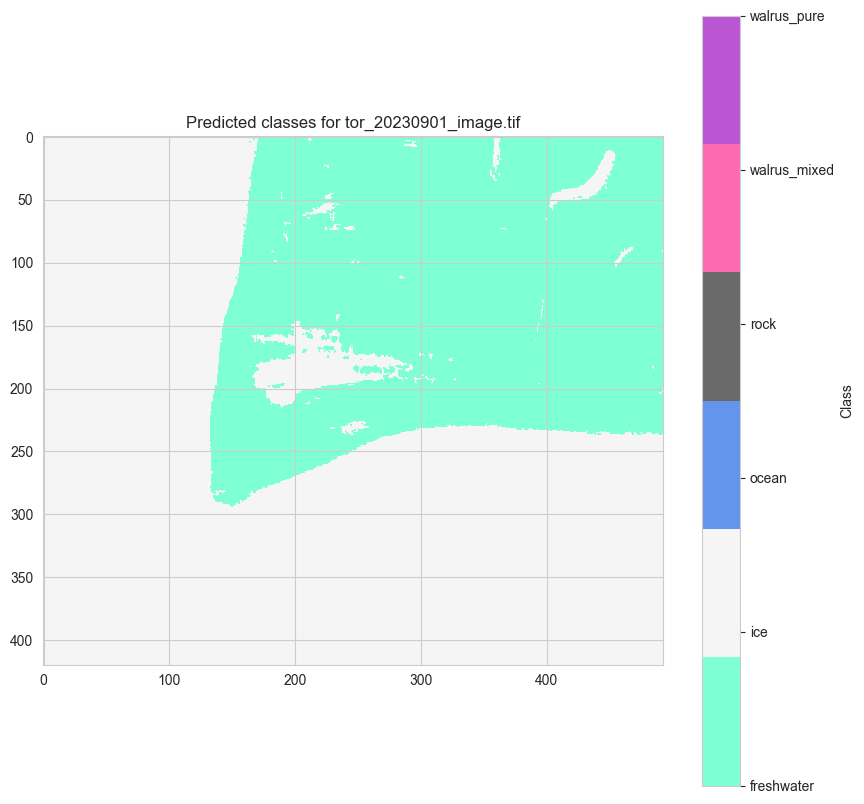

Labels present in tor_20230902_image.tif: [array([], shape=(0, 6), dtype='<U12'), array([['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed',
        'walrus_pure']], dtype='<U12')]


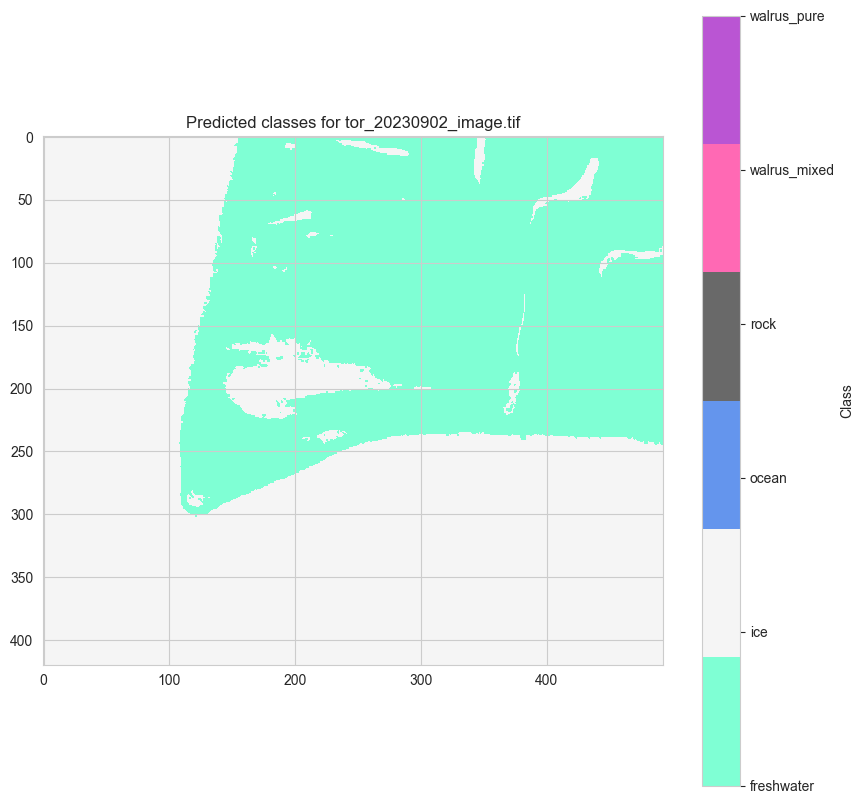

In [44]:
predicted_images = {}
feature_names = ['Coast_blue', 'Blue', 'Green1', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR']

for image_path, shapefile_path in file_pairs.items():
    predicted_image = predict_image(image_path, model, feature_names)
    final_mask = apply_spatial_rules_and_proximity(predicted_image, 
                                                   min_cluster_size=min_walrus_cluster_size, 
                                                   max_distance=max_proximity_distance, 
                                                   min_ocean_freshwater_size=min_ocean_freshwater_cluster_size)
    predicted_images[image_path] = final_mask

# Define a color map for the labels
label_colors = {
    'ice': 'whitesmoke',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'freshwater': 'aquamarine',
    'walrus_pure': 'mediumorchid',
    'walrus_mixed': 'hotpink'
}

# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)

    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels

    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")

    plt.show()

Labels present in buch_20230714_image.tif: [array([], shape=(0, 6), dtype='<U12'), array([['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed',
        'walrus_pure']], dtype='<U12')]


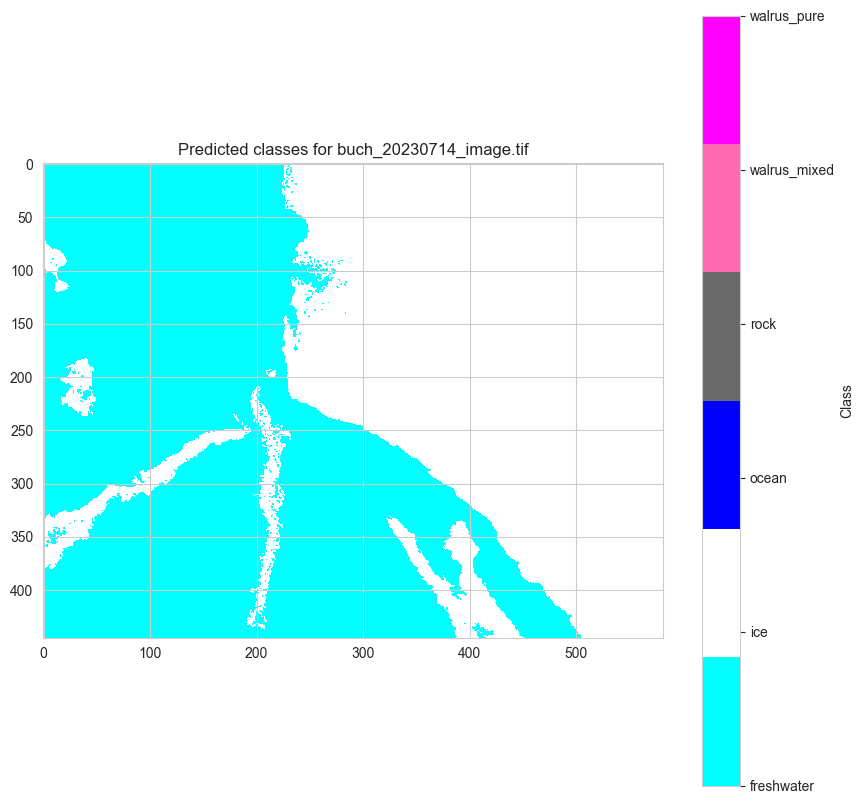

Labels present in buch_20230720_image.tif: [array([], shape=(0, 6), dtype='<U12'), array([['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed',
        'walrus_pure']], dtype='<U12')]


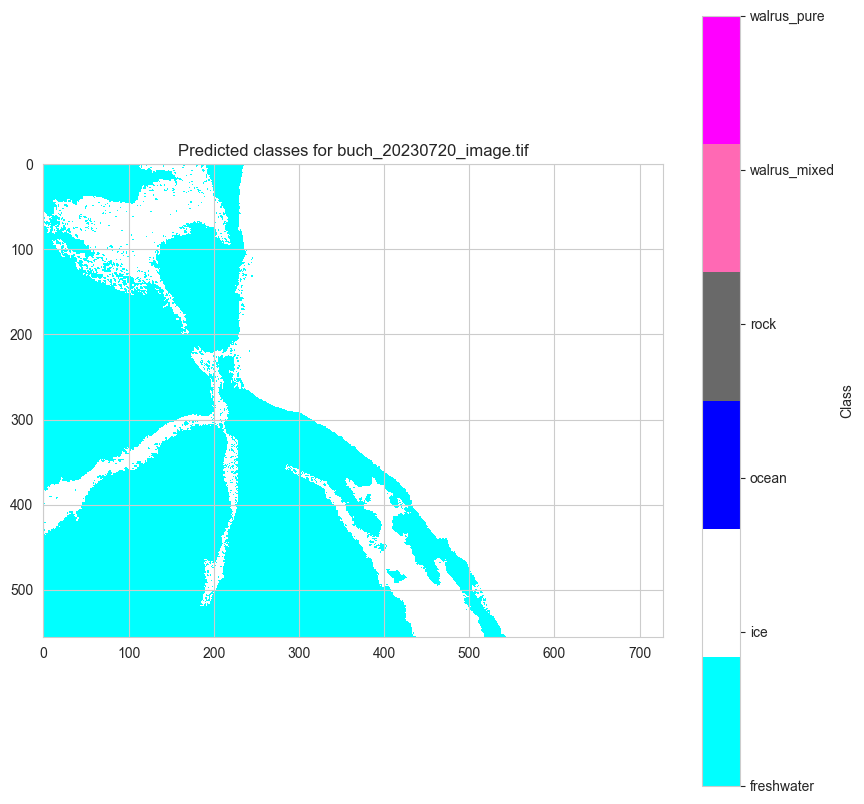

Labels present in buch_20230731_image.tif: [array([], shape=(0, 6), dtype='<U12'), array([['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed',
        'walrus_pure']], dtype='<U12')]


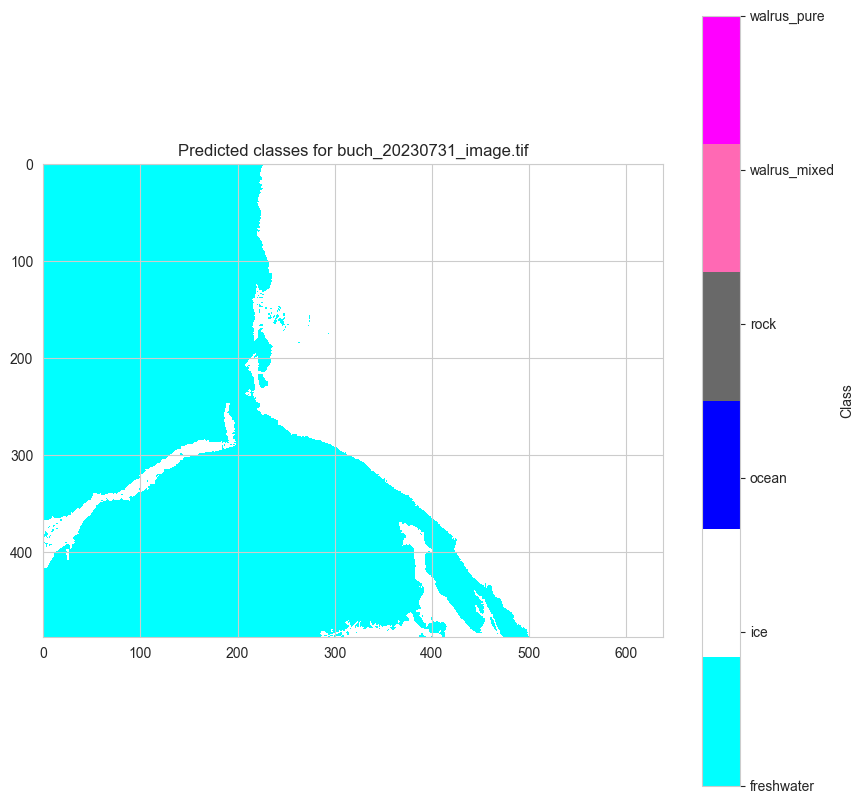

Labels present in buch_20230923_image.tif: [array([], shape=(0, 6), dtype='<U12'), array([['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed',
        'walrus_pure']], dtype='<U12')]


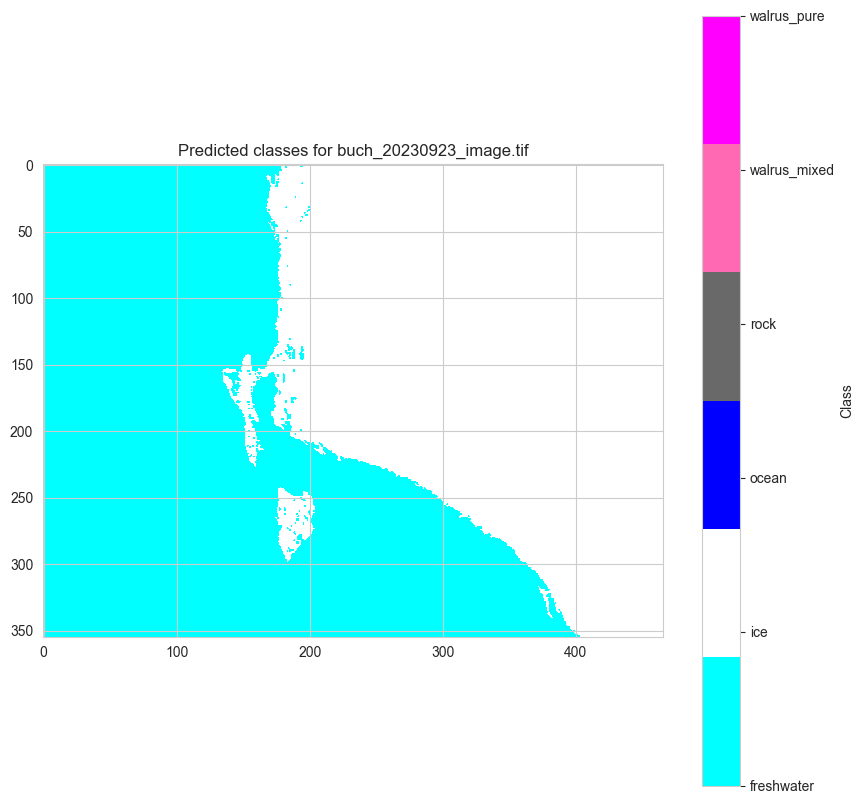

Labels present in moff_20230717_image.tif: [array([], shape=(0, 6), dtype='<U12'), array([['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed',
        'walrus_pure']], dtype='<U12')]


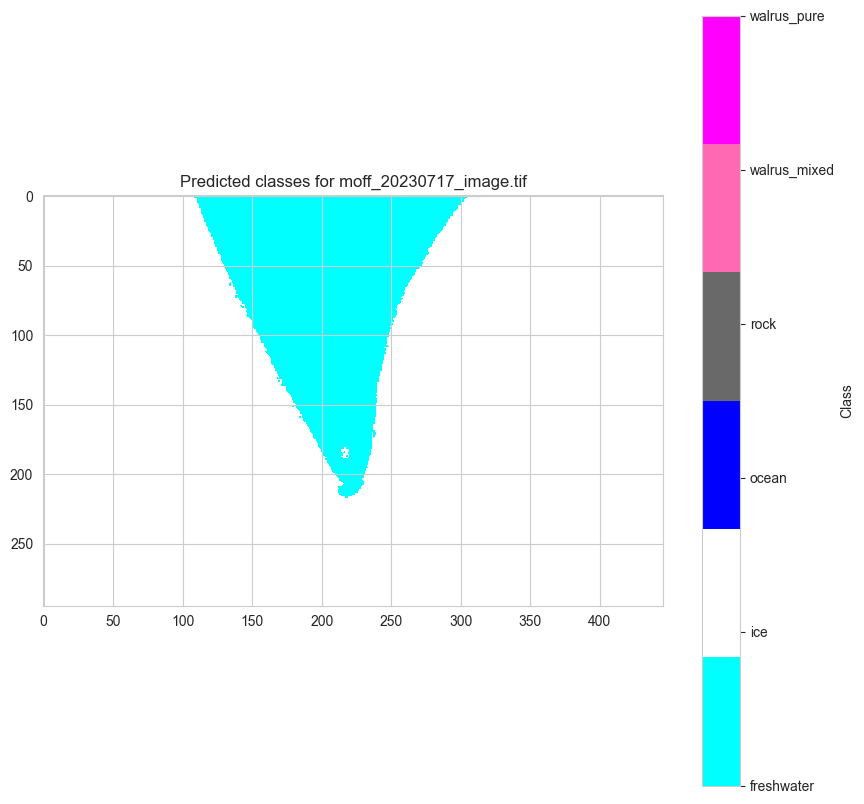

Labels present in pal_20230714_image.tif: [array([], shape=(0, 6), dtype='<U12'), array([['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed',
        'walrus_pure']], dtype='<U12')]


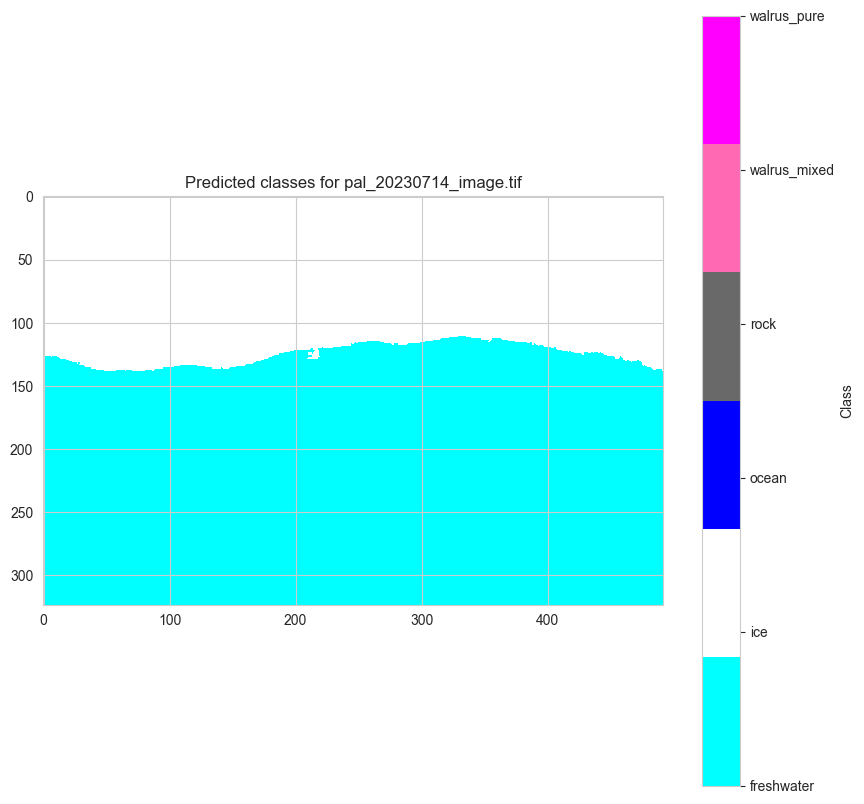

Labels present in pal_20230720_image.tif: [array([], shape=(0, 6), dtype='<U12'), array([['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed',
        'walrus_pure']], dtype='<U12')]


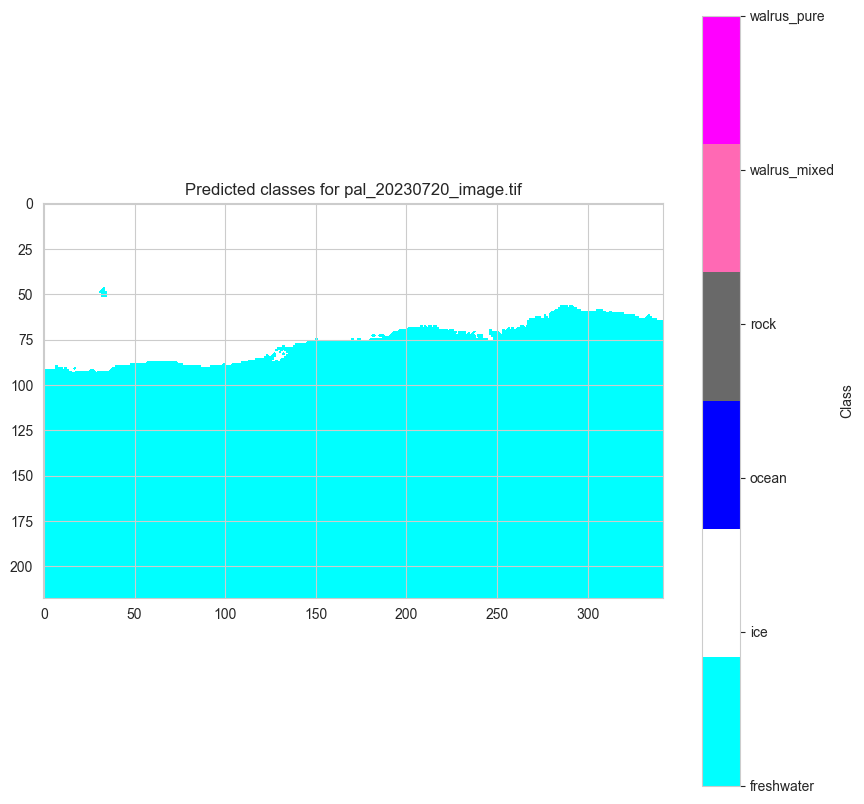

Labels present in pal_20230726_image.tif: [array([], shape=(0, 6), dtype='<U12'), array([['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed',
        'walrus_pure']], dtype='<U12')]


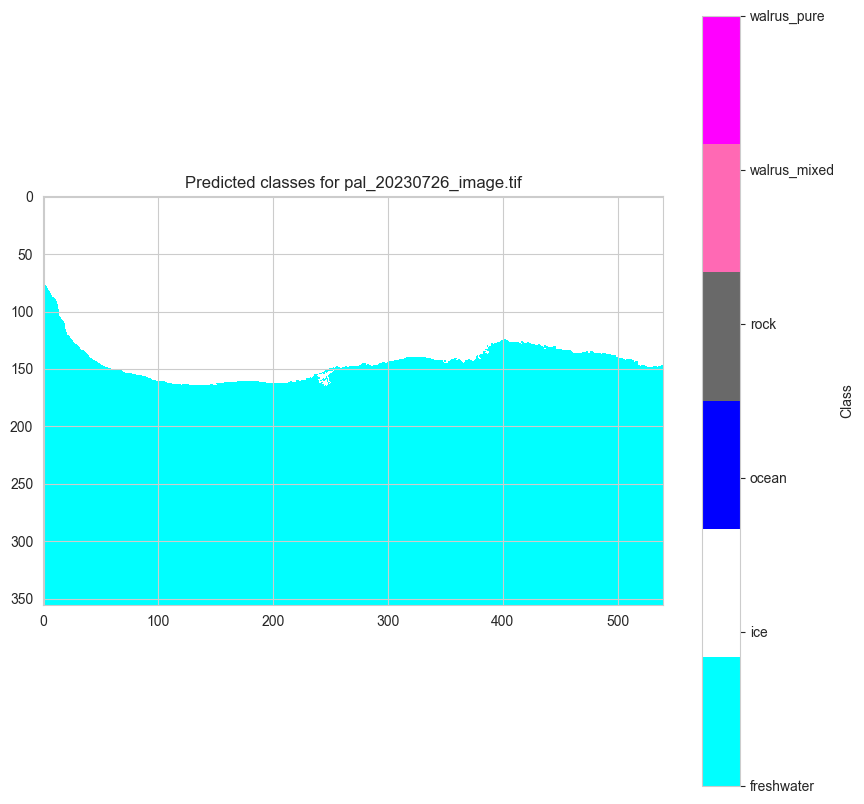

Labels present in sars_20230714_image.tif: [array([], shape=(0, 6), dtype='<U12'), array([['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed',
        'walrus_pure']], dtype='<U12')]


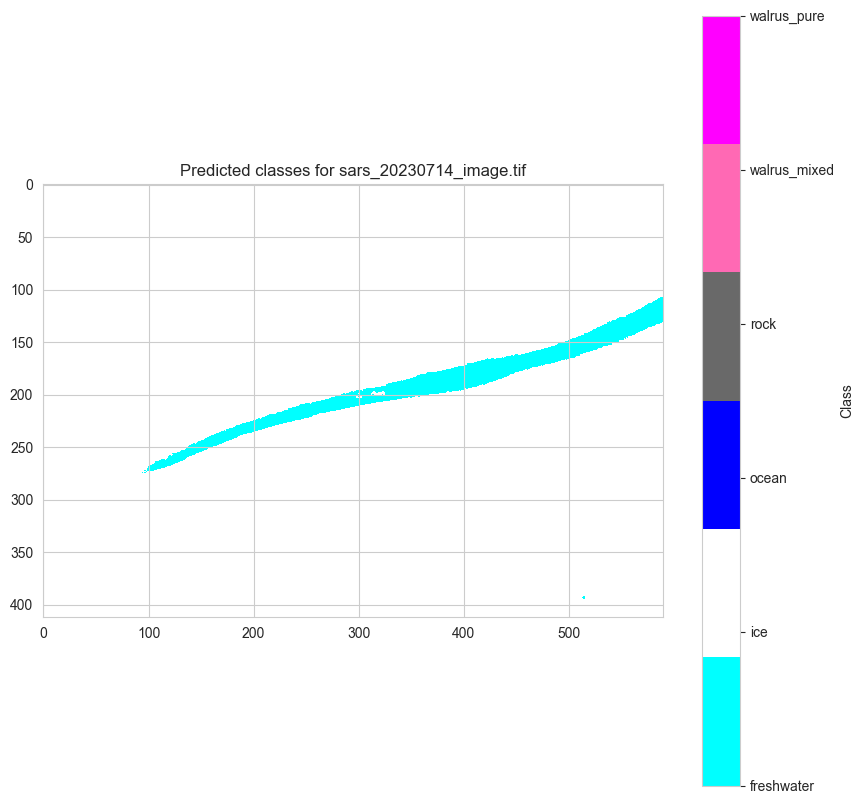

Labels present in sars_20230803_image.tif: [array([], shape=(0, 6), dtype='<U12'), array([['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed',
        'walrus_pure']], dtype='<U12')]


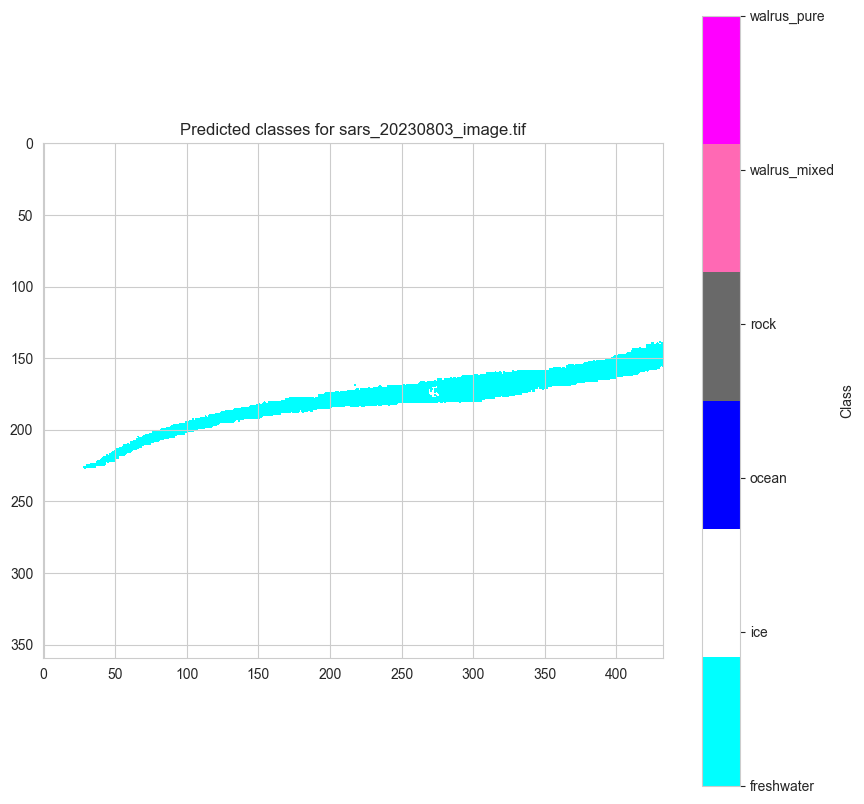

Labels present in tor_20230801_image.tif: [array([], shape=(0, 6), dtype='<U12'), array([['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed',
        'walrus_pure']], dtype='<U12')]


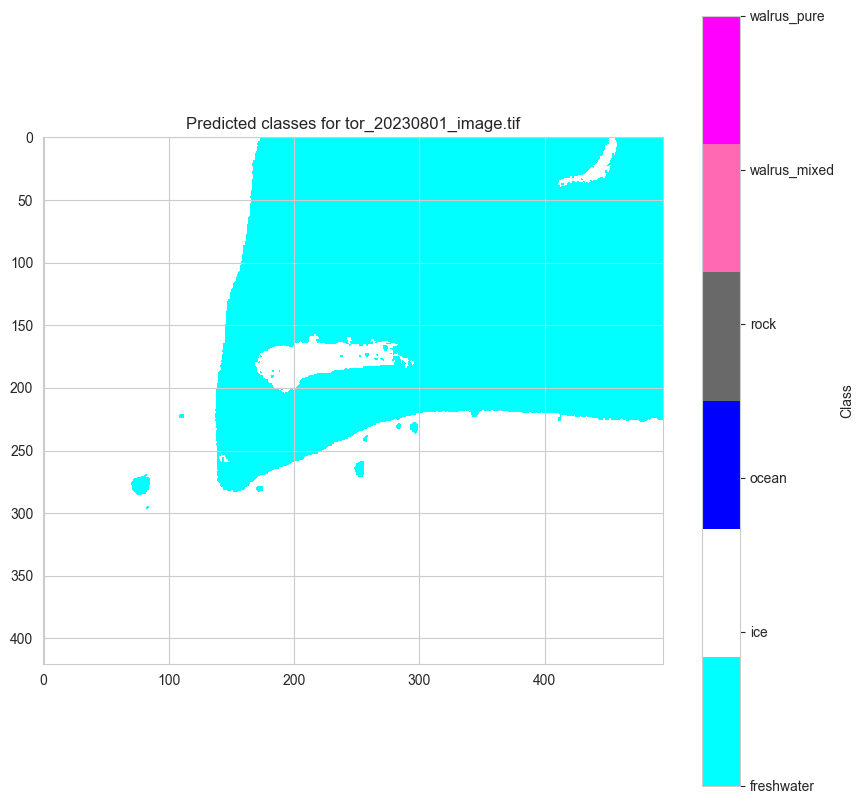

Labels present in tor_20230824_image.tif: [array([], shape=(0, 6), dtype='<U12'), array([['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed',
        'walrus_pure']], dtype='<U12')]


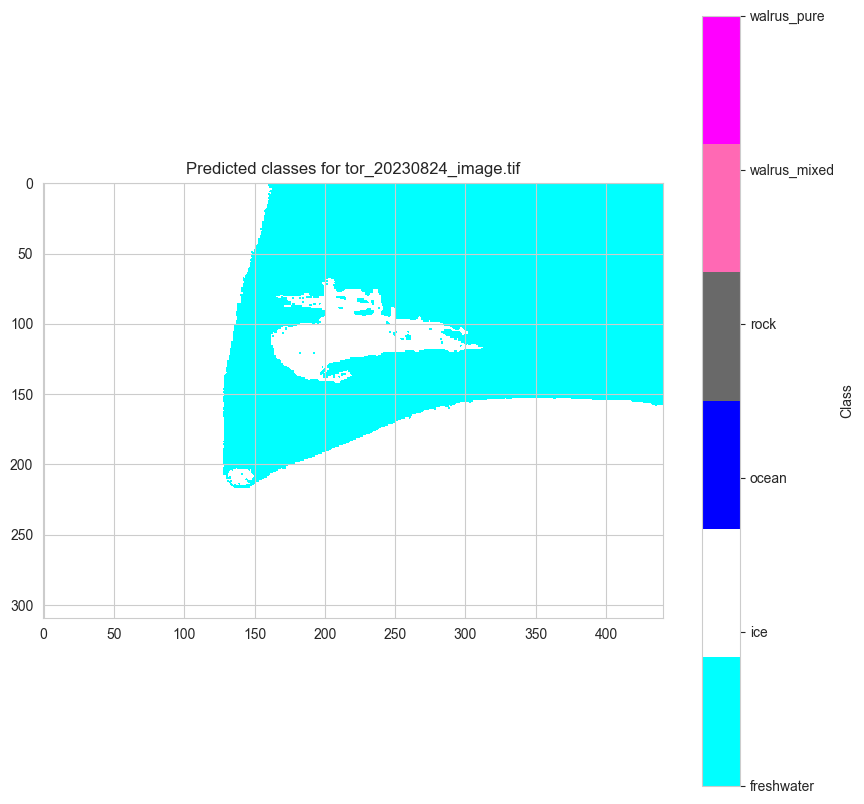

Labels present in tor_20230901_image.tif: [array([], shape=(0, 6), dtype='<U12'), array([['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed',
        'walrus_pure']], dtype='<U12')]


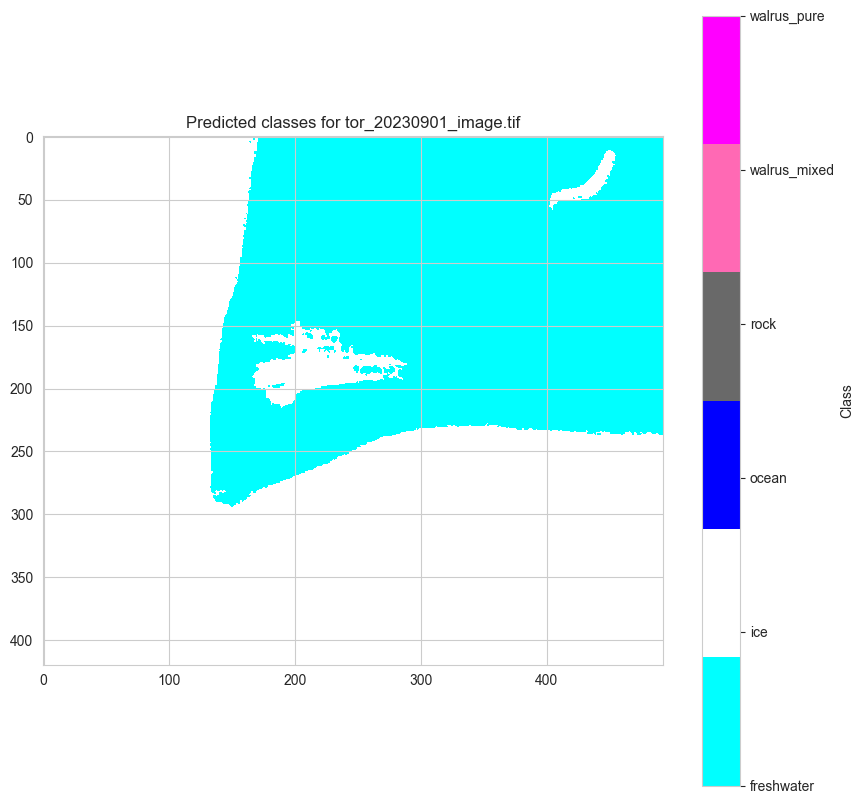

Labels present in tor_20230902_image.tif: [array([], shape=(0, 6), dtype='<U12'), array([['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed',
        'walrus_pure']], dtype='<U12')]


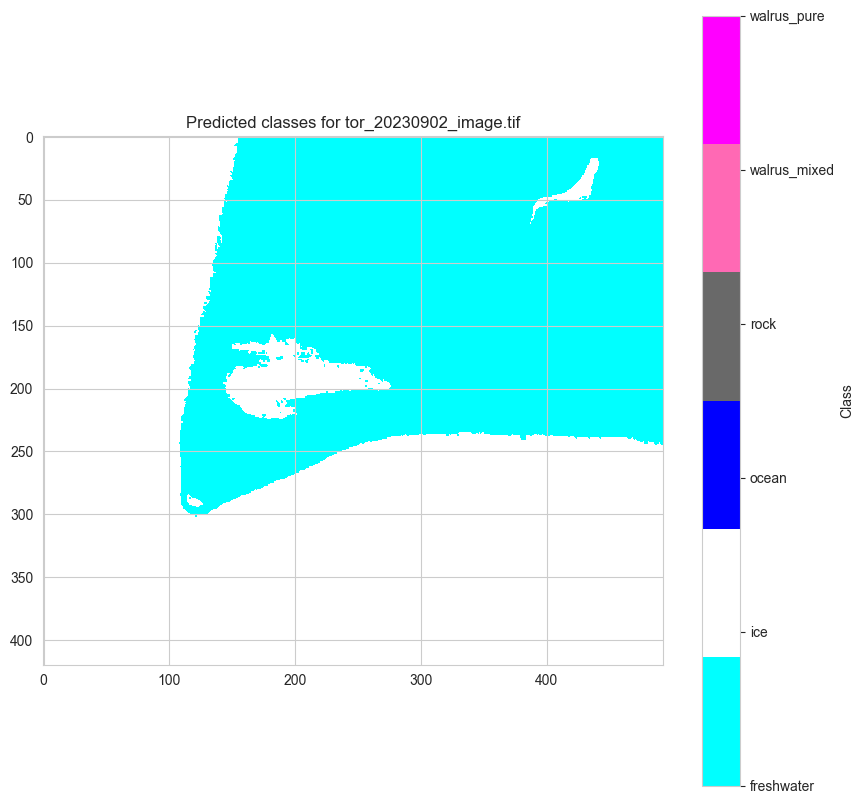

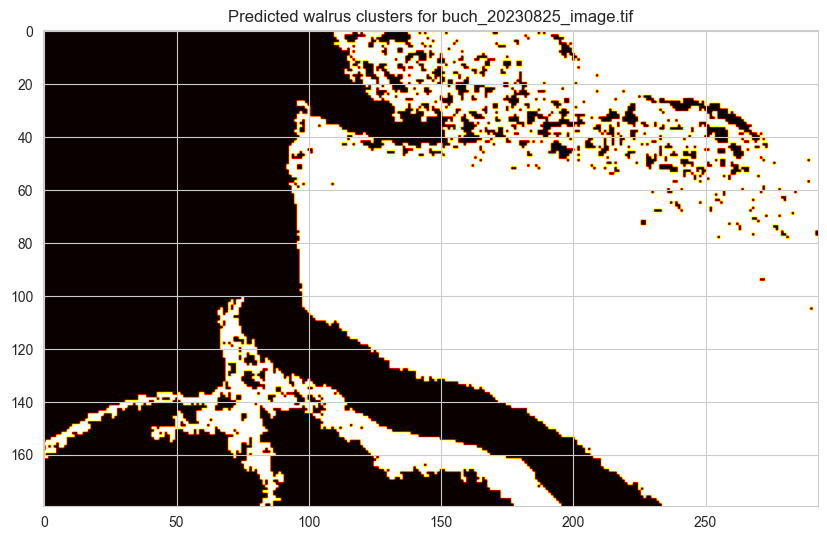

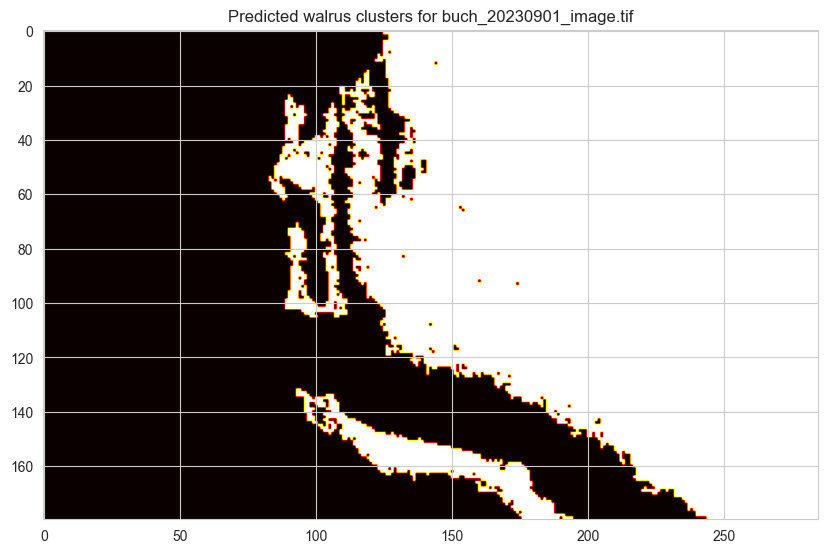

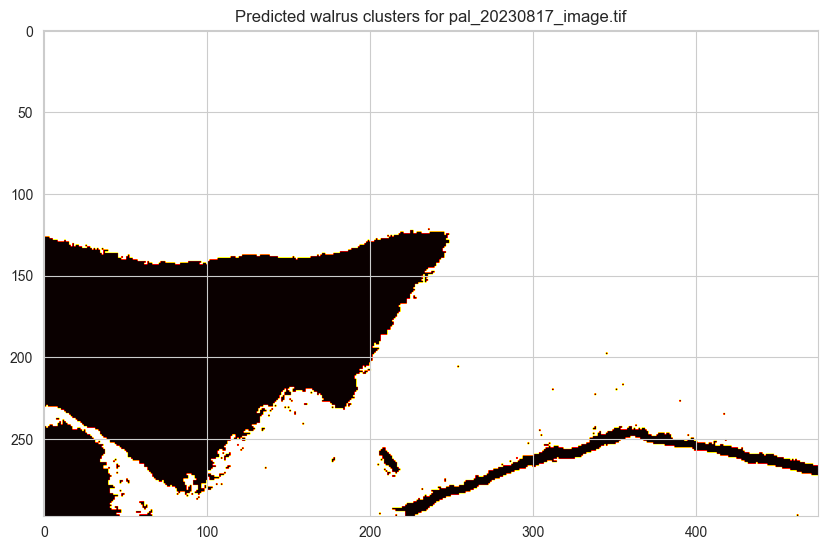

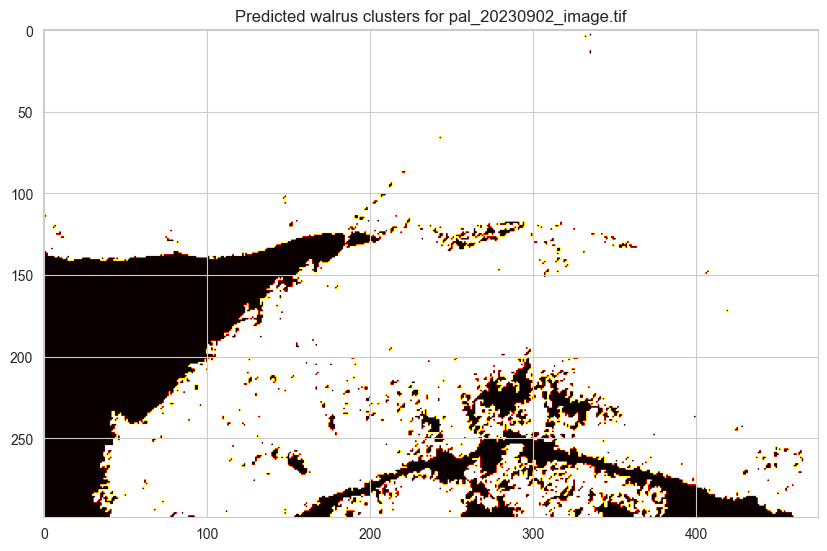

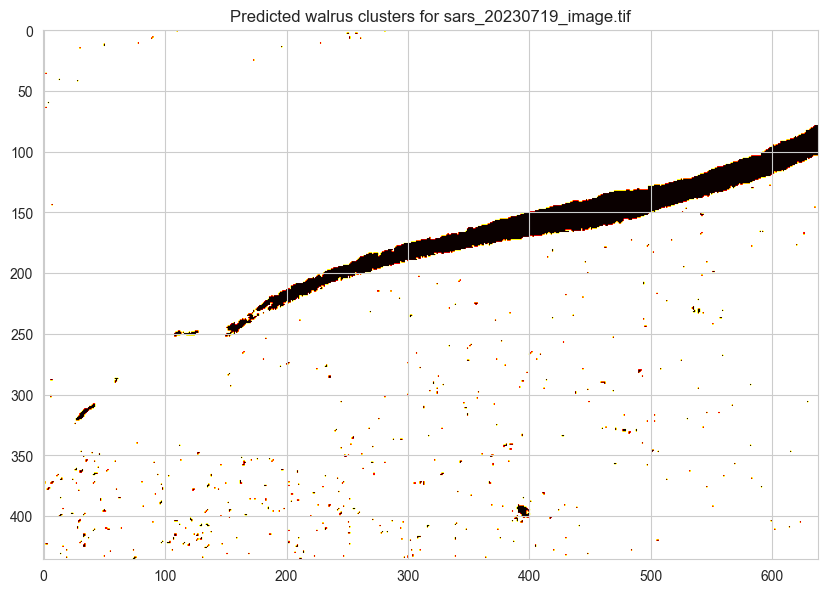

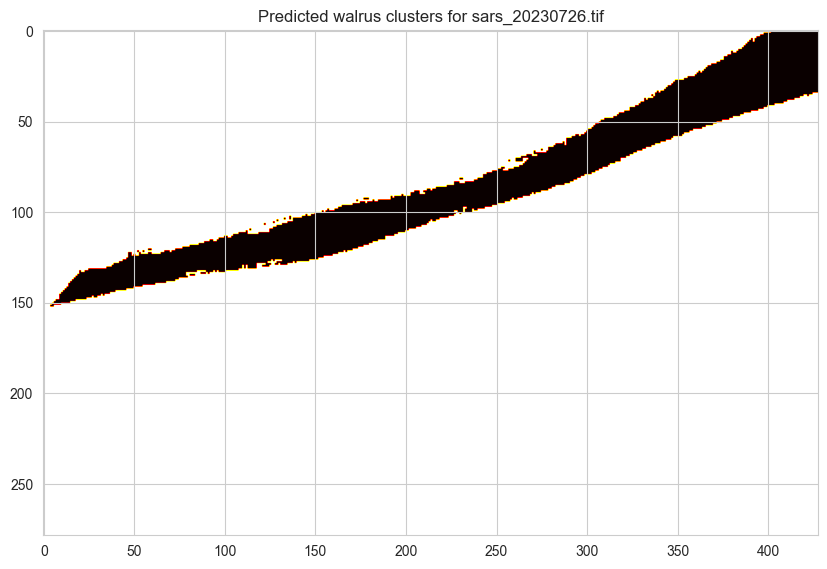

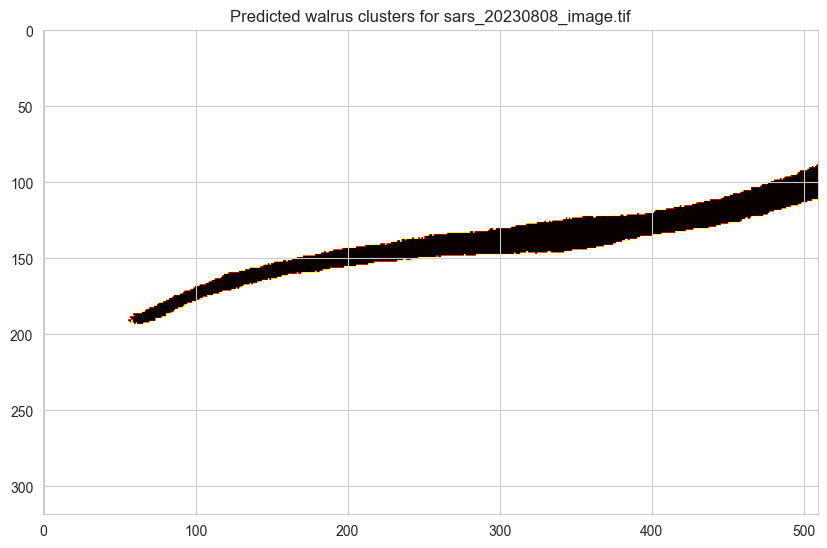

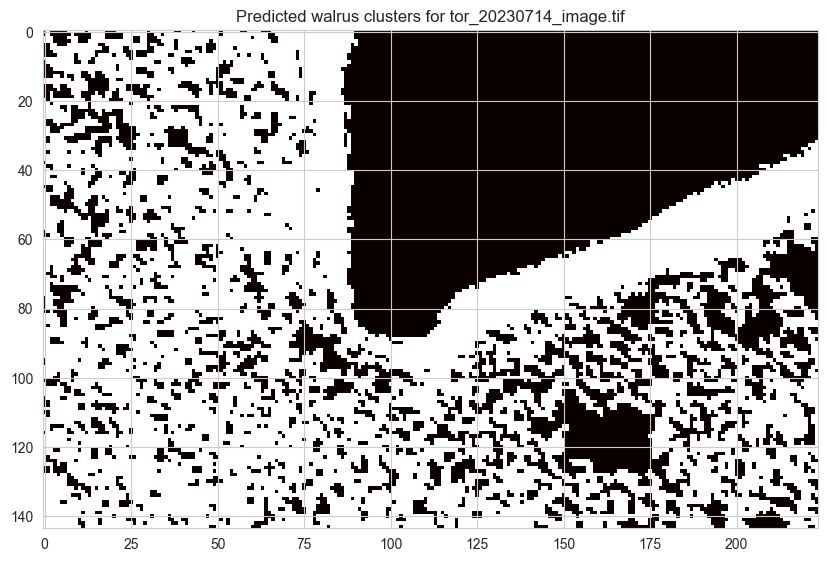

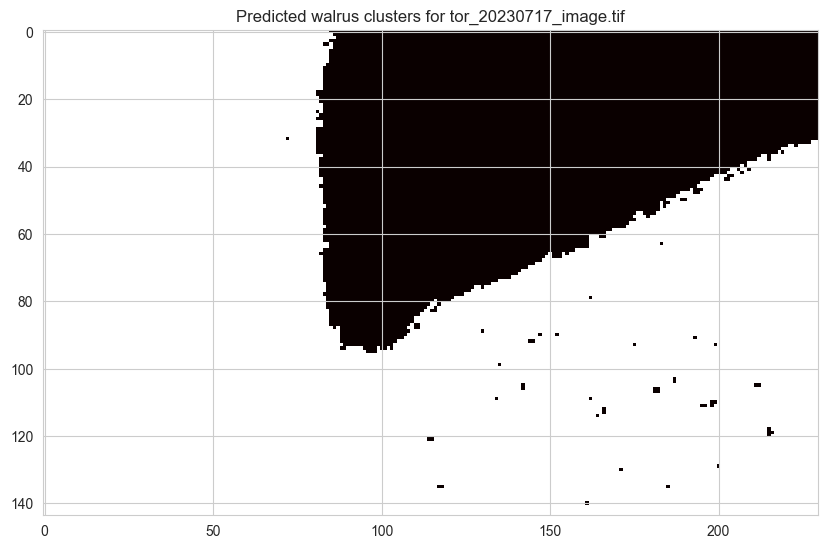

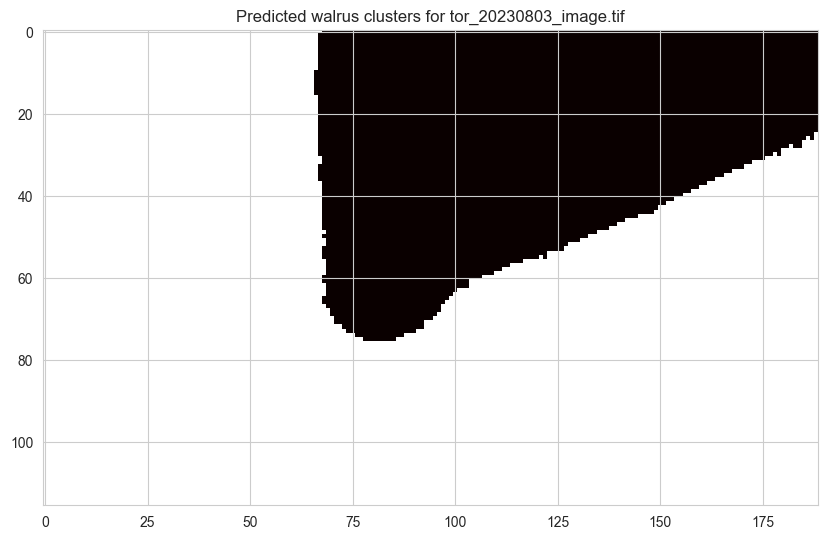

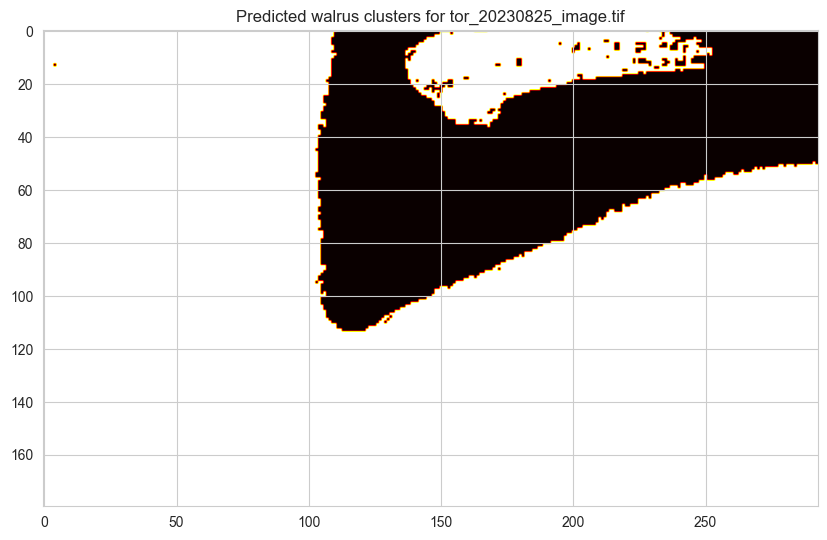

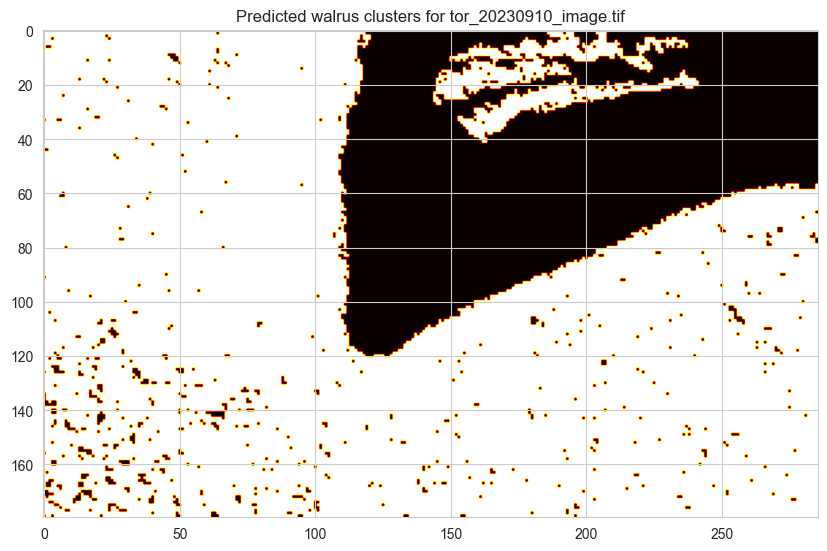

In [36]:
# Load the saved model
loaded_model = joblib.load(model_filename)

# Predict and apply spatial rules for unseen images
for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, loaded_model, feature_names)
    final_mask = apply_spatial_rules_and_proximity(predicted_image, 
                                                   min_cluster_size=min_walrus_cluster_size, 
                                                   max_distance=max_proximity_distance, 
                                                   min_ocean_freshwater_size=min_ocean_freshwater_cluster_size)
    
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted walrus clusters for {os.path.basename(image_path)}")
    plt.imshow(final_mask, cmap='hot')
    plt.show()

In [16]:
import os
import re
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from rasterio.mask import geometry_mask
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from scipy.ndimage import label, binary_dilation
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import joblib

In [17]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    shapefile_path = matching_shapefiles[0]
    file_pairs[image_path] = shapefile_path

# Function to extract features and labels
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    img_name = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']

        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
            img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

features = []
labels = []
image_name = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)
    image_name.append(img_name)

features = np.vstack(features)
labels = np.hstack(labels)
image_name = np.hstack(image_name)
print(features, labels, image_name)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({'Coast_blue': features[:, 0],
                        'Blue': features[:, 1],
                        'Green1': features[:, 2],
                        'Green': features[:, 3],
                        'Yellow': features[:, 4],
                        'Red': features[:, 5],
                        'Red_edge': features[:, 6],
                        'NIR': features[:, 7],
                        'labels': labels,
                        'encoded_labels': encoded_labels,
                        'image_name': image_name})


No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif
[[1187  980 1269 ... 1329 1416 1650]
 [1148  912 1212 ... 1240 1297 1612]
 [1131  856 1162 ... 1181 1355 1510]
 ...
 [1730 1870 1929 ... 2091 2276 2647]
 [1634 1851 1879 ... 2053 2281 2634]
 [1720 1904 1905 ... 2135 2316 2654]] ['walrus_mixed' 'walrus_mixed' 'walrus_mixed' ... 'freshwater'
 'freshwater' 'freshwater'] ['C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 ...
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_ima

In [25]:
# Ensure every class is present in the training data
def ensure_all_classes_in_training(dataset, labels_column):
    unique_labels = dataset[labels_column].unique()
    required_indices = []
    for label in unique_labels:
        label_indices = dataset[dataset[labels_column] == label].index
        if len(label_indices) > 0:
            required_indices.append(label_indices[0])
    return required_indices

required_indices = ensure_all_classes_in_training(dataset, 'encoded_labels')
training_indices = dataset.index.isin(required_indices) | dataset['image_name'].isin(dataset['image_name'].unique())

# Ensure all walrus pixels are included
walrus_indices = dataset[dataset['labels'].isin(['walrus_pure', 'walrus_mixed'])].index
training_indices = training_indices | dataset.index.isin(walrus_indices)

# Ensure at least one image from each island is included
islands = dataset['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
training_images = set(dataset['image_name'][training_indices])
for island in islands:
    island_images = [img for img in image_paths if extract_island_and_date(os.path.basename(img))[0] == island]
    if not any(img in training_images for img in island_images):
        training_indices |= dataset['image_name'].isin(island_images[:1])


In [26]:
# Stratified train-test split
X = dataset.drop(columns=['labels', 'encoded_labels', 'image_name'])
y = dataset['encoded_labels']
X_train, X_test, y_train, y_test, image_train, image_test = train_test_split(
    X, y, dataset['image_name'], test_size=0.2, random_state=42, stratify=y)

# Check that we have non-empty training and testing sets
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")
if len(X_train) == 0 or len(X_test) == 0:
    raise ValueError("Training or testing set is empty. Please check your dataset and splitting logic.")

Training samples: 970796, Testing samples: 242700


In [27]:
# Print the number of pixels in each class for the training data before training the model
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(le.inverse_transform(unique), counts))
print("Number of pixels in each class for the training data:", class_counts)


Number of pixels in each class for the training data: {'freshwater': 32201, 'ice': 240185, 'ocean': 623430, 'rock': 74285, 'walrus_mixed': 657, 'walrus_pure': 38}


In [28]:
# Define class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(encoded_labels), y=encoded_labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Train the cost-sensitive RandomForest model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight_dict)
model.fit(X_train, y_train)

# Save the model
model_filename = "RF_ALL_conditions.joblib"
joblib.dump(model, model_filename)


['RF_ALL_conditions.joblib']

              precision    recall  f1-score   support

  freshwater       0.92      0.86      0.89      8050
         ice       0.97      0.99      0.98     60046
       ocean       1.00      1.00      1.00    155858
        rock       0.98      0.97      0.97     18571
walrus_mixed       0.93      0.26      0.41       165
 walrus_pure       0.83      0.50      0.62        10

    accuracy                           0.99    242700
   macro avg       0.94      0.76      0.81    242700
weighted avg       0.99      0.99      0.99    242700


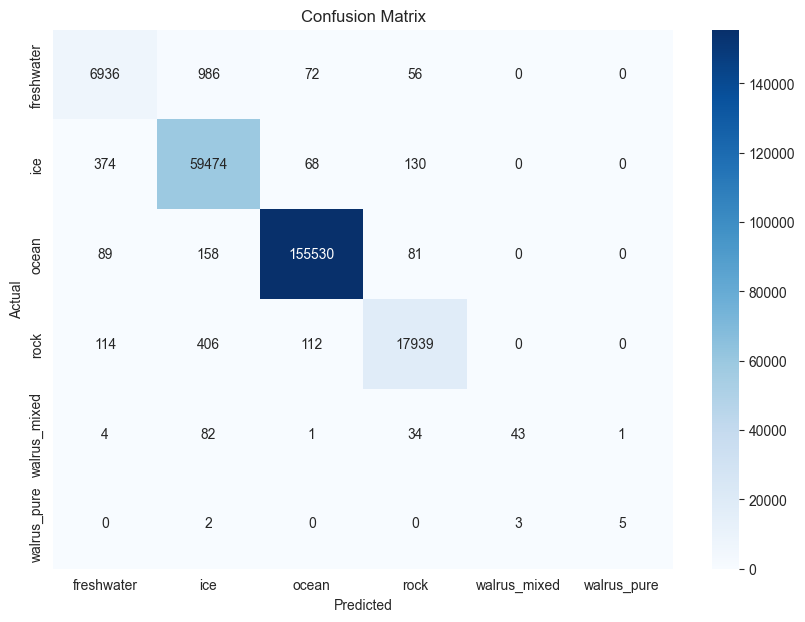

Accuracy: 0.99


In [29]:
# Evaluate the model
y_pred = model.predict(X_test)
labels = np.unique(y_train)  # Ensure labels are aligned with those in the training set
print(classification_report(y_test, y_pred, labels=labels, target_names=le.inverse_transform(labels)))

# Generate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=labels)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.inverse_transform(labels), yticklabels=le.inverse_transform(labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print accuracy
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
print(f"Accuracy: {accuracy:.2f}")

Labels present in buch_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


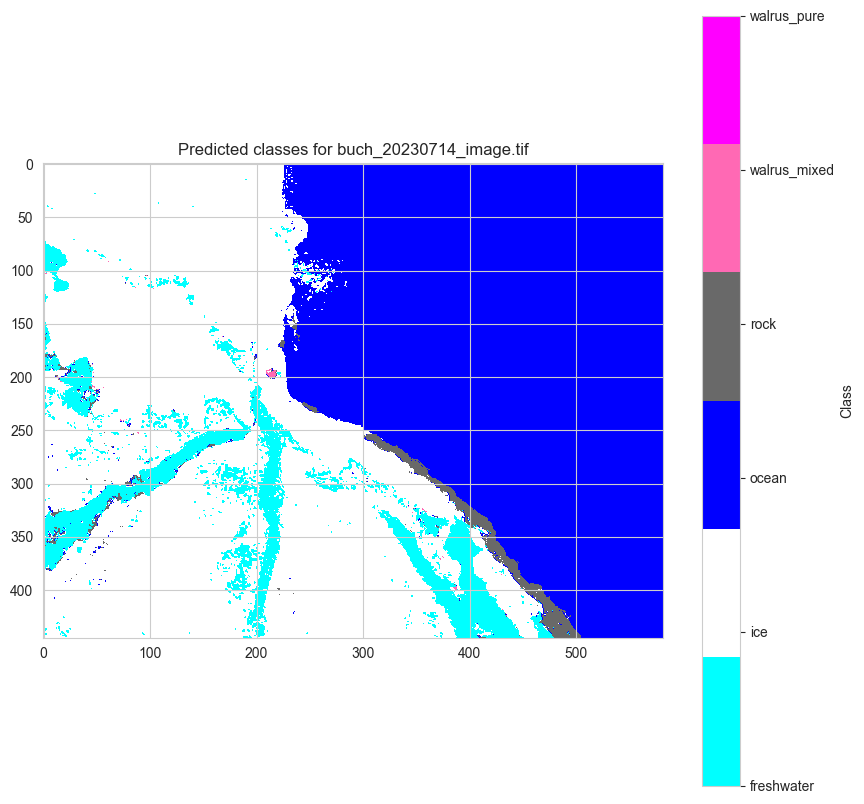

Labels present in buch_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


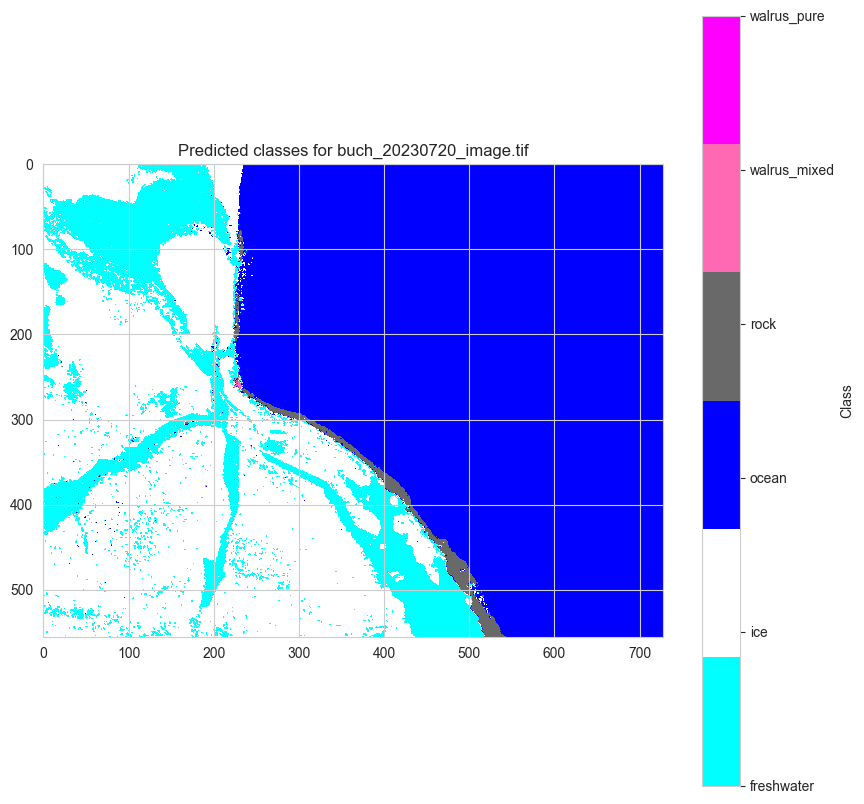

Labels present in buch_20230731_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


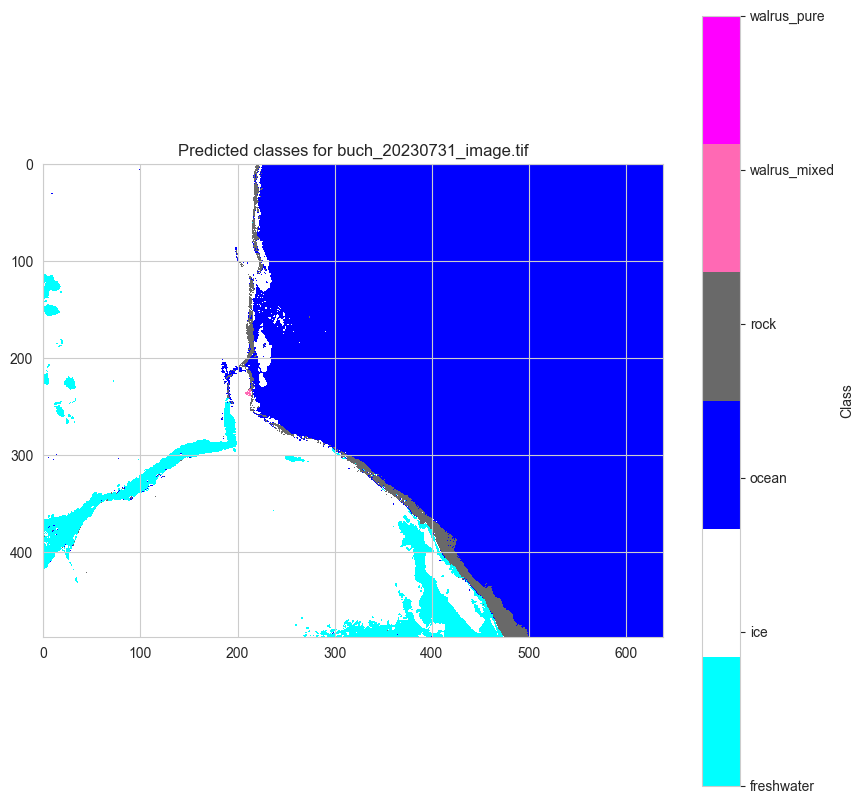

Labels present in buch_20230923_image.tif: ['freshwater', 'ice', 'ocean']


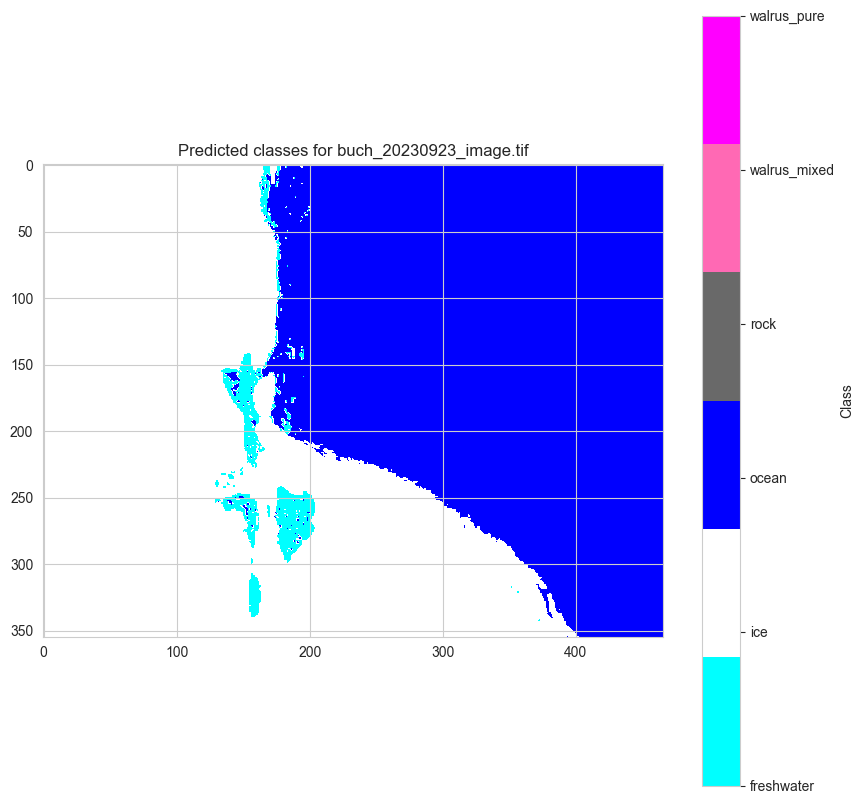

Labels present in moff_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


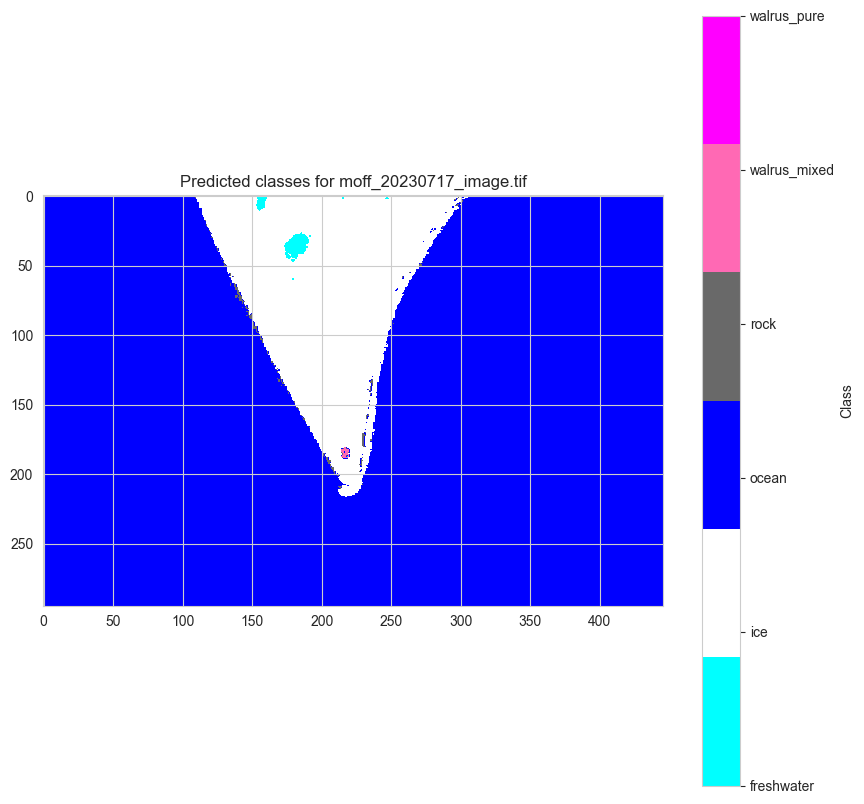

Labels present in pal_20230714_image.tif: ['ice', 'ocean', 'rock', 'walrus_mixed']


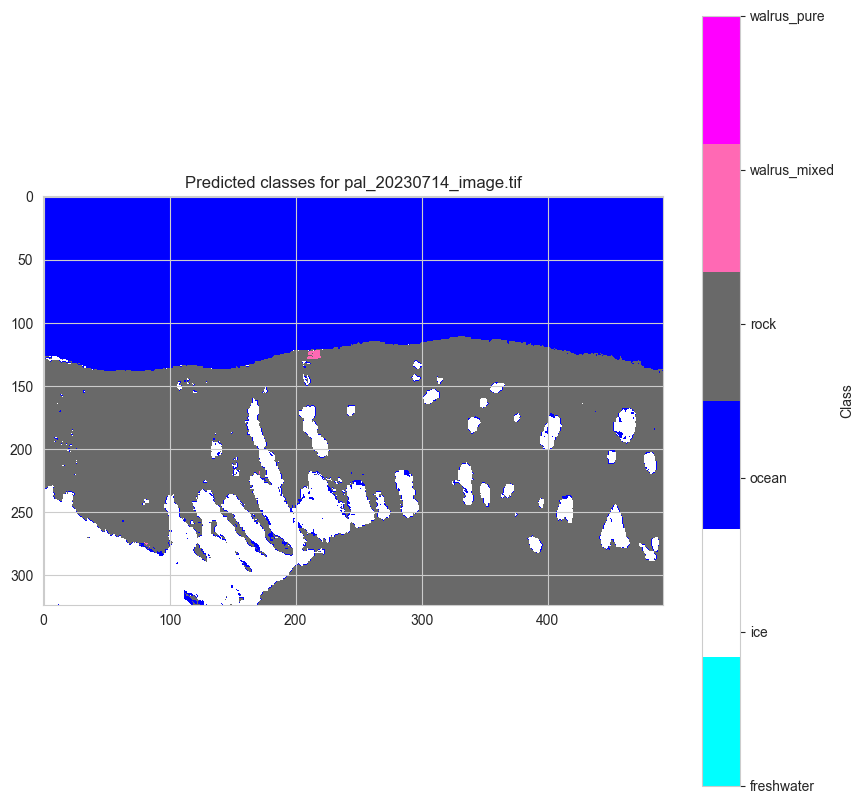

Labels present in pal_20230720_image.tif: ['ice', 'ocean', 'rock', 'walrus_mixed']


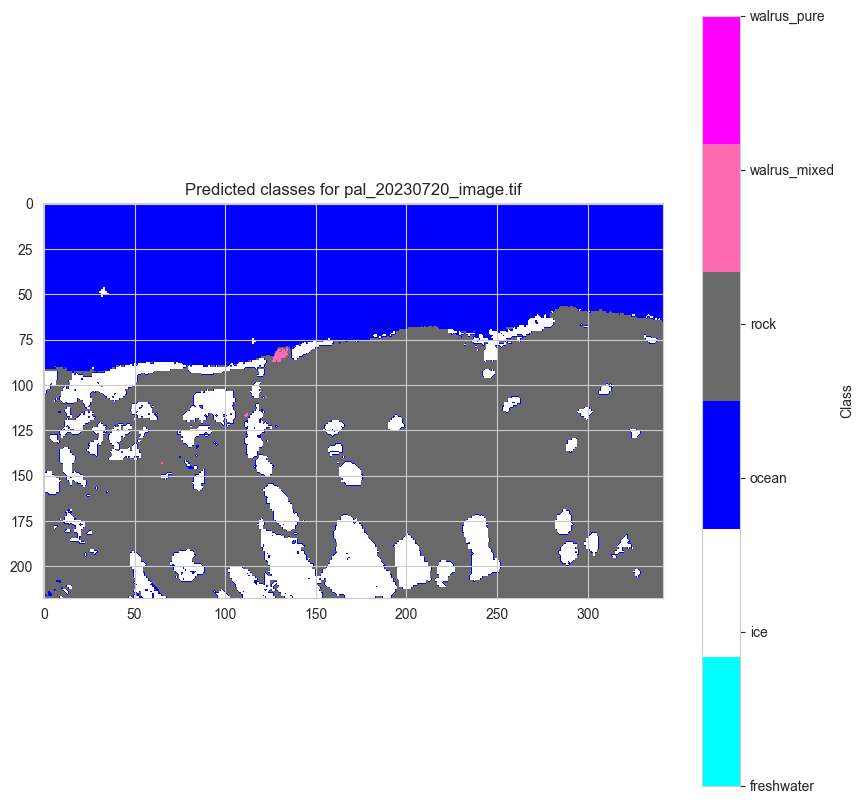

Labels present in pal_20230726_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


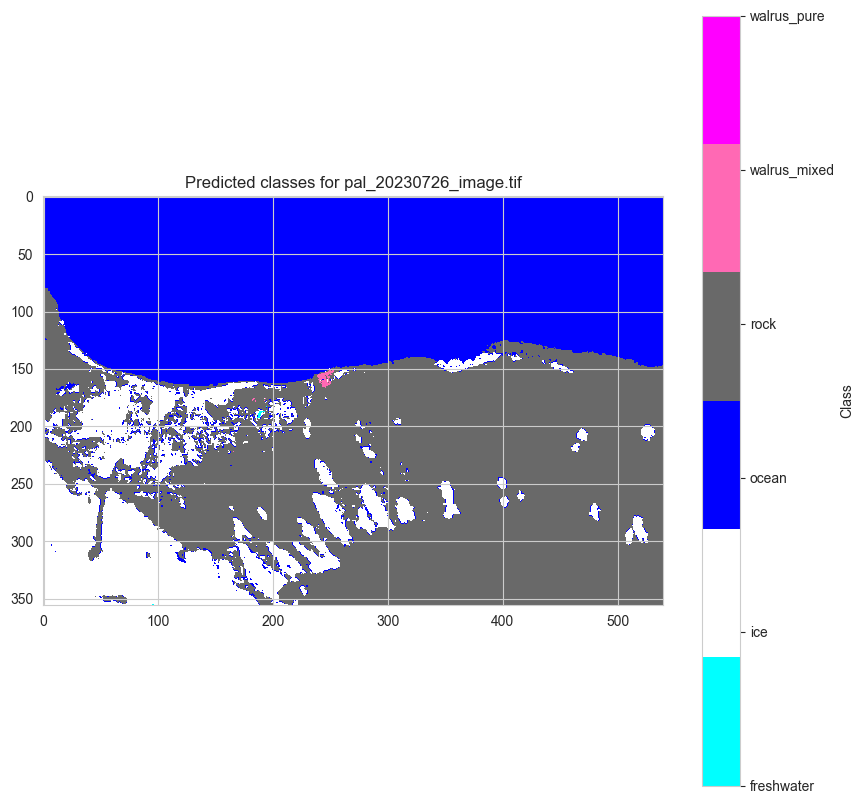

Labels present in sars_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


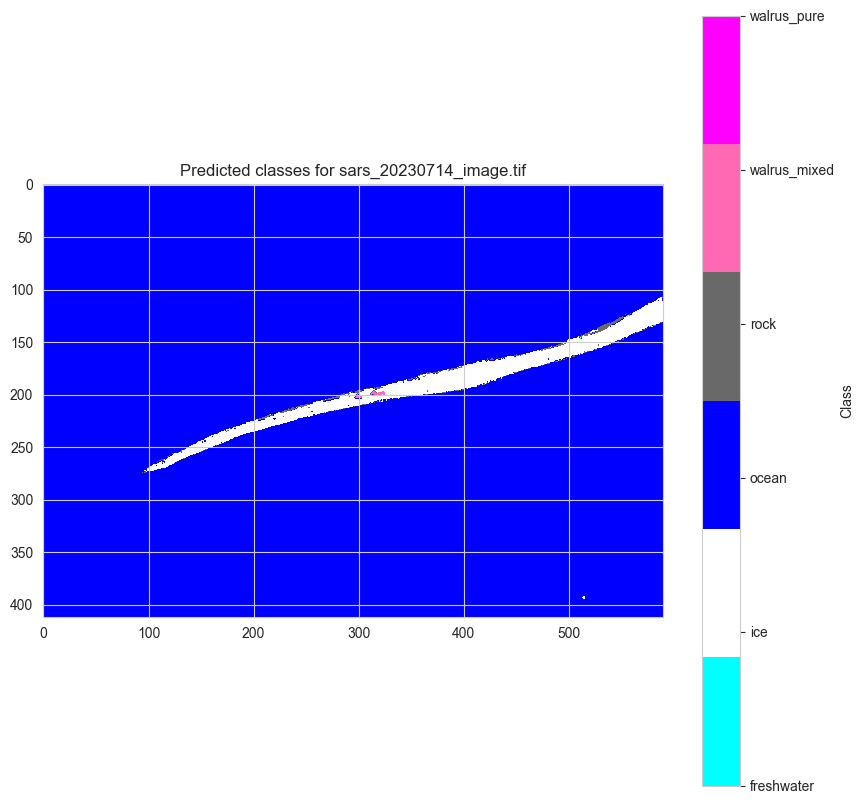

Labels present in sars_20230803_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


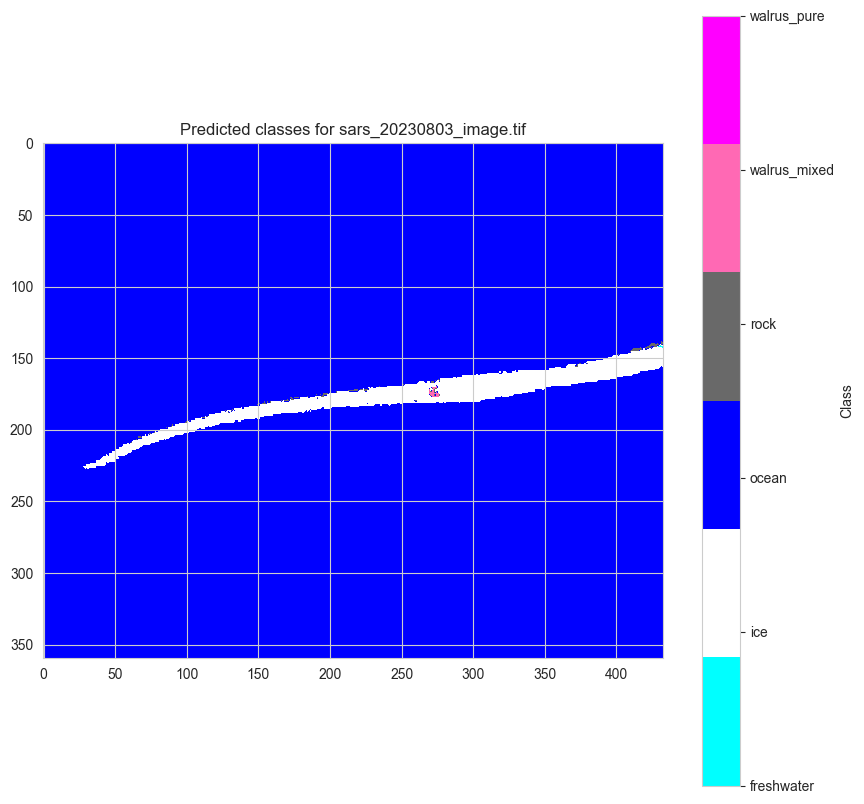

Labels present in tor_20230801_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


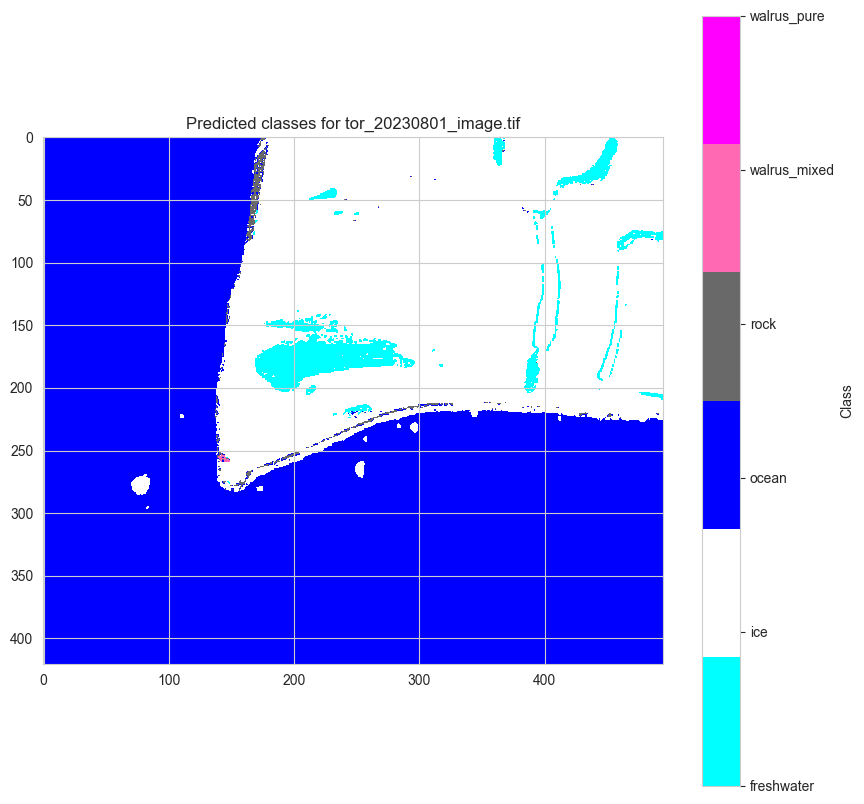

Labels present in tor_20230824_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


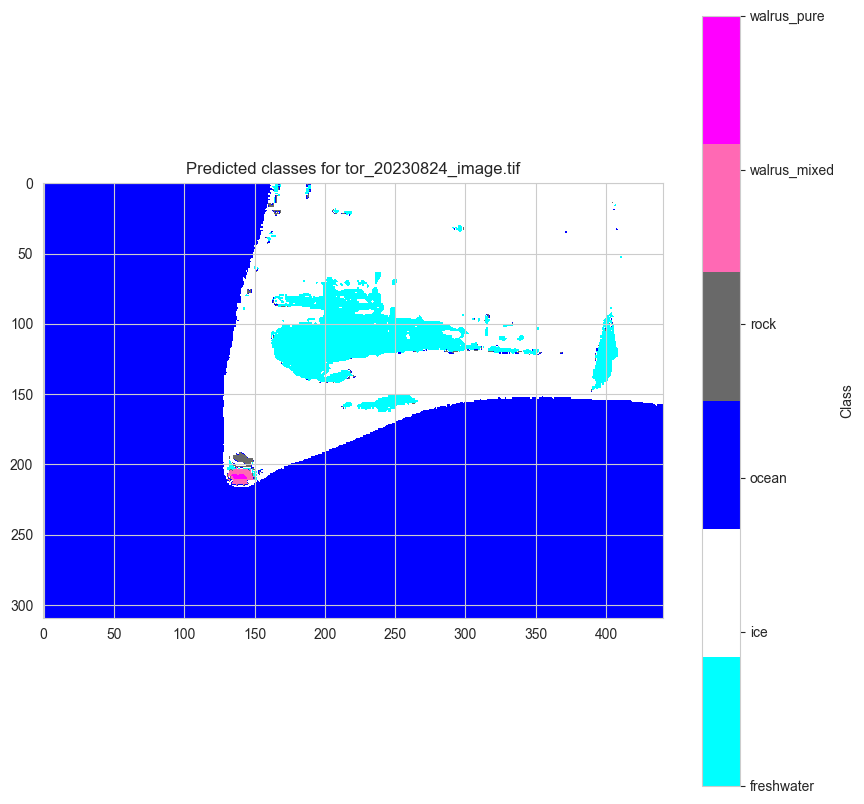

Labels present in tor_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


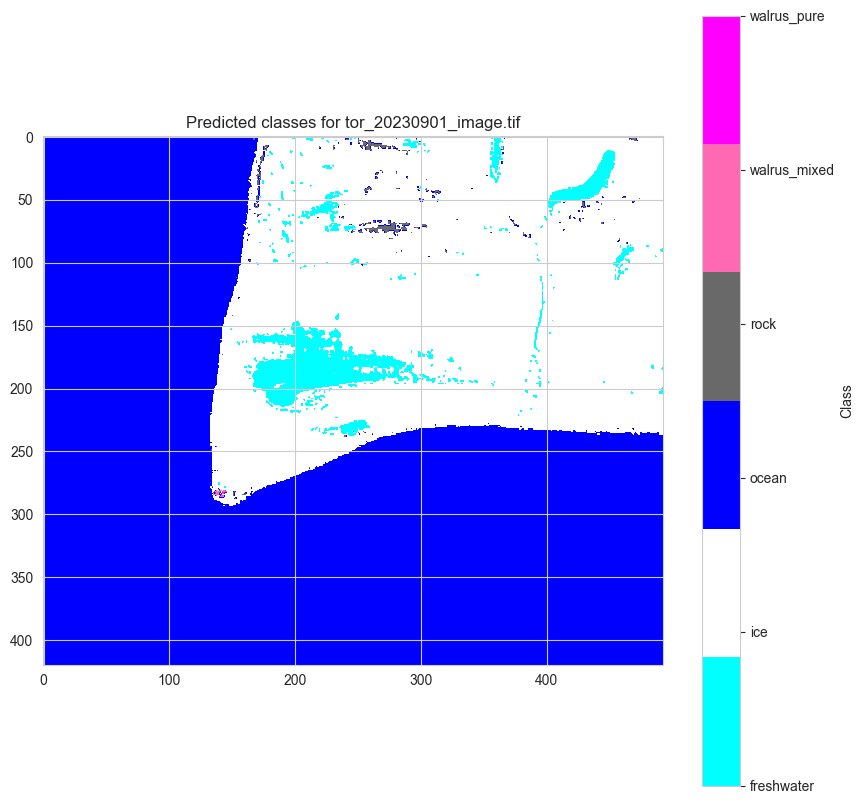

Labels present in tor_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


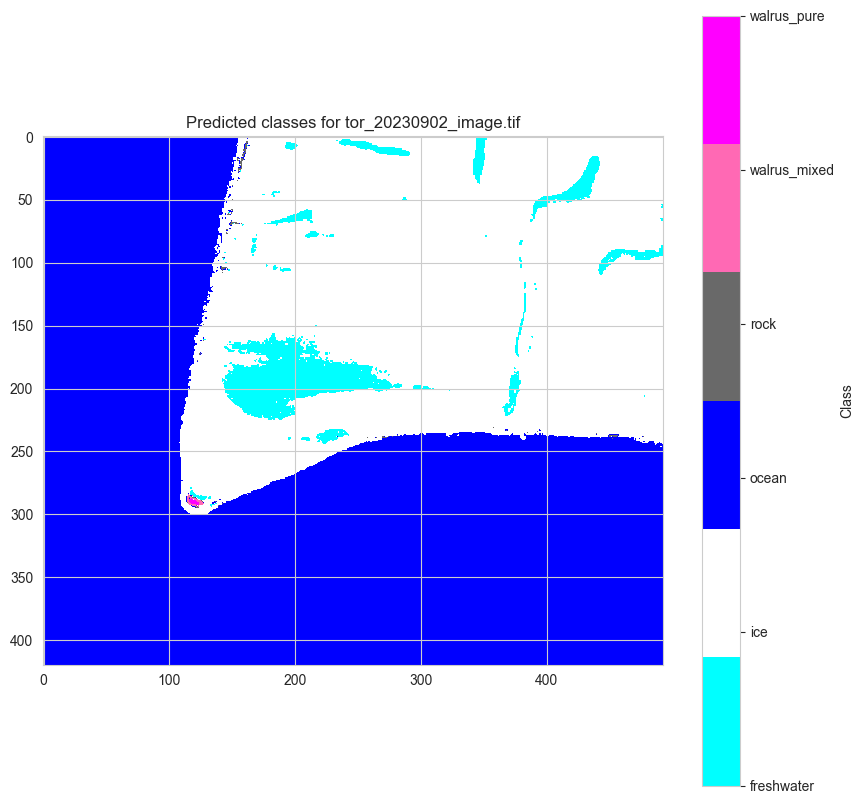

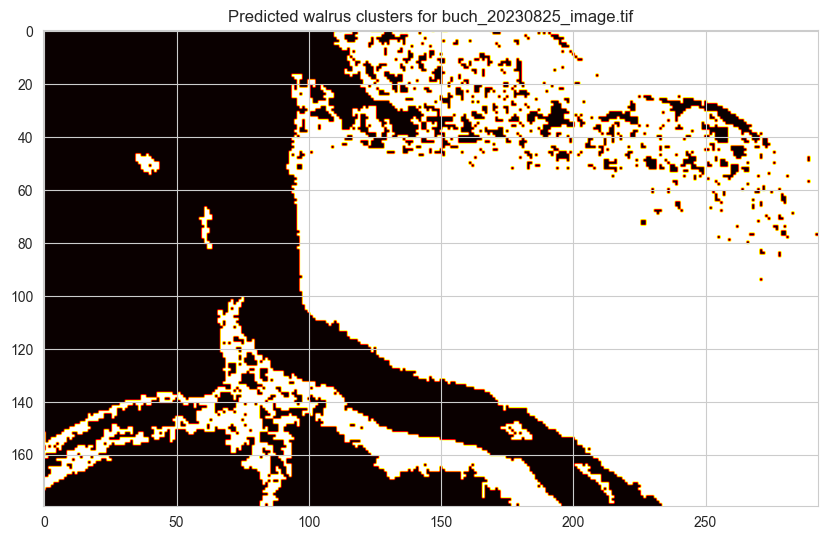

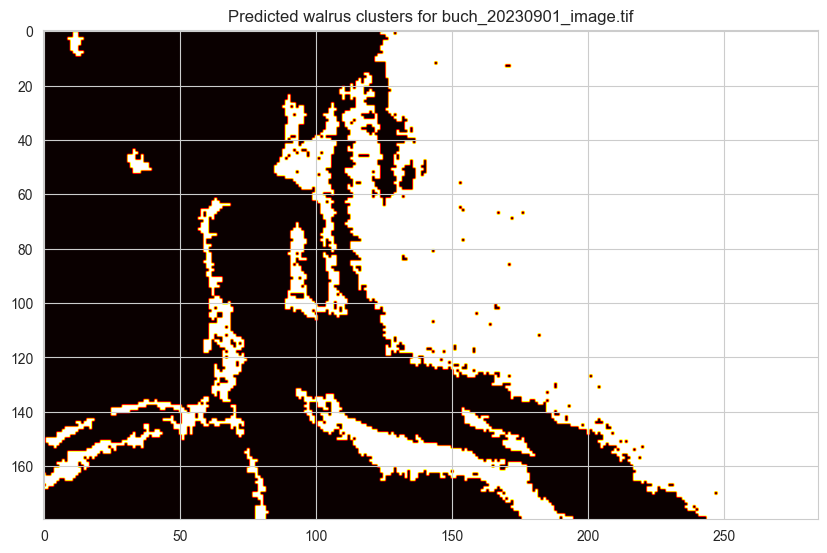

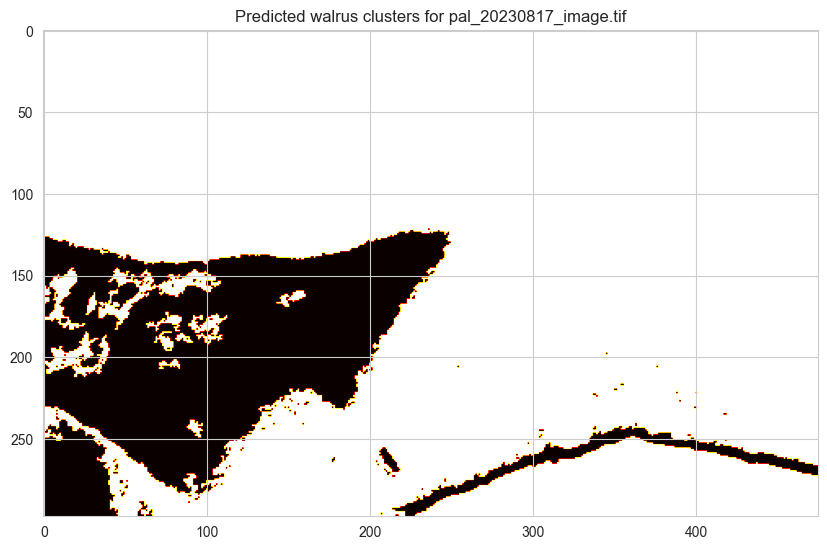

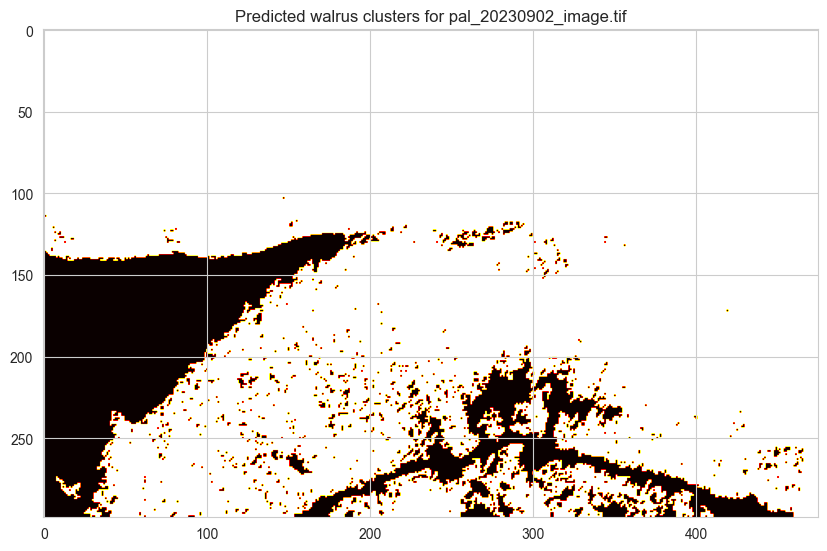

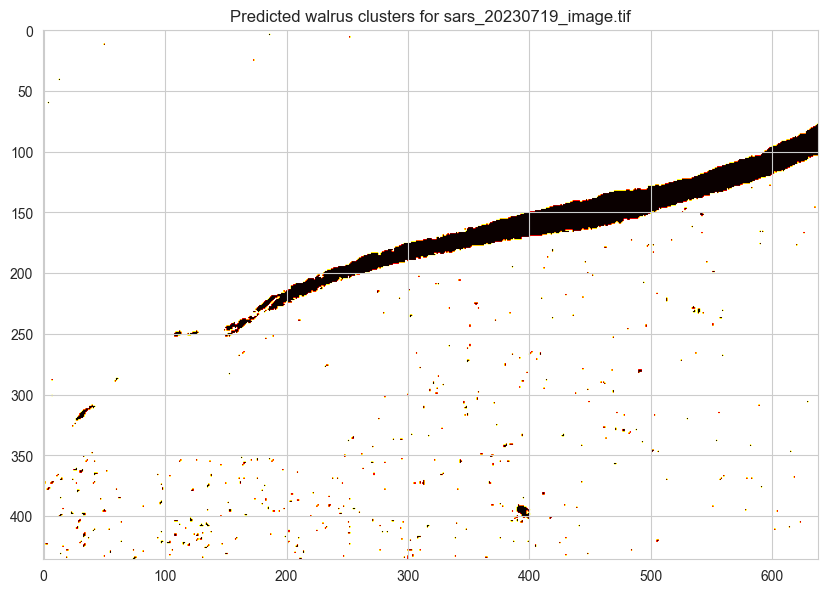

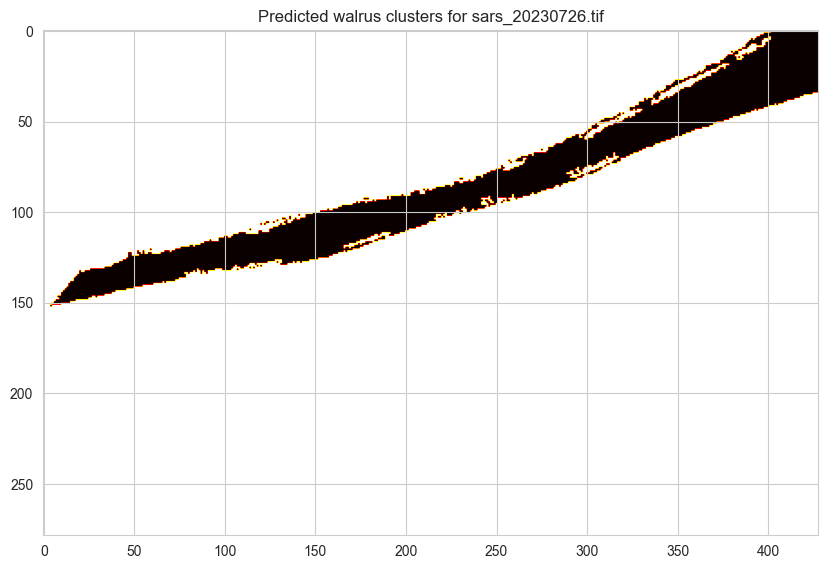

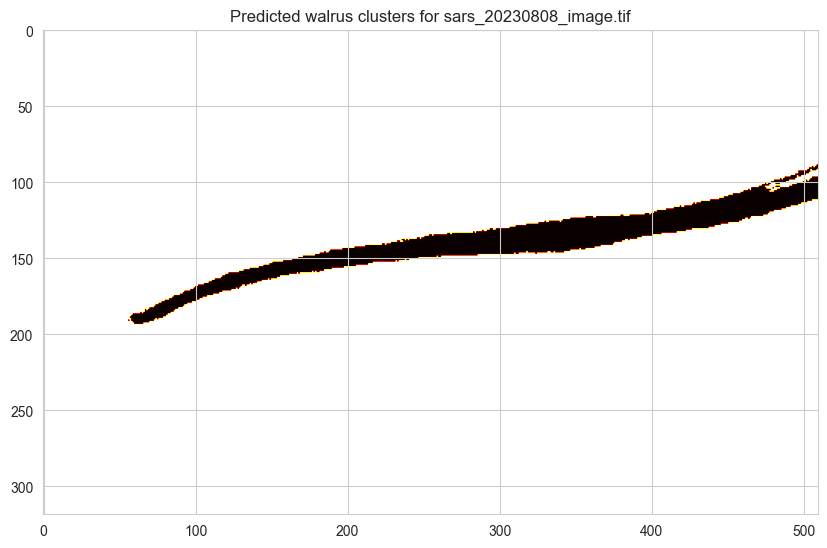

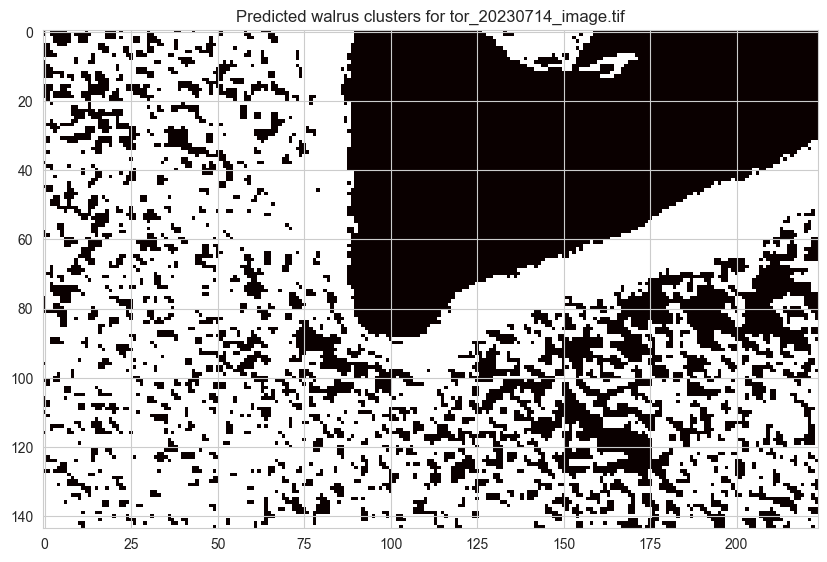

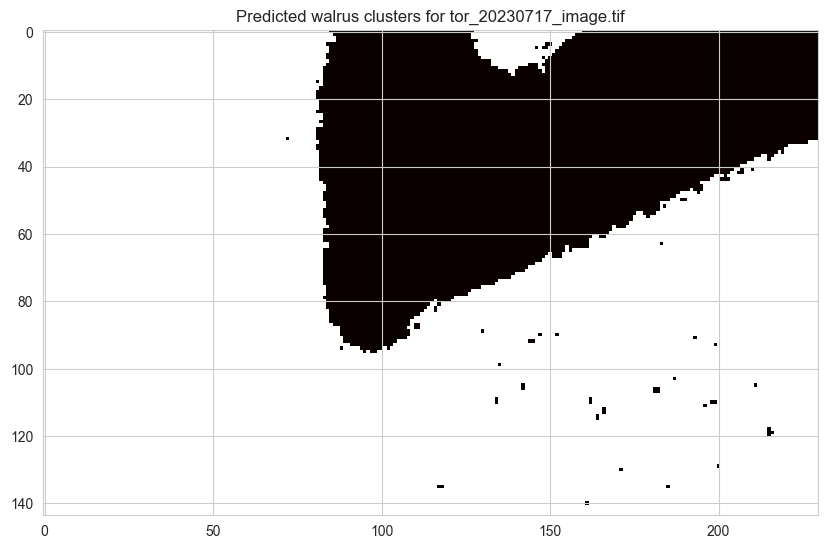

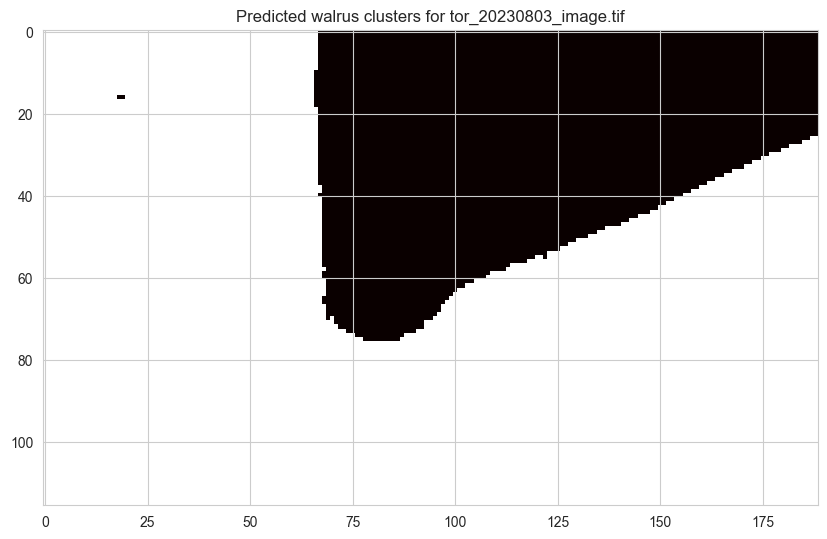

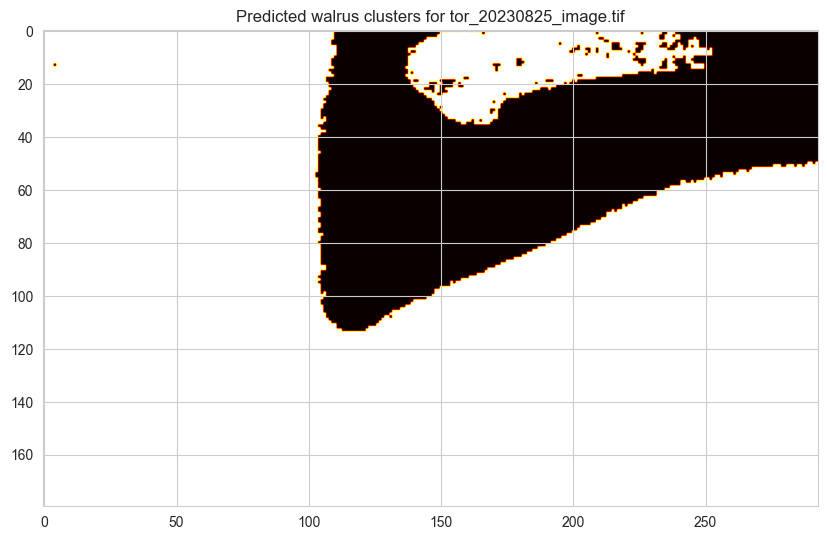

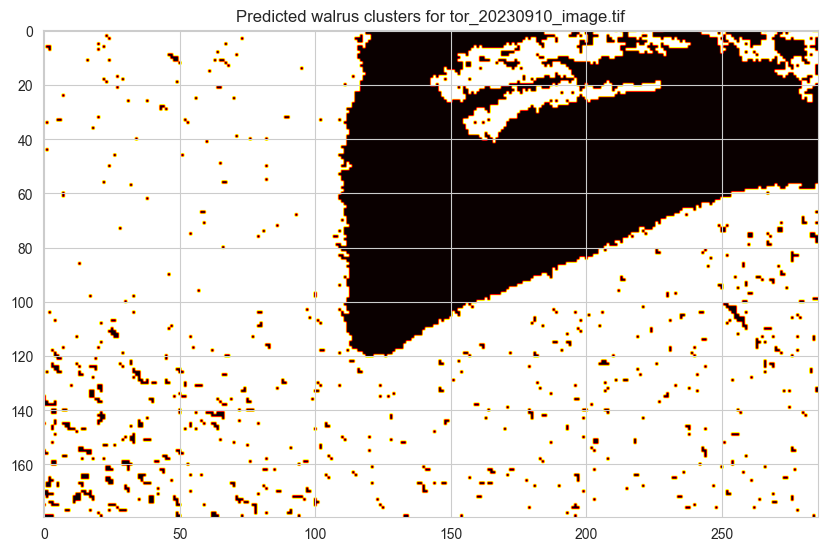

In [30]:
# Function to apply spatial rules and enforce proximity to ocean
def apply_spatial_rules_and_proximity(predicted_image, min_cluster_size=5, max_distance=15, min_ocean_freshwater_size=30):
    walrus_mask = (predicted_image == le.transform(['walrus_pure'])[0]) | (predicted_image == le.transform(['walrus_mixed'])[0])
    ocean_mask = (predicted_image == le.transform(['ocean'])[0])
    freshwater_mask = (predicted_image == le.transform(['freshwater'])[0])

    # Dilate ocean pixels to consider proximity
    dilated_ocean = binary_dilation(ocean_mask, iterations=max_distance)
    
    # Apply spatial rules
    walrus_clusters, num_walrus_features = label(walrus_mask)
    ocean_clusters, num_ocean_features = label(ocean_mask)
    freshwater_clusters, num_freshwater_features = label(freshwater_mask)
    
    valid_walrus_clusters = np.zeros_like(walrus_mask)
    valid_ocean_clusters = np.zeros_like(ocean_mask)
    valid_freshwater_clusters = np.zeros_like(freshwater_mask)
    
    for cluster_num in range(1, num_walrus_features + 1):
        cluster_pixels = walrus_clusters == cluster_num
        if np.sum(cluster_pixels) >= min_cluster_size and np.any(dilated_ocean & cluster_pixels):
            valid_walrus_clusters[cluster_pixels] = 1
    
    for cluster_num in range(1, num_ocean_features + 1):
        cluster_pixels = ocean_clusters == cluster_num
        if np.sum(cluster_pixels) >= min_ocean_freshwater_size:
            valid_ocean_clusters[cluster_pixels] = 1
            
    for cluster_num in range(1, num_freshwater_features + 1):
        cluster_pixels = freshwater_clusters == cluster_num
        if np.sum(cluster_pixels) >= min_ocean_freshwater_size:
            valid_freshwater_clusters[cluster_pixels] = 1
    
    final_mask = (valid_walrus_clusters == 1) | (valid_ocean_clusters == 1) | (valid_freshwater_clusters == 1)
    return final_mask

# Function to predict classes for a given image
def predict_image(image_path, model, feature_names):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        image_df = pd.DataFrame(image_reshaped, columns=feature_names)
        predictions = model.predict(image_df)
        return predictions.reshape((src.height, src.width))

predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, model, X.columns)

# Define a color map for the labels
label_colors = {'ice': 'white', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'hotpink', 'freshwater': 'cyan', 'ocean': 'blue'}

# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)

    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels

    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")

    plt.show()

# Load the saved model
loaded_model = joblib.load(model_filename)

# Predict and apply spatial rules for unseen images
for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, loaded_model, X.columns)
    final_mask = apply_spatial_rules_and_proximity(predicted_image)
    
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted walrus clusters for {os.path.basename(image_path)}")
    plt.imshow(final_mask, cmap='hot')
    plt.show()

In [ ]:
# Load the saved model
loaded_model = joblib.load(model_filename)

# Predict and apply spatial rules for unseen images
for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, loaded_model)
    final_mask = apply_spatial_rules_and_proximity(predicted_image)
    
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted walrus clusters for {os.path.basename(image_path)}")
    plt.imshow(final_mask, cmap='hot')
    plt.show()


In [1]:
import os
import re
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from rasterio.mask import geometry_mask
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from scipy.ndimage import label, binary_dilation
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import joblib

In [9]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    shapefile_path = matching_shapefiles[0]
    file_pairs[image_path] = shapefile_path

# Function to extract features and labels
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    img_name = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']

        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
            img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

features = []
labels = []
image_name = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)
    image_name.append(img_name)

features = np.vstack(features)
labels = np.hstack(labels)
image_name = np.hstack(image_name)
print(features, labels, image_name)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({'Coast_blue': features[:, 0],
                        'Blue': features[:, 1],
                        'Green1': features[:, 2],
                        'Green': features[:, 3],
                        'Yellow': features[:, 4],
                        'Red': features[:, 5],
                        'Red_edge': features[:, 6],
                        'NIR': features[:, 7],
                        'labels': labels,
                        'encoded_labels': encoded_labels,
                        'image_name': image_name})


No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif
[[1187  980 1269 ... 1329 1416 1650]
 [1148  912 1212 ... 1240 1297 1612]
 [1131  856 1162 ... 1181 1355 1510]
 ...
 [1730 1870 1929 ... 2091 2276 2647]
 [1634 1851 1879 ... 2053 2281 2634]
 [1720 1904 1905 ... 2135 2316 2654]] ['walrus_mixed' 'walrus_mixed' 'walrus_mixed' ... 'freshwater'
 'freshwater' 'freshwater'] ['C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 ...
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_ima

In [12]:
 #Ensure every class is present in the training data
def ensure_all_classes_in_training(dataset, labels_column):
    unique_labels = dataset[labels_column].unique()
    required_indices = []
    for label in unique_labels:
        label_indices = dataset[dataset[labels_column] == label].index
        if len(label_indices) > 0:
            required_indices.append(label_indices[0])
    return required_indices

required_indices = ensure_all_classes_in_training(dataset, 'encoded_labels')
training_indices = dataset.index.isin(required_indices) | dataset['image_name'].isin(dataset['image_name'].unique())

# Ensure all walrus pixels are included
walrus_indices = dataset[dataset['labels'].isin(['walrus_pure', 'walrus_mixed'])].index
training_indices = training_indices | dataset.index.isin(walrus_indices)

# Ensure at least one image from each island is included
islands = dataset['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
training_images = set(dataset['image_name'][training_indices])
for island in islands:
    island_images = [img for img in image_paths if extract_island_and_date(os.path.basename(img))[0] == island]
    if not any(img in training_images for img in island_images):
        training_indices |= dataset['image_name'].isin(island_images[:1])

In [13]:
X_train = dataset[training_indices].drop(columns=['labels', 'encoded_labels', 'image_name'])
y_train = dataset[training_indices]['encoded_labels']
X_test = dataset[~training_indices].drop(columns=['labels', 'encoded_labels', 'image_name'])
y_test = dataset[~training_indices]['encoded_labels']

# Print the number of pixels in each class for the training data before training the model
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(le.inverse_transform(unique), counts))
print("Number of pixels in each class for the training data:", class_counts)


Number of pixels in each class for the training data: {'freshwater': 40251, 'ice': 300231, 'ocean': 779288, 'rock': 92856, 'walrus_mixed': 822, 'walrus_pure': 48}


In [14]:
# Define class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(encoded_labels), y=encoded_labels)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

# Train the cost-sensitive RandomForest model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight_dict)
model.fit(X_train, y_train)

# Save the model
model_filename = "RF_ALL_conditions.joblib"
joblib.dump(model, model_filename)

['RF_ALL_conditions.joblib']

In [15]:
# Evaluate the model
y_pred = model.predict(X_test)
labels = np.unique(y_train)  # Ensure labels are aligned with those in the training set
print(classification_report(y_test, y_pred, labels=labels, target_names=le.inverse_transform(labels)))

# Generate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=labels)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.inverse_transform(labels), yticklabels=le.inverse_transform(labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print accuracy
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
print(f"Accuracy: {accuracy:.2f}")

ValueError: Found array with 0 sample(s) (shape=(0, 8)) while a minimum of 1 is required by RandomForestClassifier.

In [ ]:
# Function to apply spatial rules and enforce proximity to ocean
def apply_spatial_rules_and_proximity(predicted_image, min_cluster_size=5, max_distance=15, min_ocean_freshwater_size=30):
    walrus_mask = (predicted_image == le.transform(['walrus_pure'])[0]) | (predicted_image == le.transform(['walrus_mixed'])[0])
    ocean_mask = (predicted_image == le.transform(['ocean'])[0])
    freshwater_mask = (predicted_image == le.transform(['freshwater'])[0])

    # Dilate ocean pixels to consider proximity
    dilated_ocean = binary_dilation(ocean_mask, iterations=max_distance)
    
    # Apply spatial rules
    walrus_clusters, num_walrus_features = label(walrus_mask)
    ocean_clusters, num_ocean_features = label(ocean_mask)
    freshwater_clusters, num_freshwater_features = label(freshwater_mask)
    
    valid_walrus_clusters = np.zeros_like(walrus_mask)
    valid_ocean_clusters = np.zeros_like(ocean_mask)
    valid_freshwater_clusters = np.zeros_like(freshwater_mask)
    
    for cluster_num in range(1, num_walrus_features + 1):
        cluster_pixels = walrus_clusters == cluster_num
        if np.sum(cluster_pixels) >= min_cluster_size and np.any(dilated_ocean & cluster_pixels):
            valid_walrus_clusters[cluster_pixels] = 1
    
    for cluster_num in range(1, num_ocean_features + 1):
        cluster_pixels = ocean_clusters == cluster_num
        if np.sum(cluster_pixels) >= min_ocean_freshwater_size:
            valid_ocean_clusters[cluster_pixels] = 1
            
    for cluster_num in range(1, num_freshwater_features + 1):
        cluster_pixels = freshwater_clusters == cluster_num
        if np.sum(cluster_pixels) >= min_ocean_freshwater_size:
            valid_freshwater_clusters[cluster_pixels] = 1
    
    final_mask = (valid_walrus_clusters == 1) | (valid_ocean_clusters == 1) | (valid_freshwater_clusters == 1)
    return final_mask

# Function to predict classes for a given image
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))

predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, model)


In [ ]:
# Define a color map for the labels
label_colors = {'ice': 'white', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'hotpink', 'freshwater': 'cyan', 'ocean': 'blue'}

# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)

    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels

    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")

    plt.show()

In [ ]:
# Load the saved model
loaded_model = joblib.load(model_filename)

# Predict and apply spatial rules for unseen images
for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, loaded_model)
    final_mask = apply_spatial_rules_and_proximity(predicted_image)
    
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted walrus clusters for {os.path.basename(image_path)}")
    plt.imshow(final_mask, cmap='hot')
    plt.show()


In [27]:
import os
import re
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from rasterio.mask import geometry_mask
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from scipy.ndimage import label, binary_dilation
from sklearn.utils.class_weight import compute_class_weight
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [28]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    shapefile_path = matching_shapefiles[0]
    file_pairs[image_path] = shapefile_path

# Function to extract features and labels
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    img_name = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']

        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
            img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

features = []
labels = []
image_name = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)
    image_name.append(img_name)

features = np.vstack(features)
labels = np.hstack(labels)
image_name = np.hstack(image_name)
print(features, labels, image_name)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({'Coast_blue': features[:, 0],
                        'Blue': features[:, 1],
                        'Green1': features[:, 2],
                        'Green': features[:, 3],
                        'Yellow': features[:, 4],
                        'Red': features[:, 5],
                        'Red_edge': features[:, 6],
                        'NIR': features[:, 7],
                        'labels': labels,
                        'encoded_labels': encoded_labels,
                        'image_name': image_name})


No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif
[[1187  980 1269 ... 1329 1416 1650]
 [1148  912 1212 ... 1240 1297 1612]
 [1131  856 1162 ... 1181 1355 1510]
 ...
 [1730 1870 1929 ... 2091 2276 2647]
 [1634 1851 1879 ... 2053 2281 2634]
 [1720 1904 1905 ... 2135 2316 2654]] ['walrus_mixed' 'walrus_mixed' 'walrus_mixed' ... 'freshwater'
 'freshwater' 'freshwater'] ['C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 ...
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_ima

In [34]:
# Ensure every class is present in the training data
def ensure_all_classes_in_training(dataset, labels_column):
    unique_labels = dataset[labels_column].unique()
    required_indices = []
    for label in unique_labels:
        label_indices = dataset[dataset[labels_column] == label].index
        if len(label_indices) > 0:
            required_indices.append(label_indices[0])
    return required_indices

required_indices = ensure_all_classes_in_training(dataset, 'encoded_labels')
training_indices = dataset.index.isin(required_indices) | dataset['image_name'].isin(training_images)

# Ensure all walrus pixels are included
walrus_indices = dataset[dataset['labels'].isin(['walrus_pure', 'walrus_mixed'])].index
training_indices = training_indices | dataset.index.isin(walrus_indices)

# Ensure at least one image from each island is included
islands = dataset['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
training_images = set(dataset['image_name'][training_indices])
for island in islands:
    island_images = [img for img in image_paths if extract_island_and_date(os.path.basename(img))[0] == island]
    if not any(img in training_images for img in island_images):
        training_indices |= dataset['image_name'].isin(island_images[:1])

In [35]:
X_train = dataset[training_indices].drop(columns=['labels', 'encoded_labels', 'image_name'])
y_train = dataset[training_indices]['encoded_labels']
X_test = dataset[~training_indices].drop(columns=['labels', 'encoded_labels', 'image_name'])
y_test = dataset[~training_indices]['encoded_labels']

# Print the number of pixels in each class for the training data before training the model
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(le.inverse_transform(unique), counts))
print("Number of pixels in each class for the training data:", class_counts)

Number of pixels in each class for the training data: {'freshwater': 38688, 'ice': 262292, 'ocean': 744263, 'rock': 92856, 'walrus_mixed': 822, 'walrus_pure': 48}


In [36]:
# Define class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(encoded_labels), y=encoded_labels)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

# Train the cost-sensitive RandomForest model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight_dict)
model.fit(X_train, y_train)

# Save the model
model_filename = "RF_ALL_conditions.joblib"
joblib.dump(model, model_filename)

['RF_ALL_conditions.joblib']

In [37]:
# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Generate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=np.unique(y_train))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=le.inverse_transform(np.unique(y_train)))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print accuracy
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
print(f"Accuracy: {accuracy:.2f}")

ValueError: Number of classes, 3, does not match size of target_names, 6. Try specifying the labels parameter

In [ ]:
# Function to apply spatial rules and enforce proximity to ocean
def apply_spatial_rules_and_proximity(predicted_image, ocean_pixels, min_cluster_size=5, max_distance=16, min_ocean_freshwater_size=30):
    walrus_mask = (predicted_image == le.transform(['walrus_pure'])[0]) | (predicted_image == le.transform(['walrus_mixed'])[0])
    ocean_mask = (predicted_image == le.transform(['ocean'])[0])
    freshwater_mask = (predicted_image == le.transform(['freshwater'])[0])

    # Dilate ocean pixels to consider proximity
    dilated_ocean = binary_dilation(ocean_mask, iterations=max_distance)
    
    # Apply spatial rules
    walrus_clusters, num_walrus_features = label(walrus_mask)
    ocean_clusters, num_ocean_features = label(ocean_mask)
    freshwater_clusters, num_freshwater_features = label(freshwater_mask)
    
    valid_walrus_clusters = np.zeros_like(walrus_mask)
    valid_ocean_clusters = np.zeros_like(ocean_mask)
    valid_freshwater_clusters = np.zeros_like(freshwater_mask)
    
    for cluster_num in range(1, num_walrus_features + 1):
        cluster_pixels = walrus_clusters == cluster_num
        if np.sum(cluster_pixels) >= min_cluster_size and np.any(dilated_ocean & cluster_pixels):
            valid_walrus_clusters[cluster_pixels] = 1
    
    for cluster_num in range(1, num_ocean_features + 1):
        cluster_pixels = ocean_clusters == cluster_num
        if np.sum(cluster_pixels) >= min_ocean_freshwater_size:
            valid_ocean_clusters[cluster_pixels] = 1
            
    for cluster_num in range(1, num_freshwater_features + 1):
        cluster_pixels = freshwater_clusters == cluster_num
        if np.sum(cluster_pixels) >= min_ocean_freshwater_size:
            valid_freshwater_clusters[cluster_pixels] = 1
    
    final_mask = (valid_walrus_clusters == 1) | (valid_ocean_clusters == 1) | (valid_freshwater_clusters == 1)
    return final_mask

In [ ]:
# Plot the predictions on the training images
for image_path in file_pairs.keys():
    predicted_image = predict_image(image_path, model, walrus_pure_spectral, walrus_mixed_spectral)
    with rasterio.open(image_path) as src:
        image = src.read()
        ocean_pixels = image[0] == le.transform(['ocean'])[0]
    final_mask = apply_spatial_rules_and_proximity(predicted_image, ocean_pixels)
    
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(final_mask, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    plt.show()

In [ ]:
# Load the saved model
loaded_model = joblib.load(model_filename)

In [ ]:
# Predict and apply spatial rules for unseen images
for image_path in unlabeled_image_paths:
    with rasterio.open(image_path) as src:
        image = src.read()
        ocean_pixels = image[0] == le.transform(['ocean'])[0]  # Assuming ocean is represented in the first band
        predicted_image = predict_image(image_path, loaded_model, walrus_pure_spectral, walrus_mixed_spectral)
        final_mask = apply_spatial_rules_and_proximity(predicted_image, ocean_pixels)
    
        plt.figure(figsize=(10, 10))
        plt.title(f"Predicted walrus clusters for {os.path.basename(image_path)}")
        plt.imshow(final_mask, cmap='hot')
        plt.show()

In [29]:
# Extract spectral signatures for walrus pixels
walrus_pure_spectral = dataset[dataset['labels'] == 'walrus_pure'][['Coast_blue', 'Blue', 'Green1', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR']].mean().values
walrus_mixed_spectral = dataset[dataset['labels'] == 'walrus_mixed'][['Coast_blue', 'Blue', 'Green1', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR']].mean().values

# Add the spectral signature difference as features
def add_spectral_signature_features(df, pure_spectral, mixed_spectral):
    pure_diff = np.linalg.norm(df[['Coast_blue', 'Blue', 'Green1', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR']].values - pure_spectral, axis=1)
    mixed_diff = np.linalg.norm(df[['Coast_blue', 'Blue', 'Green1', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR']].values - mixed_spectral, axis=1)
    df['pure_diff'] = pure_diff
    df['mixed_diff'] = mixed_diff
    return df



In [30]:
# Extract spectral signatures for walrus pixels
walrus_pure_spectral = dataset[dataset['labels'] == 'walrus_pure'][['Coast_blue', 'Blue', 'Green1', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR']].mean().values
walrus_mixed_spectral = dataset[dataset['labels'] == 'walrus_mixed'][['Coast_blue', 'Blue', 'Green1', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR']].mean().values

# Add the spectral signature difference as features
def add_spectral_signature_features(df, pure_spectral, mixed_spectral):
    pure_diff = np.linalg.norm(df[['Coast_blue', 'Blue', 'Green1', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR']].values - pure_spectral, axis=1)
    mixed_diff = np.linalg.norm(df[['Coast_blue', 'Blue', 'Green1', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR']].values - mixed_spectral, axis=1)
    df['pure_diff'] = pure_diff
    df['mixed_diff'] = mixed_diff
    return df

dataset = add_spectral_signature_features(dataset, walrus_pure_spectral, walrus_mixed_spectral)


In [31]:
# Identify images with walrus pixels
walrus_images = dataset[dataset['labels'].isin(['walrus_pure', 'walrus_mixed'])]['image_name'].unique()

# Ensure island coverage
islands = dataset['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
training_images = set(walrus_images)

# Add at least one image from each island to the training set
for island in islands:
    island_images = [img for img in image_paths if extract_island_and_date(os.path.basename(img))[0] == island]
    if not any(img in training_images for img in island_images):
        training_images.add(island_images[0])

# Split dataset into training and test sets based on selected images
training_indices = dataset['image_name'].apply(lambda x: x in training_images)
X_train = dataset[training_indices].drop(columns=['labels', 'encoded_labels', 'image_name'])
y_train = dataset[training_indices]['encoded_labels']
X_test = dataset[~training_indices].drop(columns=['labels', 'encoded_labels', 'image_name'])
y_test = dataset[~training_indices]['encoded_labels']


In [32]:
# Define class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(encoded_labels), y=encoded_labels)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

# Train the cost-sensitive RandomForest model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight_dict)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 5.024703320000331,
                                     1: 0.6736457372267798,
                                     2: 0.25953092224355223,
                                     3: 2.178096550931909,
                                     4: 246.04541768045416,
                                     5: 4213.527777777777},
                       random_state=42)

In [33]:
# Save the model
model_filename = "RF_ALL_conditions.joblib"
joblib.dump(model, model_filename)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

ValueError: Number of classes, 3, does not match size of target_names, 6. Try specifying the labels parameter

In [ ]:
# Print the number of pixels in each class for the training data
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(le.inverse_transform(unique), counts))
print("Number of pixels in each class for the training data:", class_counts)

# Function to predict classes for a given image
def predict_image(image_path, model, pure_spectral, mixed_spectral):
    with rasterio.open(image_path) as src:
        image = src.read()
        height, width = src.height, src.width
        coords = np.array([(x, y) for y in range(image.shape[1]) for x in range(image.shape[2])])
        
    image_reshaped = image.reshape((image.shape[0], -1)).T
    image_df = pd.DataFrame(image_reshaped, columns=['Coast_blue', 'Blue', 'Green1', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR'])
    image_df[['x_coord', 'y_coord']] = coords
    image_df = add_spectral_signature_features(image_df, pure_spectral, mixed_spectral)

    predictions = model.predict(image_df)
    return predictions.reshape((height, width))

predicted_images = {}

for image_path in file_pairs.keys():
    predicted_images[image_path] = predict_image(image_path, model, walrus_pure_spectral, walrus_mixed_spectral)


In [ ]:
# Define a color map for the labels
label_colors = {'ice': 'whitesmoke', 'rock': 'dimgray', 'walrus_pure': 'mediumorchid', 'walrus_mixed': 'hotpink', 'freshwater': 'aquamarine', 'ocean': 'cornflowerblue'}
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)
    
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred, labels=np.unique(y_train))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Function to apply spatial rules and enforce proximity to ocean
def apply_spatial_rules_and_proximity(predicted_image, ocean_pixels, min_cluster_size=5, max_distance=16):
    labeled_array, num_features = label(predicted_image)
    walrus_clusters = np.zeros_like(predicted_image)
    
    # Dilate ocean pixels to consider proximity
    dilated_ocean = binary_dilation(ocean_pixels, iterations=max_distance)
    
    for cluster_num in range(1, num_features + 1):
        cluster_size = np.sum(labeled_array == cluster_num)
        if cluster_size >= min_cluster_size:
            cluster_pixels = labeled_array == cluster_num
            if np.any(dilated_ocean & cluster_pixels):  # Check if any cluster pixel is near ocean
                walrus_clusters[cluster_pixels] = 1
                
    return walrus_clusters

In [ ]:
# Load the saved model
loaded_model = joblib.load(model_filename)

# Predict and apply spatial rules for unlabeled images
for image_path in unlabeled_image_paths:
    with rasterio.open(image_path) as src:
        image = src.read()
        ocean_pixels = image[0] == le.transform(['ocean'])[0]  # Assuming ocean is represented in the first band
        predicted_image = predict_image(image_path, loaded_model, walrus_pure_spectral, walrus_mixed_spectral)
        walrus_clusters = apply_spatial_rules_and_proximity(predicted_image == le.transform(['walrus_pure'])[0], ocean_pixels)
        walrus_clusters |= apply_spatial_rules_and_proximity(predicted_image == le.transform(['walrus_mixed'])[0], ocean_pixels)
    
        plt.figure(figsize=(10, 10))
        plt.title(f"Predicted walrus clusters for {os.path.basename(image_path)}")
        plt.imshow(walrus_clusters, cmap='hot')
        plt.show()


NameError: name 'class_weight_dict' is not defined

NameError: name 'model' is not defined

In [11]:
import os
import re
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import joblib
from rasterio.mask import geometry_mask
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import DBSCAN
from scipy.ndimage import label
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize


In [12]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    shapefile_path = matching_shapefiles[0]
    file_pairs[image_path] = shapefile_path

# Function to extract features and labels
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform
        coords = np.array([(x, y) for x in range(image.shape[2]) for y in range(image.shape[1])])
    
    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    img_name = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']
        coord_pixels = coords[mask.ravel()]

        for pixel, coord in zip(feature_pixels.T, coord_pixels):  # Transpose to iterate over pixels
            features.append(np.append(pixel, coord))
            labels.append(label)
            img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

features = []
labels = []
image_name = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)
    image_name.append(img_name)

features = np.vstack(features)
labels = np.hstack(labels)
image_name = np.hstack(image_name)
print(features, labels, image_name)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({'Coast_blue': features[:, 0],
                        'Blue': features[:, 1],
                        'Green1': features[:, 2],
                        'Green': features[:, 3],
                        'Yellow': features[:, 4],
                        'Red': features[:, 5],
                        'Red_edge': features[:, 6],
                        'NIR': features[:, 7],
                        'labels': labels,
                        'encoded_labels': encoded_labels,
                        'image_name': image_name})


No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif
[[1187  980 1269 ... 1650  250  126]
 [1148  912 1212 ... 1612  251  263]
 [1131  856 1162 ... 1510  252  398]
 ...
 [1730 1870 1929 ... 2647   36   16]
 [1634 1851 1879 ... 2634   37   88]
 [1720 1904 1905 ... 2654   37   89]] ['walrus_mixed' 'walrus_mixed' 'walrus_mixed' ... 'freshwater'
 'freshwater' 'freshwater'] ['C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 ...
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_ima

In [15]:
# Extract spectral signatures for walrus pixels
walrus_pure_spectral = dataset[dataset['labels'] == 'walrus_pure'][['Coast_blue', 'Blue', 'Green1', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR']].mean().values
walrus_mixed_spectral = dataset[dataset['labels'] == 'walrus_mixed'][['Coast_blue', 'Blue', 'Green1', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR']].mean().values

def predict_walrus_pixels(image_path, walrus_pure_spectral, walrus_mixed_spectral, threshold=0.2):
    with rasterio.open(image_path) as src:
        image = src.read()
        height, width = src.height, src.width
        
    image_reshaped = image.reshape((image.shape[0], -1)).T

    # Calculate Euclidean distance to walrus spectral signatures
    pure_distances = np.linalg.norm(image_reshaped - walrus_pure_spectral, axis=1)
    mixed_distances = np.linalg.norm(image_reshaped - walrus_mixed_spectral, axis=1)

    # Thresholding to find potential walrus pixels
    walrus_pixels = (pure_distances < threshold) | (mixed_distances < threshold)
    walrus_pixels = walrus_pixels.reshape((height, width))

    return walrus_pixels

In [16]:
# Function to apply clustering and proximity rules
def apply_spatial_rules(walrus_pixels, min_cluster_size=5):
    # Label connected components
    labeled_array, num_features = label(walrus_pixels)

    # Apply size threshold
    walrus_clusters = np.zeros_like(walrus_pixels)
    for cluster_num in range(1, num_features + 1):
        cluster_size = np.sum(labeled_array == cluster_num)
        if cluster_size >= min_cluster_size:
            walrus_clusters[labeled_array == cluster_num] = 1

    return walrus_clusters

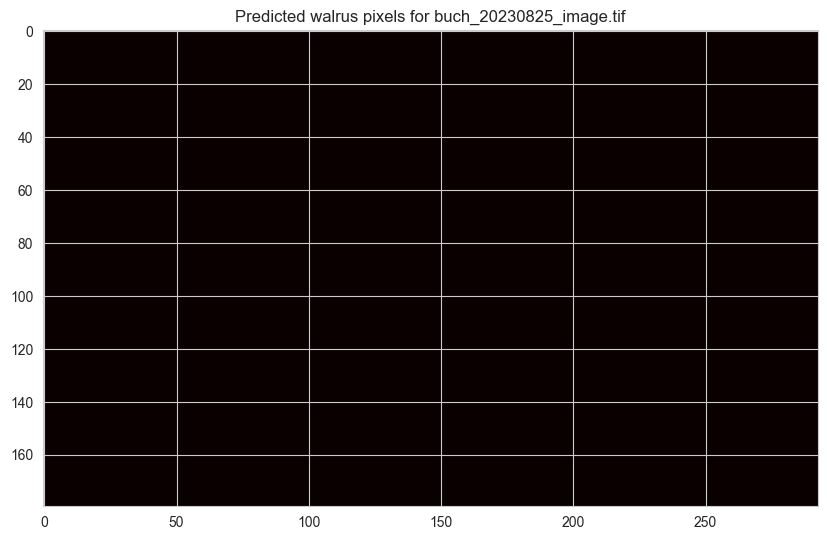

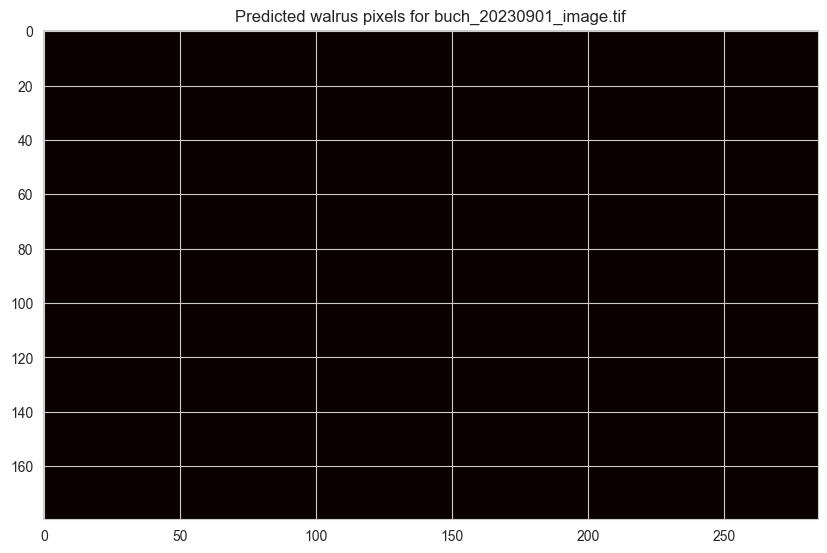

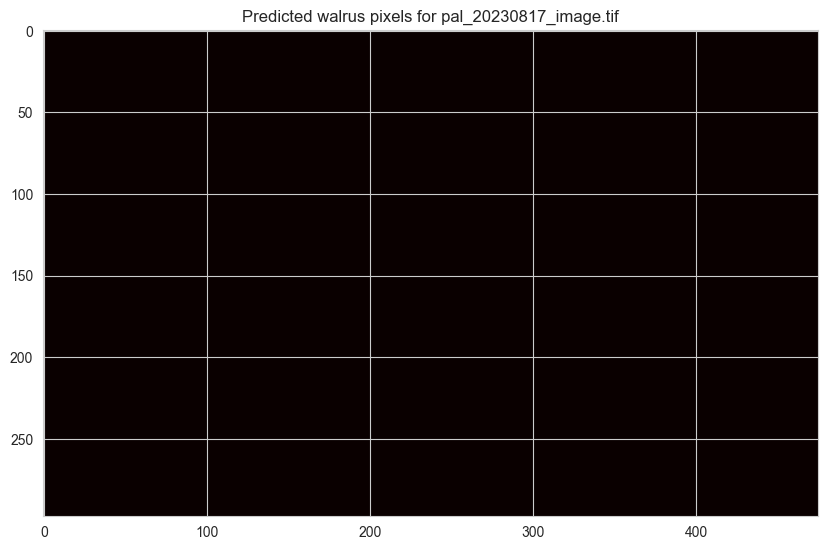

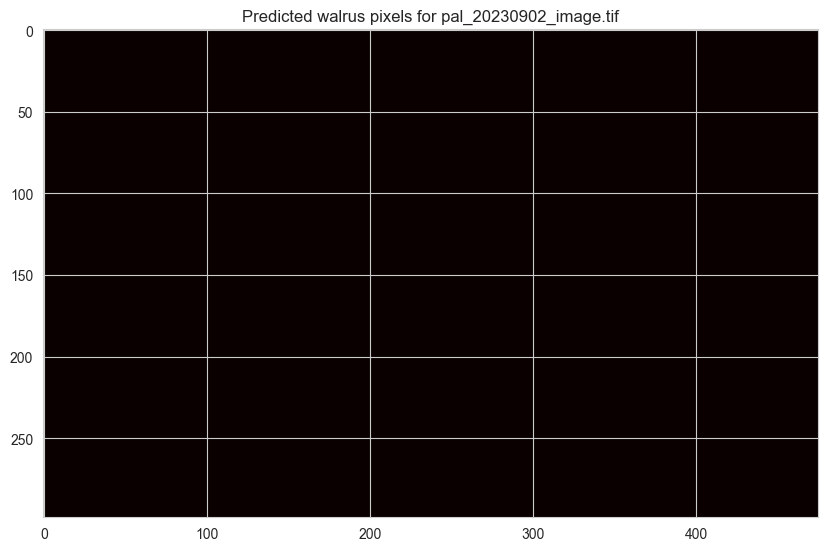

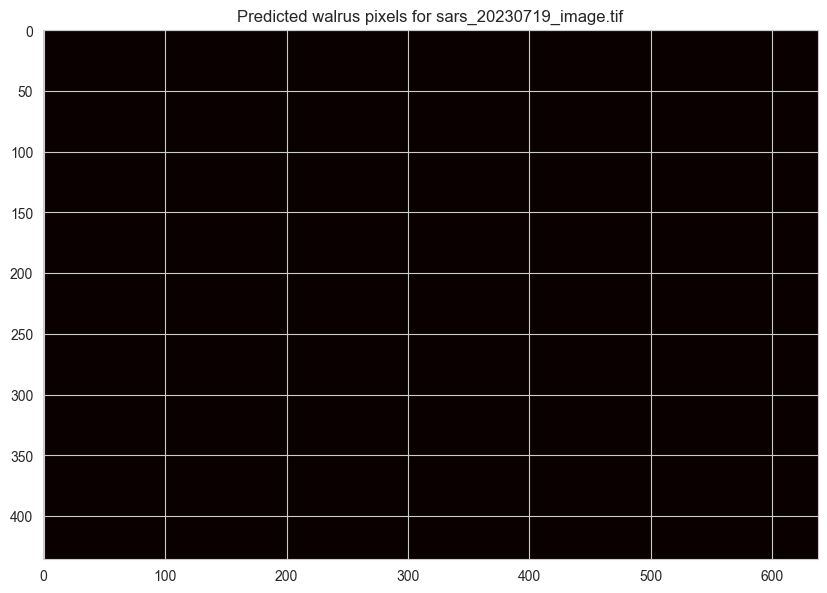

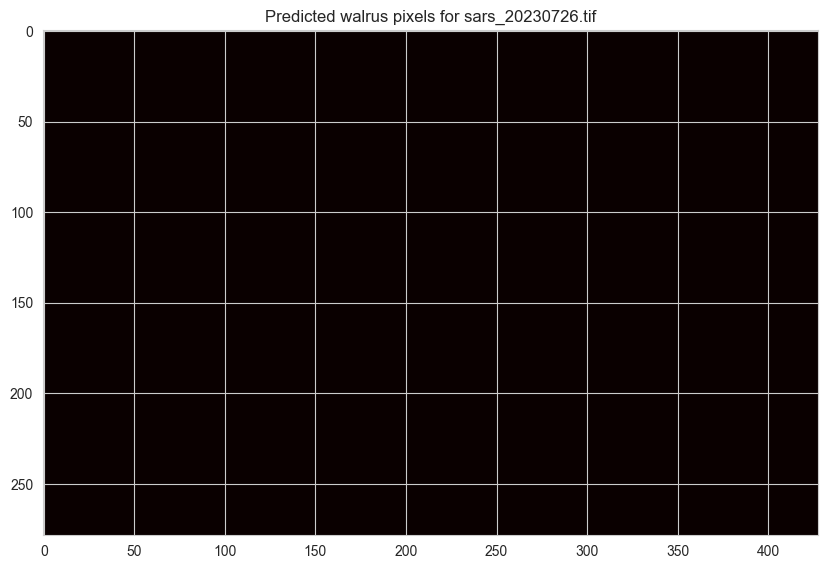

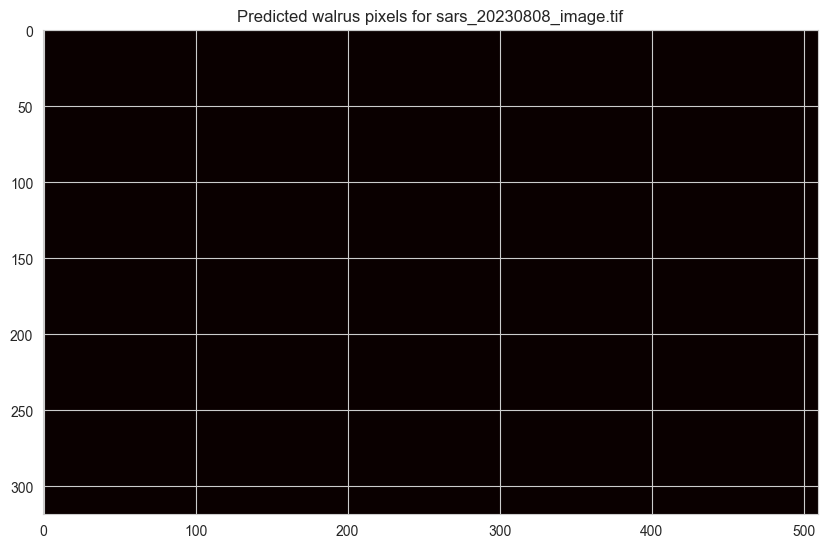

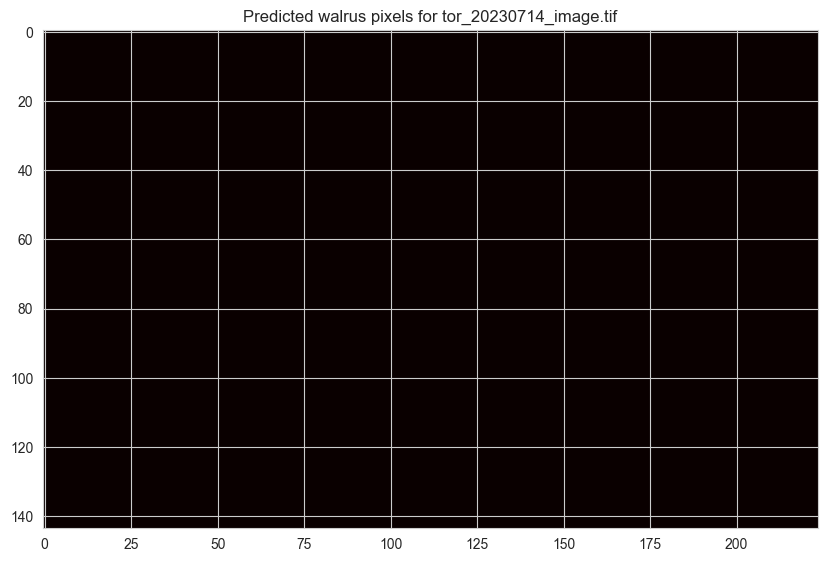

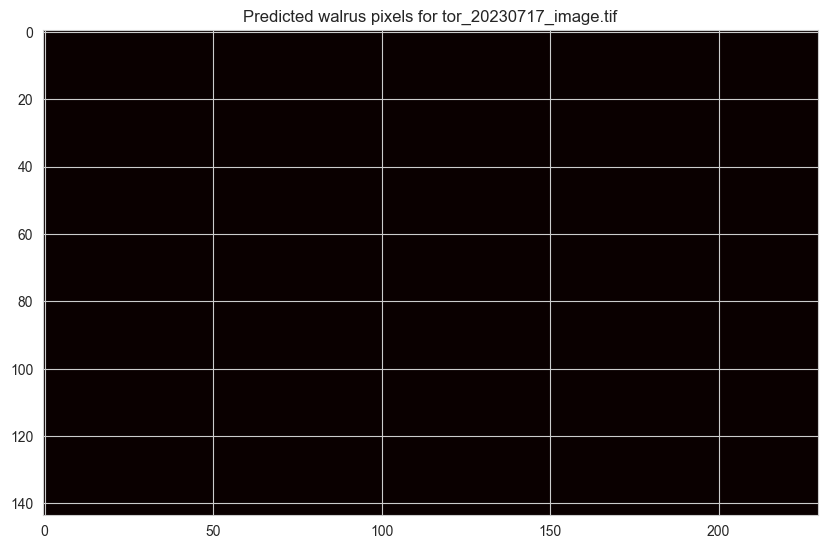

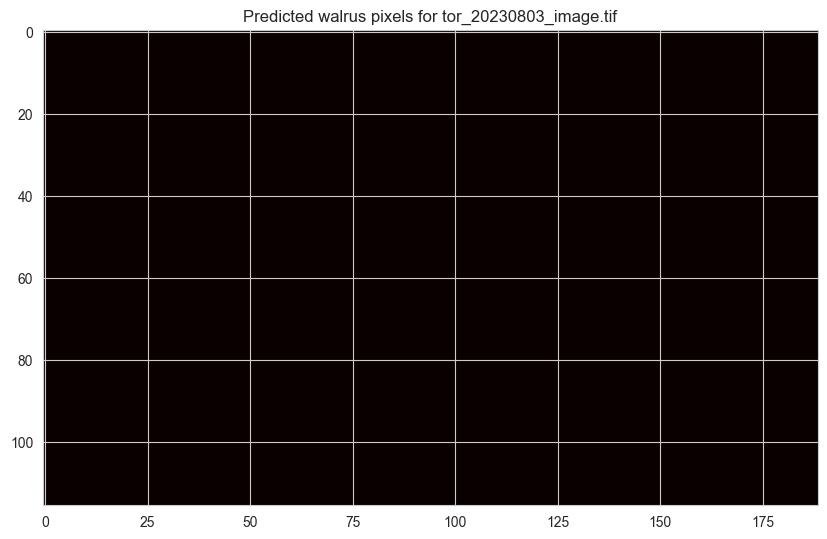

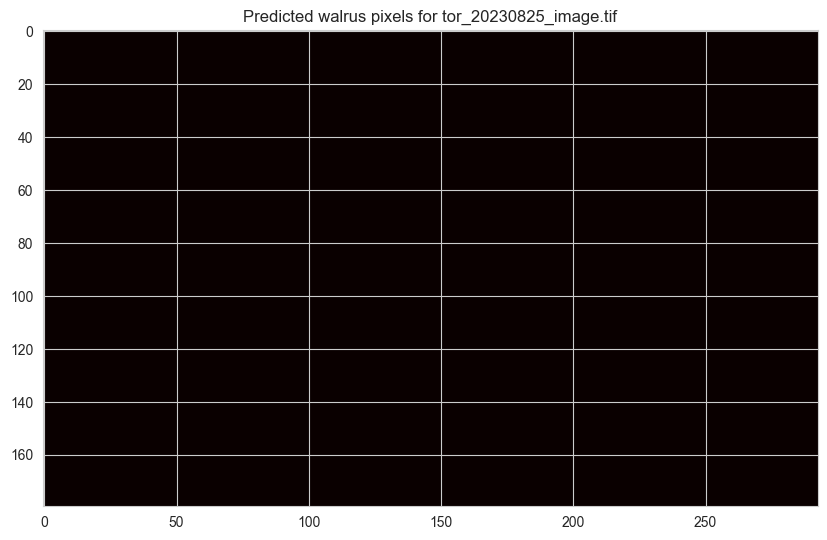

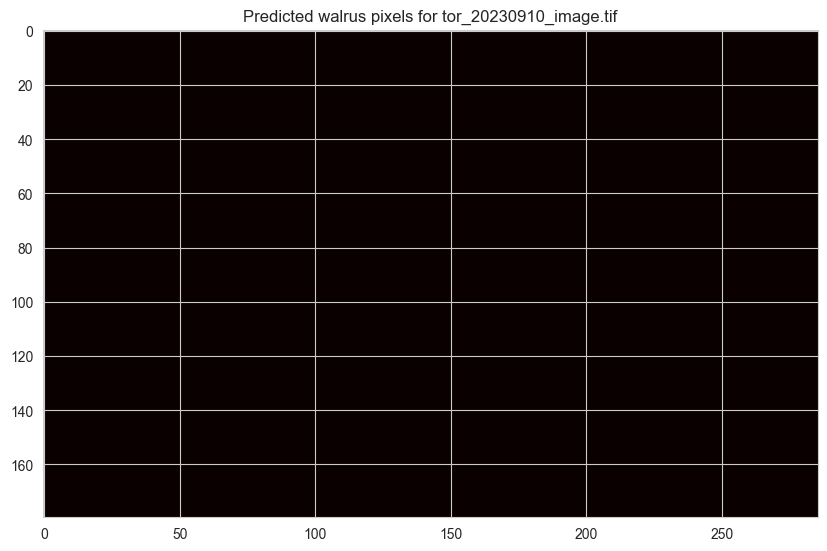

In [17]:
# Plot the predictions
def plot_predictions(image_path, walrus_clusters):
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted walrus pixels for {os.path.basename(image_path)}")
    plt.imshow(walrus_clusters, cmap='hot')
    plt.show()

# Predict and plot for unlabeled images
for image_path in unlabeled_image_paths:
    walrus_pixels = predict_walrus_pixels(image_path, walrus_pure_spectral, walrus_mixed_spectral)
    walrus_clusters = apply_spatial_rules(walrus_pixels)
    plot_predictions(image_path, walrus_clusters)


In [3]:
import os 
import numpy as np
import pandas as pd
import rasterio
from scipy.spatial.distance import euclidean
from scipy.ndimage import label, binary_dilation, distance_transform_edt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import glob
import re
from sklearn.preprocessing import LabelEncoder
import geopandas as gpd
from rasterio.features import geometry_mask

In [4]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    shapefile_path = matching_shapefiles[0]
    file_pairs[image_path] = shapefile_path

# Function to extract features and labels
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    img_name = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']

        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
            img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

features = []
labels = []
image_name = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)
    image_name.append(img_name)

features = np.vstack(features)
labels = np.hstack(labels)
image_name = np.hstack(image_name)
print(features, labels, image_name)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({'Coast_blue': features[:, 0],
                        'Blue': features[:, 1],
                        'Green1': features[:, 2],
                        'Green': features[:, 3],
                        'Yellow': features[:, 4],
                        'Red': features[:, 5],
                        'Red_edge': features[:, 6],
                        'NIR': features[:, 7],
                        'labels': labels,
                        'encoded_labels': encoded_labels,
                        'image_name': image_name})


No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif
[[1187  980 1269 ... 1329 1416 1650]
 [1148  912 1212 ... 1240 1297 1612]
 [1131  856 1162 ... 1181 1355 1510]
 ...
 [1730 1870 1929 ... 2091 2276 2647]
 [1634 1851 1879 ... 2053 2281 2634]
 [1720 1904 1905 ... 2135 2316 2654]] ['walrus_mixed' 'walrus_mixed' 'walrus_mixed' ... 'freshwater'
 'freshwater' 'freshwater'] ['C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 ...
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_ima

In [5]:
# Bands
bands = ['Coast_blue', 'Blue', 'Green1', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR']

# Load the walrus spectral profile
walrus_profile = dataset[dataset['labels'].isin(['walrus_pure', 'walrus_mixed'])][bands].mean().values

In [6]:
# Function to calculate spectral distance
def spectral_distance(pixel, profile):
    return euclidean(pixel, profile)

# Function to predict walrus pixels in an image
def predict_walrus_pixels(image_path, walrus_profile, threshold, ocean_threshold):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    # Reshape the image for easier processing
    image_reshaped = image.reshape((image.shape[0], -1)).T

    # Calculate spectral distance for each pixel
    distances = np.array([spectral_distance(pixel, walrus_profile) for pixel in image_reshaped])
    distances = distances.reshape((src.height, src.width))

    # Identify candidate pixels
    candidate_pixels = distances < threshold

    # Label connected regions of candidate pixels
    labeled_array, num_features = label(candidate_pixels)

    # Create ocean and land masks
    ocean_mask = (image[0] < ocean_threshold)  # Define ocean threshold
    land_mask = ~ocean_mask

    # Function to check if a cluster is valid based on spatial constraints
    def is_valid_cluster(cluster, ocean_mask, land_mask):
        if np.sum(cluster) < 5:  # Minimum cluster size
            return False
        if np.min(distance_transform_edt(~ocean_mask)[cluster]) > 10:  # Proximity to ocean
            return False
        if np.sum(cluster & ocean_mask) > 0:  # Should not overlap with ocean
            return False
        return True

    # Filter clusters based on spatial constraints
    valid_clusters = np.zeros_like(candidate_pixels)
    for i in range(1, num_features + 1):
        cluster = labeled_array == i
        if is_valid_cluster(cluster, ocean_mask, land_mask):
            valid_clusters[cluster] = 1

    # Perform binary dilation to include surrounding pixels
    valid_clusters = binary_dilation(valid_clusters, iterations=2)

    return valid_clusters


In [7]:
# Function to overlay predicted pixels on the image
def plot_predicted_pixels(image_path, predicted_pixels, title):
    with rasterio.open(image_path) as src:
        image = src.read(1)  # Read the first band for visualization

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    plt.imshow(predicted_pixels, cmap='hot', alpha=0.5)
    plt.title(title)
    plt.show()


In [10]:
# Evaluate the predictions on all labeled images
def evaluate_predictions(file_pairs, walrus_profile, threshold, ocean_threshold):
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    for image_path, shapefile_path in file_pairs.items():
        predicted_walrus_pixels = predict_walrus_pixels(image_path, walrus_profile, threshold, ocean_threshold)
        
        # Load the ground truth walrus labels from the shapefile
        with rasterio.open(image_path) as src:
            image = src.read()
            transform = src.transform

        gdf = gpd.read_file(shapefile_path)
        ground_truth = np.zeros((src.height, src.width), dtype=np.uint8)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            if row['label'] in ['walrus_pure', 'walrus_mixed']:
                ground_truth[mask] = 1  # Mark walrus pixels

        ground_truth_walrus = (ground_truth == 1)

        # Plot the predicted walrus pixels on the labeled image
        plot_predicted_pixels(image_path, predicted_walrus_pixels, f'Predicted Walrus Pixels on {os.path.basename(image_path)}')

        # Plot the ground truth walrus pixels for comparison
        plot_predicted_pixels(image_path, ground_truth_walrus, f'Ground Truth Walrus Pixels on {os.path.basename(image_path)}')

        # Evaluate accuracy
        accuracy = accuracy_score(ground_truth_walrus.flatten(), predicted_walrus_pixels.flatten())
        precision = precision_score(ground_truth_walrus.flatten(), predicted_walrus_pixels.flatten())
        recall = recall_score(ground_truth_walrus.flatten(), predicted_walrus_pixels.flatten())
        f1 = f1_score(ground_truth_walrus.flatten(), predicted_walrus_pixels.flatten())

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        print(f"{os.path.basename(image_path)} - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

    # Print average metrics
    print(f"Average Accuracy: {np.mean(accuracies)}")
    print(f"Average Precision: {np.mean(precisions)}")
    print(f"Average Recall: {np.mean(recalls)}

SyntaxError: EOL while scanning string literal (179114483.py, line 47)

In [ ]:

# Example usage for labeled images
labeled_image_paths = image_paths  # Your list of labeled images
ground_truth_paths = [f"ground_truth_path_{i}.tif" for i in range(len(labeled_image_paths))]  # Replace with actual ground truth paths
threshold = 100  # Adjust threshold as needed
ocean_threshold = 100  # Adjust ocean threshold based on your data

evaluate_predictions(labeled_image_paths, walrus_profile, threshold, ocean_threshold, ground_truth_paths)

# Predict walrus pixels in all unseen images
for unseen_image_path in unlabeled_image_paths:
    predicted_walrus_pixels_unseen = predict_walrus_pixels(unseen_image_path, walrus_profile, threshold, ocean_threshold)
    plot_predicted_pixels(unseen_image_path, predicted_walrus_pixels_unseen, f'Predicted Walrus Pixels on {os.path.basename(unseen_image_path)}')
